In [9]:
# Importing dependency
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
import torchprofile
from fvcore.nn import FlopCountAnalysis, parameter_count
from einops import rearrange

import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio 
import mat73

from colorama import Fore, Style
from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')
print(Fore.GREEN + '❄️ Done' + Style.RESET_ALL)

❄️ Done


In [10]:
# Device
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')
print(Fore.BLUE +'❄️ Compute Device:' + Style.RESET_ALL, end=' ')
print(Fore.GREEN + str(device) + Style.RESET_ALL)    

❄️ Compute Device: cuda


In [11]:
# Dataset Class
class CustomDataset(Dataset):
    def __init__(self, path:str):
        self.a = sio.loadmat(path)['HT']
        self.b = np.reshape(self.a, (int(self.a.shape[0]/2), 4, 32, 32))
    
    def __len__(self):
        return len(self.b)
    
    def __getitem__(self, idx):
        sample = self.b[idx]
        return torch.tensor(sample, dtype=torch.float32)
    
# Dataset Class 2
class CustomDataset2(Dataset):
    def __init__(self, path:str):
        self.a = sio.loadmat(path)['HT']
        self.b = np.reshape(self.a, (int(self.a.shape[0]/2), 4, 32, 32))
        self.c = self.b[:, 2:4, :, :]
    
    def __len__(self):
        return len(self.c)
    
    def __getitem__(self, idx):
        sample = self.c[idx]
        return torch.tensor(sample, dtype=torch.float32)    

In [12]:
# Dataset
train_data = CustomDataset('./Data/train.mat')
val_data = CustomDataset('./Data/val.mat')
test_data = CustomDataset('./Data/test.mat')
train_data2 = CustomDataset2('./Data/train.mat')

# DataLoader
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=5000, shuffle=False)
test_loader = DataLoader(test_data, batch_size=6000, shuffle=False)

In [13]:
# Custom Activation
class CustumGausian(nn.Module):
    def __init__(self, alpha=0.5, mean=0.5):
        super(CustumGausian, self).__init__()
        self.alpha = alpha
        self.mean = mean
        
    def forward(self, x):
        x = torch.exp(-(self.alpha*(x-self.mean)**2))
        return x
    

    
# Patch Embedding Layer: (patch partition ---> linear embedding)
class PatchEmbedding(nn.Module):
    """ 
    input: (B, C, H, W) --> (100000, 4, 32, 32)
    output: (B, P1, C1) --> (100000, 256, 64)
    """
    def __init__(self, in_channels=4, embed_dim=64, patch_size=2): # embed_dim = C1 = 64
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Linear(patch_size*patch_size*in_channels, embed_dim)
        
    def forward(self, x):
        # Patch Partition
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, height//self.patch_size, self.patch_size, width//self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 1, 3, 5).contiguous()
        x = x.view(batch_size, -1, self.patch_size*self.patch_size*channels)
        # Linear Embedding
        x = self.proj(x)
        return x
    
    
# Positional Embedding   
class PositionalEmbedding(nn.Module):
    """ 
    input: (B, P1, C1) --> (100000, 256, 64)
    output: (B, P1, C1+E1) --> (10000, 256, 64)
    """
    def __init__(self, d_model=64, seq_len=256, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        # Create a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        # Create a vector of shape (seq_len, 1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float)*(-math.log(10000.0)/d_model))
        # Apply sin to even position
        pe[:, 0::2] = torch.sin(position*div_term)
        # aPPLY cos to odd position
        pe[:, 1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0) # (1, seq_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)
        
        
        
        
# Patch Merging Layer:
class PatchMerging(nn.Module):
    """ 
    input: (B, P1, C1) --> (100000, 256, 64)
    output: (B, P2, C2) --> (100000, 64, 128)
    """
    def __init__(self, input_resolution=(16, 16), dim=64, out_dim=128, patch_size=2):
        super(PatchMerging, self).__init__()
        self.input_resolution = input_resolution # (16, 16)
        self.dim = dim
        self.out_dim = out_dim
        self.patch_size = patch_size
        self.reduction = nn.Linear(patch_size*patch_size*dim, out_dim) 
    
    def forward(self, x):
        batch_size, num_patches, dim = x.shape
        H, W = self.input_resolution
        x = x.view(batch_size, H, W, dim)
        x = x.permute(0, 3, 1, 2).contiguous()
        x0 = x[:, :, 0::2, 0::2]       
        x1 = x[:, :, 0::2, 1::2]
        x2 = x[:, :, 1::2, 0::2]  
        x3 = x[:, :, 1::2, 1::2]  
        x = torch.cat([x0, x1, x2, x3], dim=1)
        x = x.view(batch_size, dim*4, -1).permute(0, 2, 1).contiguous()
        x = self.reduction(x)
        return x
            


# Patch Division Layer:
class PatchDivision(nn.Module):
    """ 
    input: (B, P2, C2) --> (10000, 64, 128)
    output: (B, P1, C1) --> (10000, 256, 64)
    
    and 
    
    input: (B, P1, C1) --> (10000, 256, 64)
    output: (B, 1024, 2) --> (10000, 1024, 4)
    """
    def __init__(self, input_resolution, dim, output_dim, patch_size=2):
        super(PatchDivision, self).__init__()
        self.input_resolution = input_resolution # (8, 8)
        self.dim = dim
        self.output_dim = output_dim
        self.patch_size = patch_size
        self.expansion = nn.Linear(dim, patch_size*patch_size*output_dim)
        
    def forward(self, x):
        batch_size, num_patches, dim = x.shape
        H, W = self.input_resolution
        x = self.expansion(x)
        x = x.view(batch_size, num_patches, self.output_dim*4)
        x = x.view(batch_size, H, W, self.output_dim, 2, 2)
        x = x.permute(0, 3, 1, 4, 2, 5).contiguous()
        x = x.view(batch_size, self.output_dim, H*2, W*2)
        x = x.permute(0, 2, 3, 1)
        x = x.view(batch_size, -1, self.output_dim)
        return x



# Multilayer Perceptron
class MLP(nn.Module):
    """
    input: (B, P2, C2)
    output: (B, P2, C)
    """
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x



# Window-based Mask Multi-Head Self Attention
class WindowMSA(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super(WindowMSA, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.proj = nn.Linear(dim, dim)
        
    def forward(self, x):
        B, H, W, C = x.shape
        x = x.view(B, H // self.window_size, self.window_size, W // self.window_size, self.window_size, C)
        x = rearrange(x, 'b nh ph nw pw c -> (b nh nw) (ph pw) c')
        qkv = self.qkv(x).reshape(-1, self.window_size * self.window_size, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).chunk(3, dim=0)
        q, k, v = q[0], k[0], v[0]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(-1, self.window_size * self.window_size, C)
        out = self.proj(out)
        nh = H // self.window_size
        nw = W // self.window_size
        out = rearrange(out, '(b nh nw) (ph pw) c -> b (nh ph) (nw pw) c', b=B, nh=nh, nw=nw, ph=self.window_size, pw=self.window_size)
        return out



# Swin Transformer Block1
class SwinTransformerBlock1(nn.Module):
    def __init__(self, dim, num_heads, window_size, mlp_ratio=4., dropout=0.0):
        super(SwinTransformerBlock1, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout)
        self.attn = WindowMSA(dim, num_heads, window_size)
        self.drop_path = nn.Identity()
    # Post Normalization   
    def forward(self, x):
        H, W = x.shape[1], x.shape[2]
        shortcut = x
        x = self.attn(x) # Attention Layer
        x = shortcut + self.drop_path(x) # Add Layer
        x = self.norm1(x) # Norm Layer
        x = self.mlp(x) # MLP Layer
        x = x + self.drop_path(x) # Add Layer
        x = self.norm2(x) # Norm Layer
        return x
    
    
    
# Swin Transformer Block2
class SwinTransformerBlock2(nn.Module):
    def __init__(self, dim, num_heads, window_size, mlp_ratio=4., dropout=0.0, shift_size=0):
        super(SwinTransformerBlock2, self).__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout)
        self.shift_attn = WindowMSA(dim, num_heads, window_size)
        self.drop_path = nn.Identity()
    # Post Normalization   
    def forward(self, x):
        H, W = x.shape[1], x.shape[2]
        shortcut = x
        x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        x = self.shift_attn(x) # Attention Layer
        x = torch.roll(x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        x = shortcut + self.drop_path(x) # Add Layer
        x = self.norm1(x) # Norm Layer
        x = self.mlp(x) # MLP Layer
        x = x + self.drop_path(x) # Add Layer
        x = self.norm2(x) # Norm Layer
        return x    
    



# SwinTransformer
class SwinTransformer(nn.Module):
    def __init__(self, dim, num_heads1, num_heads2, window_size, mlp_ratio=4., dropout=0.0, shift_size=2):
        super(SwinTransformer, self).__init__()
        self.block1 = SwinTransformerBlock1(dim, num_heads1, window_size, mlp_ratio, dropout)
        self.block2 = SwinTransformerBlock2(dim, num_heads2, window_size, mlp_ratio, dropout, shift_size)
        
    def forward(self, x):
        x = self.block1(x)   
        x = self.block2(x) 
        return x
    
    
    
    
# Encoder Block
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.patch_embedding = PatchEmbedding(in_channels=4, embed_dim=64, patch_size=2)
        self.position_embedding= PositionalEmbedding(d_model=64, seq_len=256, dropout=0.0)
        self.swintransformer1 = SwinTransformer(dim=64, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer2 = SwinTransformer(dim=64, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.patchmerge = PatchMerging(input_resolution=(16, 16), dim=64, out_dim=128, patch_size=2)
        self.swintransformer3 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer4 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer5 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer6 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.linear = nn.Linear(8192, 512)
        
    def forward(self, x):
        x = self.patch_embedding(x)
        x=self.position_embedding(x)
        x = x.view(x.shape[0], 16, 16, 64)
        x = self.swintransformer1(x)   
        x = self.swintransformer2(x) 
        x = x.view(x.shape[0], 256, 64)
        x = self.patchmerge(x)
        x = x.view(x.shape[0], 8, 8, 128)
        x = self.swintransformer3(x)
        x = self.swintransformer4(x)
        x = self.swintransformer5(x)
        x = self.swintransformer6(x)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x



# Decoder Block
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(512, 8192)
        self.swintransformer1 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer2 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer3 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer4 = SwinTransformer(dim=128, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.patchdiv1 = PatchDivision(input_resolution=(8, 8), dim=128, output_dim=64, patch_size=2)
        self.swintransformer5 = SwinTransformer(dim=64, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.swintransformer6 = SwinTransformer(dim=64, num_heads1=4, num_heads2=8, window_size=2, mlp_ratio=4., shift_size=2)
        self.patchdiv2 = PatchDivision(input_resolution=(16, 16), dim=64, output_dim=4, patch_size=2)
        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], 8, 8, 128)
        x = self.swintransformer1(x)
        x = self.swintransformer2(x)
        x = self.swintransformer3(x)
        x = self.swintransformer4(x)
        x = x.view(x.shape[0], 64, 128)
        x = self.patchdiv1(x)
        x = x.view(x.shape[0], 16, 16, 64)
        x = self.swintransformer5(x)
        x = self.swintransformer6(x)
        x = x.view(x.shape[0], 256, 64)
        x = self.patchdiv2(x)
        x = x.view(x.shape[0], 32, 32, 4)
        x = x.permute(0, 3, 1, 2)
        return x
    
    
# SwinCFNet    
class SwinCFNet(nn.Module):
    def __init__(self):
        super(SwinCFNet, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x        


In [14]:
# NMSE Function
def evaluator(sparse_pred, sparse_gt):
    """ 
    Evaluation of decoding implemented in PyTorch Tensor
    Computes normalized mean square error (NMSE).
    """
    
     # Convert numpy arrays to PyTorch tensors
    if isinstance(sparse_gt, np.ndarray):
        sparse_gt = torch.tensor(sparse_gt, dtype=torch.float32)
    if isinstance(sparse_pred, np.ndarray):
        sparse_pred = torch.tensor(sparse_pred, dtype=torch.float32)
        
    sparse_gt = sparse_gt.to(device)
    sparse_pred = sparse_pred.to(device)
    with torch.no_grad():
        # De-centralize - nmse1
        sparse_gt1 = sparse_gt[:, 0:2, :, :] - 0.5
        sparse_pred1 = sparse_pred[:, 0:2, :, :] - 0.5
        # Calculate the NMSE
        power_gt1 = sparse_gt1[:, 0, :, :] ** 2 + sparse_gt1[:, 1, :, :] ** 2
        difference1 = sparse_gt1 - sparse_pred1
        mse1 = difference1[:, 0, :, :] ** 2 + difference1[:, 1, :, :] ** 2
        nmse1 = 10 * torch.log10((mse1.sum(dim=(1, 2)) / power_gt1.sum(dim=(1, 2))).mean())
        
        # De-centarlize - nmse2
        sparse_gt2 = sparse_gt[:, 2:4, :, :] - 0.5
        sparse_pred2 = sparse_pred[:, 2:4, :, :] - 0.5
        # Calculate the NMSE
        power_gt2 = sparse_gt2[:, 0, :, :] ** 2 + sparse_gt2[:, 1, :, :] ** 2
        difference2 = sparse_gt2 - sparse_pred2
        mse2 = difference2[:, 0, :, :] ** 2 + difference2[:, 1, :, :] ** 2
        nmse2 = 10 * torch.log10((mse2.sum(dim=(1, 2)) / power_gt2.sum(dim=(1, 2))).mean())
        return float(nmse1), float(nmse2)

In [15]:
# Seed
seed=42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Initialization
autoencoder = SwinCFNet().to(device)
# Loss
criterion = nn.MSELoss().to(device)
# Optimizer
optimizer = Adam(autoencoder.parameters(), lr=1e-4)
# Manually set initial_lr for each parameter group
for param_group in optimizer.param_groups:
    if 'initial_lr' not in param_group:
        param_group['initial_lr'] = param_group['lr']         
# Schedular
schedular = ExponentialLR(optimizer=optimizer, gamma=0.999, last_epoch=-1)

In [16]:
# Model params count
def ParamCount(model):
    params=sum(p.numel() for p in model.parameters() if p.requires_grad)
    return print(Fore.BLUE + '- ParamsCount:'+ Style.RESET_ALL,
                Fore.GREEN + f'{params/1000000:.3f} Millions' + Style.RESET_ALL)

# Flops count
def FlopCount(model):
    test=torch.randn(1, 4, 32, 32).to(device)
    flops=torchprofile.profile_macs(autoencoder, test)
    return print(Fore.BLUE + '- FlopsCount:'+ Style.RESET_ALL,
                Fore.GREEN + f'{flops}' + Style.RESET_ALL)    

# Calling function    
ParamCount(autoencoder)
FlopCount(autoencoder)

- ParamsCount: 12.030 Millions
- FlopsCount: 317792546


In [17]:
# Params and Flops count
def ParamFlopCount(model):
    test=torch.randn(1, 4, 32, 32).to(device)
    flop_counter=FlopCountAnalysis(autoencoder, test)
    flops=flop_counter.total()
    params = parameter_count(autoencoder)['']
    time_start=time.time()
    test_hat=model(test)
    time_end=time.time()
    total_time=time_end-time_start
    return {'Params': params, 'Flops':flops, 'RunTime': total_time}

# Calling function
ParamFlopCount(autoencoder)

Unsupported operator aten::mul encountered 194 time(s)
Unsupported operator aten::add encountered 49 time(s)
Unsupported operator aten::mul_ encountered 120 time(s)
Unsupported operator aten::softmax encountered 24 time(s)
Unsupported operator aten::gelu encountered 24 time(s)


{'Params': 12029904, 'Flops': 319815680, 'RunTime': 0.033037662506103516}

In [18]:
# Model training and Validation
num_epochs = 1000
train_losses = []
val_losses = []
nmse1_score = []
nmse2_score = []
for epoch in tqdm_notebook(range(num_epochs), desc='Model Training'):
    # Model Training
    autoencoder.train()
    train_loss = 0
    for data in tqdm_notebook(train_loader, 'Batch Training'):
        data = data.to(device)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    # Train Loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    schedular.step()
    
    # Model Validation
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm_notebook(val_loader, 'Validating Model'):
            data = data.to(device)
            output = autoencoder(data)
            loss = criterion(output, data)
            val_loss += loss.item() * data.size(0)     
    # Validation Loss
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    # Model Testing
    autoencoder.eval()
    with torch.no_grad():
        nmse1_error = 0
        nmse2_error = 0
        for data in tqdm_notebook(test_loader, 'Calculating NMSE'):
            data = data.to(device)
            output = autoencoder(data)
            nmse1, nmse2 = evaluator(output, data) 
            nmse1_error+=nmse1
            nmse2_error+=nmse2
        avg_nmse1 = nmse1_error/6
        avg_nmse2 = nmse2_error/6
        nmse1_score.append(avg_nmse1)    
        nmse2_score.append(avg_nmse2)
               
    print(Fore.LIGHTBLUE_EX + f'- Epoch: {epoch+1}/{num_epochs}' + Style.RESET_ALL)
    print(Fore.RED + f'- Train Loss: {train_loss:.9f} | Validation Loss: {val_loss:.9f}' + Style.RESET_ALL, end=' ')
    print(Fore.CYAN + f'| Current Learning Rate: {schedular.optimizer.param_groups[0]['lr']:.7f}' + Style.RESET_ALL, end=' ')
    print(Fore.GREEN + f'| NMSE1: {avg_nmse1:.7f} -- NMSE2: {avg_nmse2:.7f}' + Style.RESET_ALL)
    print(Fore.MAGENTA + '-'*150 + Style.RESET_ALL)
    
    if (epoch+1)%1==0:
        # Saving models checkpoint
        if avg_nmse1<=min(nmse1_score) or avg_nmse2<=min(nmse2_score):
        #if train_loss<=min(train_losses) or val_loss<=min(val_losses):
            params = {
                'epoch': epoch+1,
                'lr': schedular.optimizer.param_groups[0]['lr'],
                'model': autoencoder.state_dict(),
                'criterion': criterion.state_dict(),
                'optimizer': optimizer.state_dict(),
                'schedular': schedular.state_dict()
            }
            if avg_nmse1<=min(nmse1_score):
                torch.save(params, f'./Models/best_nmse1.pth')
            else:
                torch.save(params, f'./Models/best_nmse2.pth')
    np.savetxt(f'nmse1_scores.csv', np.array(nmse1_score), delimiter=",")
    np.savetxt(f'nmse2_scores.csv', np.array(nmse2_score), delimiter=",")
    np.savetxt(f'train_losses.csv', np.array(train_losses), delimiter=",")
    np.savetxt(f'val_losses.csv', np.array(val_losses), delimiter=",")        

# Save training and validation losses
#np.savetxt('final_train_losses_dim128_out.csv', np.array(train_losses), delimiter=",")
#np.savetxt('final_val_losses_dim128_out.csv', np.array(val_losses), delimiter=",")
#np.savetxt('final_nmse_dim128_out.csv', np.array(nmse_score), delimiter=",")

Model Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 1/1000
- Train Loss: 0.012568490 | Validation Loss: 0.009426629 | Current Learning Rate: 0.0000999 | NMSE1: 0.0018021 -- NMSE2: 0.0016615
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 2/1000
- Train Loss: 0.008514357 | Validation Loss: 0.009425002 | Current Learning Rate: 0.0000998 | NMSE1: 0.0007840 -- NMSE2: 0.0008717
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 3/1000
- Train Loss: 0.008514027 | Validation Loss: 0.009425964 | Current Learning Rate: 0.0000997 | NMSE1: 0.0009642 -- NMSE2: 0.0016893
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 4/1000
- Train Loss: 0.008514273 | Validation Loss: 0.009426485 | Current Learning Rate: 0.0000996 | NMSE1: 0.0013526 -- NMSE2: 0.0016543
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 5/1000
- Train Loss: 0.008514639 | Validation Loss: 0.009428290 | Current Learning Rate: 0.0000995 | NMSE1: 0.0032610 -- NMSE2: 0.0019483
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 6/1000
- Train Loss: 0.008514930 | Validation Loss: 0.009427248 | Current Learning Rate: 0.0000994 | NMSE1: 0.0032553 -- NMSE2: 0.0007369
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 7/1000
- Train Loss: 0.008515528 | Validation Loss: 0.009433437 | Current Learning Rate: 0.0000993 | NMSE1: 0.0071913 -- NMSE2: 0.0027102
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 8/1000
- Train Loss: 0.008517159 | Validation Loss: 0.009427591 | Current Learning Rate: 0.0000992 | NMSE1: 0.0017764 -- NMSE2: 0.0021217
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 9/1000
- Train Loss: 0.008517684 | Validation Loss: 0.009486434 | Current Learning Rate: 0.0000991 | NMSE1: 0.0291527 -- NMSE2: 0.0296088
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 10/1000
- Train Loss: 0.008519580 | Validation Loss: 0.009440706 | Current Learning Rate: 0.0000990 | NMSE1: 0.0063194 -- NMSE2: 0.0093440
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 11/1000
- Train Loss: 0.008518929 | Validation Loss: 0.009442712 | Current Learning Rate: 0.0000989 | NMSE1: 0.0133120 -- NMSE2: 0.0053310
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 12/1000
- Train Loss: 0.008520071 | Validation Loss: 0.009451150 | Current Learning Rate: 0.0000988 | NMSE1: 0.0127429 -- NMSE2: 0.0121943
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 13/1000
- Train Loss: 0.008518729 | Validation Loss: 0.009431991 | Current Learning Rate: 0.0000987 | NMSE1: 0.0051566 -- NMSE2: 0.0029062
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 14/1000
- Train Loss: 0.008158947 | Validation Loss: 0.004244499 | Current Learning Rate: 0.0000986 | NMSE1: -3.4296179 -- NMSE2: -3.3751421
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 15/1000
- Train Loss: 0.003092310 | Validation Loss: 0.002502319 | Current Learning Rate: 0.0000985 | NMSE1: -5.6495177 -- NMSE2: -5.6052699
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 16/1000
- Train Loss: 0.002195730 | Validation Loss: 0.002185252 | Current Learning Rate: 0.0000984 | NMSE1: -6.3462755 -- NMSE2: -6.3195058
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 17/1000
- Train Loss: 0.001797469 | Validation Loss: 0.001836824 | Current Learning Rate: 0.0000983 | NMSE1: -7.0860391 -- NMSE2: -7.0602027
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 18/1000
- Train Loss: 0.001599466 | Validation Loss: 0.001670709 | Current Learning Rate: 0.0000982 | NMSE1: -7.4713019 -- NMSE2: -7.4516757
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 19/1000
- Train Loss: 0.001495649 | Validation Loss: 0.001552731 | Current Learning Rate: 0.0000981 | NMSE1: -7.7692528 -- NMSE2: -7.7534294
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 20/1000
- Train Loss: 0.001392350 | Validation Loss: 0.001523143 | Current Learning Rate: 0.0000980 | NMSE1: -7.8288298 -- NMSE2: -7.8413012
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 21/1000
- Train Loss: 0.001331103 | Validation Loss: 0.001439407 | Current Learning Rate: 0.0000979 | NMSE1: -8.0973755 -- NMSE2: -8.0769087
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 22/1000
- Train Loss: 0.001267011 | Validation Loss: 0.001301273 | Current Learning Rate: 0.0000978 | NMSE1: -8.4848670 -- NMSE2: -8.4660360
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 23/1000
- Train Loss: 0.001092699 | Validation Loss: 0.001098456 | Current Learning Rate: 0.0000977 | NMSE1: -9.0984974 -- NMSE2: -9.1013877
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 24/1000
- Train Loss: 0.000891760 | Validation Loss: 0.001020930 | Current Learning Rate: 0.0000976 | NMSE1: -9.4412705 -- NMSE2: -9.4700793
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 25/1000
- Train Loss: 0.000772560 | Validation Loss: 0.001080246 | Current Learning Rate: 0.0000975 | NMSE1: -9.2593247 -- NMSE2: -9.2935788
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 26/1000
- Train Loss: 0.000728618 | Validation Loss: 0.000808202 | Current Learning Rate: 0.0000974 | NMSE1: -10.4371336 -- NMSE2: -10.4265641
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 27/1000
- Train Loss: 0.000697379 | Validation Loss: 0.000809496 | Current Learning Rate: 0.0000973 | NMSE1: -10.4218537 -- NMSE2: -10.4514360
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 28/1000
- Train Loss: 0.000652469 | Validation Loss: 0.000792917 | Current Learning Rate: 0.0000972 | NMSE1: -10.5485239 -- NMSE2: -10.5232574
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 29/1000
- Train Loss: 0.000626988 | Validation Loss: 0.000743980 | Current Learning Rate: 0.0000971 | NMSE1: -10.7926149 -- NMSE2: -10.7830558
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 30/1000
- Train Loss: 0.000603973 | Validation Loss: 0.000768379 | Current Learning Rate: 0.0000970 | NMSE1: -10.6623642 -- NMSE2: -10.6942703
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 31/1000
- Train Loss: 0.000581642 | Validation Loss: 0.000720606 | Current Learning Rate: 0.0000969 | NMSE1: -10.9494521 -- NMSE2: -10.9299927
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 32/1000
- Train Loss: 0.000542114 | Validation Loss: 0.000663381 | Current Learning Rate: 0.0000968 | NMSE1: -11.2549896 -- NMSE2: -11.2748105
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 33/1000
- Train Loss: 0.000503949 | Validation Loss: 0.000581169 | Current Learning Rate: 0.0000968 | NMSE1: -11.7813128 -- NMSE2: -11.7608870
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 34/1000
- Train Loss: 0.000463118 | Validation Loss: 0.000568257 | Current Learning Rate: 0.0000967 | NMSE1: -11.8685357 -- NMSE2: -11.8875933
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 35/1000
- Train Loss: 0.000443566 | Validation Loss: 0.000499192 | Current Learning Rate: 0.0000966 | NMSE1: -12.3696191 -- NMSE2: -12.3816099
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 36/1000
- Train Loss: 0.000430376 | Validation Loss: 0.000492006 | Current Learning Rate: 0.0000965 | NMSE1: -12.4427109 -- NMSE2: -12.4521920
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 37/1000
- Train Loss: 0.000409779 | Validation Loss: 0.000457348 | Current Learning Rate: 0.0000964 | NMSE1: -12.7093587 -- NMSE2: -12.7475526
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 38/1000
- Train Loss: 0.000397778 | Validation Loss: 0.000517804 | Current Learning Rate: 0.0000963 | NMSE1: -12.2561510 -- NMSE2: -12.2513849
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 39/1000
- Train Loss: 0.000385987 | Validation Loss: 0.000434907 | Current Learning Rate: 0.0000962 | NMSE1: -12.9107210 -- NMSE2: -12.9289940
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 40/1000
- Train Loss: 0.000385230 | Validation Loss: 0.000436852 | Current Learning Rate: 0.0000961 | NMSE1: -12.9044946 -- NMSE2: -12.9211712
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 41/1000
- Train Loss: 0.000367858 | Validation Loss: 0.000427738 | Current Learning Rate: 0.0000960 | NMSE1: -12.9775408 -- NMSE2: -12.9938680
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 42/1000
- Train Loss: 0.000361920 | Validation Loss: 0.000420842 | Current Learning Rate: 0.0000959 | NMSE1: -13.0252932 -- NMSE2: -13.0653793
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 43/1000
- Train Loss: 0.000355526 | Validation Loss: 0.000426183 | Current Learning Rate: 0.0000958 | NMSE1: -12.9492370 -- NMSE2: -13.0278015
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 44/1000
- Train Loss: 0.000351193 | Validation Loss: 0.000441486 | Current Learning Rate: 0.0000957 | NMSE1: -12.8608610 -- NMSE2: -12.8598078
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 45/1000
- Train Loss: 0.000351338 | Validation Loss: 0.000408302 | Current Learning Rate: 0.0000956 | NMSE1: -13.1603376 -- NMSE2: -13.1433733
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 46/1000
- Train Loss: 0.000337874 | Validation Loss: 0.000396757 | Current Learning Rate: 0.0000955 | NMSE1: -13.2921100 -- NMSE2: -13.2826258
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 47/1000
- Train Loss: 0.000334341 | Validation Loss: 0.000392372 | Current Learning Rate: 0.0000954 | NMSE1: -13.3142695 -- NMSE2: -13.3213714
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 48/1000
- Train Loss: 0.000516275 | Validation Loss: 0.001380200 | Current Learning Rate: 0.0000953 | NMSE1: -8.2211619 -- NMSE2: -8.2498814
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 49/1000
- Train Loss: 0.000719479 | Validation Loss: 0.000595667 | Current Learning Rate: 0.0000952 | NMSE1: -11.6242204 -- NMSE2: -11.6297965
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 50/1000
- Train Loss: 0.000428515 | Validation Loss: 0.000499724 | Current Learning Rate: 0.0000951 | NMSE1: -12.3469632 -- NMSE2: -12.3432199
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 51/1000
- Train Loss: 0.000367380 | Validation Loss: 0.000439688 | Current Learning Rate: 0.0000950 | NMSE1: -12.8749720 -- NMSE2: -12.8764489
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 52/1000
- Train Loss: 0.000346096 | Validation Loss: 0.000439483 | Current Learning Rate: 0.0000949 | NMSE1: -12.8909109 -- NMSE2: -12.8821356
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 53/1000
- Train Loss: 0.000331842 | Validation Loss: 0.000401981 | Current Learning Rate: 0.0000948 | NMSE1: -13.2004649 -- NMSE2: -13.2002077
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 54/1000
- Train Loss: 0.000324533 | Validation Loss: 0.000407459 | Current Learning Rate: 0.0000947 | NMSE1: -13.1638166 -- NMSE2: -13.1779467
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 55/1000
- Train Loss: 0.000315457 | Validation Loss: 0.000400243 | Current Learning Rate: 0.0000946 | NMSE1: -13.1998183 -- NMSE2: -13.2314439
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 56/1000
- Train Loss: 0.000311415 | Validation Loss: 0.000387829 | Current Learning Rate: 0.0000946 | NMSE1: -13.3992602 -- NMSE2: -13.4095607
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 57/1000
- Train Loss: 0.000297593 | Validation Loss: 0.000373848 | Current Learning Rate: 0.0000945 | NMSE1: -13.6100837 -- NMSE2: -13.5987647
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 58/1000
- Train Loss: 0.000295811 | Validation Loss: 0.000361305 | Current Learning Rate: 0.0000944 | NMSE1: -13.7568784 -- NMSE2: -13.7485177
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 59/1000
- Train Loss: 0.000285571 | Validation Loss: 0.000374301 | Current Learning Rate: 0.0000943 | NMSE1: -13.5876447 -- NMSE2: -13.5313816
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 60/1000
- Train Loss: 0.000279395 | Validation Loss: 0.000364776 | Current Learning Rate: 0.0000942 | NMSE1: -13.7189651 -- NMSE2: -13.6876122
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 61/1000
- Train Loss: 0.000274598 | Validation Loss: 0.000409791 | Current Learning Rate: 0.0000941 | NMSE1: -13.1244186 -- NMSE2: -13.3243240
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 62/1000
- Train Loss: 0.000273146 | Validation Loss: 0.000339278 | Current Learning Rate: 0.0000940 | NMSE1: -14.0707994 -- NMSE2: -14.0795174
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 63/1000
- Train Loss: 0.000264927 | Validation Loss: 0.000373210 | Current Learning Rate: 0.0000939 | NMSE1: -13.5835657 -- NMSE2: -13.6455715
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 64/1000
- Train Loss: 0.000260532 | Validation Loss: 0.000321374 | Current Learning Rate: 0.0000938 | NMSE1: -14.3282185 -- NMSE2: -14.3329439
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 65/1000
- Train Loss: 0.000256126 | Validation Loss: 0.000348773 | Current Learning Rate: 0.0000937 | NMSE1: -13.9487985 -- NMSE2: -13.9300019
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 66/1000
- Train Loss: 0.000251705 | Validation Loss: 0.000323052 | Current Learning Rate: 0.0000936 | NMSE1: -14.2135375 -- NMSE2: -14.2625341
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 67/1000
- Train Loss: 0.000245987 | Validation Loss: 0.000344503 | Current Learning Rate: 0.0000935 | NMSE1: -13.9313200 -- NMSE2: -13.8454657
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 68/1000
- Train Loss: 0.000284864 | Validation Loss: 0.000313189 | Current Learning Rate: 0.0000934 | NMSE1: -14.3966770 -- NMSE2: -14.4318938
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 69/1000
- Train Loss: 0.000238133 | Validation Loss: 0.000312163 | Current Learning Rate: 0.0000933 | NMSE1: -14.3817571 -- NMSE2: -14.4223714
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 70/1000
- Train Loss: 0.000237119 | Validation Loss: 0.000323520 | Current Learning Rate: 0.0000932 | NMSE1: -14.2266100 -- NMSE2: -14.2051028
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 71/1000
- Train Loss: 0.000232228 | Validation Loss: 0.000304063 | Current Learning Rate: 0.0000931 | NMSE1: -14.5295415 -- NMSE2: -14.5722006
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 72/1000
- Train Loss: 0.000232086 | Validation Loss: 0.000298687 | Current Learning Rate: 0.0000930 | NMSE1: -14.6343937 -- NMSE2: -14.6022178
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 73/1000
- Train Loss: 0.000223683 | Validation Loss: 0.000319691 | Current Learning Rate: 0.0000930 | NMSE1: -14.2819626 -- NMSE2: -14.3118742
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 74/1000
- Train Loss: 0.000222573 | Validation Loss: 0.000312189 | Current Learning Rate: 0.0000929 | NMSE1: -14.3649875 -- NMSE2: -14.4596057
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 75/1000
- Train Loss: 0.000223299 | Validation Loss: 0.000340213 | Current Learning Rate: 0.0000928 | NMSE1: -14.0464859 -- NMSE2: -14.1793954
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 76/1000
- Train Loss: 0.000220681 | Validation Loss: 0.000279811 | Current Learning Rate: 0.0000927 | NMSE1: -14.9618963 -- NMSE2: -14.9962940
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 77/1000
- Train Loss: 0.000214136 | Validation Loss: 0.000286749 | Current Learning Rate: 0.0000926 | NMSE1: -14.8760292 -- NMSE2: -14.9294577
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 78/1000
- Train Loss: 0.000204160 | Validation Loss: 0.000286696 | Current Learning Rate: 0.0000925 | NMSE1: -14.9647142 -- NMSE2: -14.7633370
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 79/1000
- Train Loss: 0.000201292 | Validation Loss: 0.000293043 | Current Learning Rate: 0.0000924 | NMSE1: -14.9006357 -- NMSE2: -14.7492755
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 80/1000
- Train Loss: 0.000198048 | Validation Loss: 0.000271499 | Current Learning Rate: 0.0000923 | NMSE1: -15.0926849 -- NMSE2: -15.2073040
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 81/1000
- Train Loss: 0.000194226 | Validation Loss: 0.000268587 | Current Learning Rate: 0.0000922 | NMSE1: -15.2206492 -- NMSE2: -15.1364326
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 82/1000
- Train Loss: 0.000190546 | Validation Loss: 0.000260450 | Current Learning Rate: 0.0000921 | NMSE1: -15.3144143 -- NMSE2: -15.3259454
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 83/1000
- Train Loss: 0.000188154 | Validation Loss: 0.000264684 | Current Learning Rate: 0.0000920 | NMSE1: -15.1861712 -- NMSE2: -15.3465811
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 84/1000
- Train Loss: 0.000185259 | Validation Loss: 0.000257787 | Current Learning Rate: 0.0000919 | NMSE1: -15.4413444 -- NMSE2: -15.3668949
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 85/1000
- Train Loss: 0.000181326 | Validation Loss: 0.000257950 | Current Learning Rate: 0.0000918 | NMSE1: -15.3140923 -- NMSE2: -15.4064638
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 86/1000
- Train Loss: 0.000180564 | Validation Loss: 0.000256967 | Current Learning Rate: 0.0000918 | NMSE1: -15.3924031 -- NMSE2: -15.4327579
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 87/1000
- Train Loss: 0.000177353 | Validation Loss: 0.000239239 | Current Learning Rate: 0.0000917 | NMSE1: -15.6937103 -- NMSE2: -15.7149350
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 88/1000
- Train Loss: 0.000175056 | Validation Loss: 0.000241428 | Current Learning Rate: 0.0000916 | NMSE1: -15.6900894 -- NMSE2: -15.6622678
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 89/1000
- Train Loss: 0.000172684 | Validation Loss: 0.000236707 | Current Learning Rate: 0.0000915 | NMSE1: -15.8187911 -- NMSE2: -15.7052232
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 90/1000
- Train Loss: 0.000172158 | Validation Loss: 0.000265593 | Current Learning Rate: 0.0000914 | NMSE1: -15.3057173 -- NMSE2: -15.1719359
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 91/1000
- Train Loss: 0.000168048 | Validation Loss: 0.000231228 | Current Learning Rate: 0.0000913 | NMSE1: -15.8691173 -- NMSE2: -15.8453420
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 92/1000
- Train Loss: 0.000166683 | Validation Loss: 0.000234263 | Current Learning Rate: 0.0000912 | NMSE1: -15.8421556 -- NMSE2: -15.8041520
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 93/1000
- Train Loss: 0.000164092 | Validation Loss: 0.000251956 | Current Learning Rate: 0.0000911 | NMSE1: -15.5068059 -- NMSE2: -15.4753973
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 94/1000
- Train Loss: 0.000165131 | Validation Loss: 0.000242490 | Current Learning Rate: 0.0000910 | NMSE1: -15.6242951 -- NMSE2: -15.6970118
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 95/1000
- Train Loss: 0.000161229 | Validation Loss: 0.000226039 | Current Learning Rate: 0.0000909 | NMSE1: -15.9816947 -- NMSE2: -15.9656523
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 96/1000
- Train Loss: 0.000159467 | Validation Loss: 0.000234521 | Current Learning Rate: 0.0000908 | NMSE1: -15.7454680 -- NMSE2: -15.8459508
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 97/1000
- Train Loss: 0.000157898 | Validation Loss: 0.000227270 | Current Learning Rate: 0.0000908 | NMSE1: -15.9061039 -- NMSE2: -15.9123623
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 98/1000
- Train Loss: 0.000156607 | Validation Loss: 0.000224286 | Current Learning Rate: 0.0000907 | NMSE1: -15.9728138 -- NMSE2: -16.0183147
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 99/1000
- Train Loss: 0.000154028 | Validation Loss: 0.000218012 | Current Learning Rate: 0.0000906 | NMSE1: -16.1600602 -- NMSE2: -16.0517103
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 100/1000
- Train Loss: 0.000156766 | Validation Loss: 0.000243397 | Current Learning Rate: 0.0000905 | NMSE1: -15.6573517 -- NMSE2: -15.5754693
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 101/1000
- Train Loss: 0.000149716 | Validation Loss: 0.000236134 | Current Learning Rate: 0.0000904 | NMSE1: -15.7948306 -- NMSE2: -15.8502752
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 102/1000
- Train Loss: 0.000149500 | Validation Loss: 0.000223468 | Current Learning Rate: 0.0000903 | NMSE1: -16.0466846 -- NMSE2: -15.9774446
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 103/1000
- Train Loss: 0.000148147 | Validation Loss: 0.000222876 | Current Learning Rate: 0.0000902 | NMSE1: -16.0671086 -- NMSE2: -16.0330057
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 104/1000
- Train Loss: 0.000146938 | Validation Loss: 0.000221962 | Current Learning Rate: 0.0000901 | NMSE1: -16.0061916 -- NMSE2: -16.1188647
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 105/1000
- Train Loss: 0.000144426 | Validation Loss: 0.000202858 | Current Learning Rate: 0.0000900 | NMSE1: -16.4148258 -- NMSE2: -16.4249001
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 106/1000
- Train Loss: 0.000143296 | Validation Loss: 0.000223247 | Current Learning Rate: 0.0000899 | NMSE1: -16.0958470 -- NMSE2: -16.0245843
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 107/1000
- Train Loss: 0.000141359 | Validation Loss: 0.000227626 | Current Learning Rate: 0.0000898 | NMSE1: -16.0152397 -- NMSE2: -15.9911974
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 108/1000
- Train Loss: 0.000139227 | Validation Loss: 0.000204831 | Current Learning Rate: 0.0000898 | NMSE1: -16.4054303 -- NMSE2: -16.3917720
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 109/1000
- Train Loss: 0.000137599 | Validation Loss: 0.000216106 | Current Learning Rate: 0.0000897 | NMSE1: -16.1733267 -- NMSE2: -16.2403076
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 110/1000
- Train Loss: 0.000135773 | Validation Loss: 0.000205140 | Current Learning Rate: 0.0000896 | NMSE1: -16.3453507 -- NMSE2: -16.4350735
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 111/1000
- Train Loss: 0.000134031 | Validation Loss: 0.000203989 | Current Learning Rate: 0.0000895 | NMSE1: -16.4114553 -- NMSE2: -16.4331681
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 112/1000
- Train Loss: 0.000132212 | Validation Loss: 0.000216437 | Current Learning Rate: 0.0000894 | NMSE1: -16.0203730 -- NMSE2: -16.3960450
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 113/1000
- Train Loss: 0.000131322 | Validation Loss: 0.000204079 | Current Learning Rate: 0.0000893 | NMSE1: -16.4770010 -- NMSE2: -16.4189456
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 114/1000
- Train Loss: 0.000128710 | Validation Loss: 0.000213596 | Current Learning Rate: 0.0000892 | NMSE1: -16.1798282 -- NMSE2: -16.3361071
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 115/1000
- Train Loss: 0.000128063 | Validation Loss: 0.000201028 | Current Learning Rate: 0.0000891 | NMSE1: -16.4499846 -- NMSE2: -16.5587678
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 116/1000
- Train Loss: 0.000127536 | Validation Loss: 0.000209323 | Current Learning Rate: 0.0000890 | NMSE1: -16.3978608 -- NMSE2: -16.2930811
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 117/1000
- Train Loss: 0.000123867 | Validation Loss: 0.000205118 | Current Learning Rate: 0.0000890 | NMSE1: -16.5587486 -- NMSE2: -16.3215216
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 118/1000
- Train Loss: 0.000135567 | Validation Loss: 0.000229923 | Current Learning Rate: 0.0000889 | NMSE1: -15.9926419 -- NMSE2: -15.8488169
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 119/1000
- Train Loss: 0.000119289 | Validation Loss: 0.000205876 | Current Learning Rate: 0.0000888 | NMSE1: -16.3595956 -- NMSE2: -16.5288493
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 120/1000
- Train Loss: 0.000120302 | Validation Loss: 0.000191021 | Current Learning Rate: 0.0000887 | NMSE1: -16.6473211 -- NMSE2: -16.7898199
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 121/1000
- Train Loss: 0.000120024 | Validation Loss: 0.000190086 | Current Learning Rate: 0.0000886 | NMSE1: -16.7394149 -- NMSE2: -16.7365179
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 122/1000
- Train Loss: 0.000118018 | Validation Loss: 0.000191157 | Current Learning Rate: 0.0000885 | NMSE1: -16.6782818 -- NMSE2: -16.7632716
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 123/1000
- Train Loss: 0.000121558 | Validation Loss: 0.000194608 | Current Learning Rate: 0.0000884 | NMSE1: -16.6973591 -- NMSE2: -16.6266797
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 124/1000
- Train Loss: 0.000114963 | Validation Loss: 0.000187668 | Current Learning Rate: 0.0000883 | NMSE1: -16.8274810 -- NMSE2: -16.7680893
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 125/1000
- Train Loss: 0.000115927 | Validation Loss: 0.000185313 | Current Learning Rate: 0.0000882 | NMSE1: -16.8771420 -- NMSE2: -16.8439732
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 126/1000
- Train Loss: 0.000114188 | Validation Loss: 0.000189934 | Current Learning Rate: 0.0000882 | NMSE1: -16.8526068 -- NMSE2: -16.6631586
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 127/1000
- Train Loss: 0.000116487 | Validation Loss: 0.000261026 | Current Learning Rate: 0.0000881 | NMSE1: -15.5148737 -- NMSE2: -15.3039465
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 128/1000
- Train Loss: 0.000113125 | Validation Loss: 0.000191412 | Current Learning Rate: 0.0000880 | NMSE1: -16.7475433 -- NMSE2: -16.7191461
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 129/1000
- Train Loss: 0.000111651 | Validation Loss: 0.000203132 | Current Learning Rate: 0.0000879 | NMSE1: -16.2664014 -- NMSE2: -16.6747410
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 130/1000
- Train Loss: 0.000111004 | Validation Loss: 0.000189191 | Current Learning Rate: 0.0000878 | NMSE1: -16.7916800 -- NMSE2: -16.7706149
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 131/1000
- Train Loss: 0.000110254 | Validation Loss: 0.000185299 | Current Learning Rate: 0.0000877 | NMSE1: -16.9178327 -- NMSE2: -16.8367678
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 132/1000
- Train Loss: 0.000108936 | Validation Loss: 0.000190000 | Current Learning Rate: 0.0000876 | NMSE1: -16.6594267 -- NMSE2: -16.8912703
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 133/1000
- Train Loss: 0.000107811 | Validation Loss: 0.000185058 | Current Learning Rate: 0.0000875 | NMSE1: -16.8116175 -- NMSE2: -16.8995845
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 134/1000
- Train Loss: 0.000107278 | Validation Loss: 0.000185783 | Current Learning Rate: 0.0000875 | NMSE1: -16.8363307 -- NMSE2: -16.8548635
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 135/1000
- Train Loss: 0.000106542 | Validation Loss: 0.000187938 | Current Learning Rate: 0.0000874 | NMSE1: -16.8002129 -- NMSE2: -16.8194116
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 136/1000
- Train Loss: 0.000105873 | Validation Loss: 0.000177947 | Current Learning Rate: 0.0000873 | NMSE1: -17.0822716 -- NMSE2: -16.9962505
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 137/1000
- Train Loss: 0.000105144 | Validation Loss: 0.000178050 | Current Learning Rate: 0.0000872 | NMSE1: -16.9871432 -- NMSE2: -17.1046699
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 138/1000
- Train Loss: 0.000103822 | Validation Loss: 0.000184447 | Current Learning Rate: 0.0000871 | NMSE1: -16.8837579 -- NMSE2: -16.8425805
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 139/1000
- Train Loss: 0.000103160 | Validation Loss: 0.000173890 | Current Learning Rate: 0.0000870 | NMSE1: -17.1239491 -- NMSE2: -17.1734231
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 140/1000
- Train Loss: 0.000102716 | Validation Loss: 0.000189686 | Current Learning Rate: 0.0000869 | NMSE1: -16.7267113 -- NMSE2: -16.8108765
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 141/1000
- Train Loss: 0.000101227 | Validation Loss: 0.000175688 | Current Learning Rate: 0.0000868 | NMSE1: -17.0959702 -- NMSE2: -17.0933091
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 142/1000
- Train Loss: 0.000101229 | Validation Loss: 0.000180544 | Current Learning Rate: 0.0000868 | NMSE1: -17.0321576 -- NMSE2: -16.9789604
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 143/1000
- Train Loss: 0.000099601 | Validation Loss: 0.000176157 | Current Learning Rate: 0.0000867 | NMSE1: -17.0872812 -- NMSE2: -17.1051938
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 144/1000
- Train Loss: 0.000099592 | Validation Loss: 0.000187712 | Current Learning Rate: 0.0000866 | NMSE1: -16.8687865 -- NMSE2: -16.7417838
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 145/1000
- Train Loss: 0.000098580 | Validation Loss: 0.000174461 | Current Learning Rate: 0.0000865 | NMSE1: -17.1347119 -- NMSE2: -17.1478907
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 146/1000
- Train Loss: 0.000097778 | Validation Loss: 0.000176369 | Current Learning Rate: 0.0000864 | NMSE1: -17.1083663 -- NMSE2: -17.0327714
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 147/1000
- Train Loss: 0.000097142 | Validation Loss: 0.000188205 | Current Learning Rate: 0.0000863 | NMSE1: -16.9117384 -- NMSE2: -16.7217449
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 148/1000
- Train Loss: 0.000096531 | Validation Loss: 0.000180531 | Current Learning Rate: 0.0000862 | NMSE1: -17.0347913 -- NMSE2: -16.9742006
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 149/1000
- Train Loss: 0.000096231 | Validation Loss: 0.000173204 | Current Learning Rate: 0.0000862 | NMSE1: -17.2026256 -- NMSE2: -17.1174733
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 150/1000
- Train Loss: 0.000095202 | Validation Loss: 0.000172328 | Current Learning Rate: 0.0000861 | NMSE1: -17.1727568 -- NMSE2: -17.2403437
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 151/1000
- Train Loss: 0.000094289 | Validation Loss: 0.000184871 | Current Learning Rate: 0.0000860 | NMSE1: -16.9295524 -- NMSE2: -16.8917370
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 152/1000
- Train Loss: 0.000093536 | Validation Loss: 0.000175230 | Current Learning Rate: 0.0000859 | NMSE1: -17.0350517 -- NMSE2: -17.2170232
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 153/1000
- Train Loss: 0.000092974 | Validation Loss: 0.000171475 | Current Learning Rate: 0.0000858 | NMSE1: -17.2206062 -- NMSE2: -17.2029142
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 154/1000
- Train Loss: 0.000093219 | Validation Loss: 0.000167229 | Current Learning Rate: 0.0000857 | NMSE1: -17.3325831 -- NMSE2: -17.2744398
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 155/1000
- Train Loss: 0.000091945 | Validation Loss: 0.000181635 | Current Learning Rate: 0.0000856 | NMSE1: -16.9560897 -- NMSE2: -16.9835043
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 156/1000
- Train Loss: 0.000091255 | Validation Loss: 0.000167337 | Current Learning Rate: 0.0000855 | NMSE1: -17.3412463 -- NMSE2: -17.3018891
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 157/1000
- Train Loss: 0.000090606 | Validation Loss: 0.000176122 | Current Learning Rate: 0.0000855 | NMSE1: -17.0471478 -- NMSE2: -17.1443354
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 158/1000
- Train Loss: 0.000089710 | Validation Loss: 0.000167203 | Current Learning Rate: 0.0000854 | NMSE1: -17.2225698 -- NMSE2: -17.3807990
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 159/1000
- Train Loss: 0.000091189 | Validation Loss: 0.000167202 | Current Learning Rate: 0.0000853 | NMSE1: -17.3599920 -- NMSE2: -17.2964376
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 160/1000
- Train Loss: 0.000088890 | Validation Loss: 0.000187212 | Current Learning Rate: 0.0000852 | NMSE1: -16.8205137 -- NMSE2: -16.8970699
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 161/1000
- Train Loss: 0.000088079 | Validation Loss: 0.000166374 | Current Learning Rate: 0.0000851 | NMSE1: -17.3433507 -- NMSE2: -17.2787698
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 162/1000
- Train Loss: 0.000087845 | Validation Loss: 0.000164100 | Current Learning Rate: 0.0000850 | NMSE1: -17.3930521 -- NMSE2: -17.3985176
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 163/1000
- Train Loss: 0.000087562 | Validation Loss: 0.000165381 | Current Learning Rate: 0.0000850 | NMSE1: -17.3886630 -- NMSE2: -17.3501574
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 164/1000
- Train Loss: 0.000086765 | Validation Loss: 0.000172851 | Current Learning Rate: 0.0000849 | NMSE1: -17.1119680 -- NMSE2: -17.2263711
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 165/1000
- Train Loss: 0.000086374 | Validation Loss: 0.000169370 | Current Learning Rate: 0.0000848 | NMSE1: -17.2186308 -- NMSE2: -17.3032347
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 166/1000
- Train Loss: 0.000085957 | Validation Loss: 0.000160514 | Current Learning Rate: 0.0000847 | NMSE1: -17.4971046 -- NMSE2: -17.4760399
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 167/1000
- Train Loss: 0.000085320 | Validation Loss: 0.000161820 | Current Learning Rate: 0.0000846 | NMSE1: -17.3833310 -- NMSE2: -17.5126254
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 168/1000
- Train Loss: 0.000084444 | Validation Loss: 0.000174435 | Current Learning Rate: 0.0000845 | NMSE1: -16.9247427 -- NMSE2: -17.3779465
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 169/1000
- Train Loss: 0.000084340 | Validation Loss: 0.000165068 | Current Learning Rate: 0.0000844 | NMSE1: -17.2830909 -- NMSE2: -17.4964743
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 170/1000
- Train Loss: 0.000083401 | Validation Loss: 0.000161896 | Current Learning Rate: 0.0000844 | NMSE1: -17.4018262 -- NMSE2: -17.4613489
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 171/1000
- Train Loss: 0.000083243 | Validation Loss: 0.000165752 | Current Learning Rate: 0.0000843 | NMSE1: -17.2829240 -- NMSE2: -17.4206533
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 172/1000
- Train Loss: 0.000082869 | Validation Loss: 0.000158945 | Current Learning Rate: 0.0000842 | NMSE1: -17.5298789 -- NMSE2: -17.5612717
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 173/1000
- Train Loss: 0.000082049 | Validation Loss: 0.000157652 | Current Learning Rate: 0.0000841 | NMSE1: -17.5413507 -- NMSE2: -17.5921615
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 174/1000
- Train Loss: 0.000082875 | Validation Loss: 0.000159340 | Current Learning Rate: 0.0000840 | NMSE1: -17.5260353 -- NMSE2: -17.5279767
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 175/1000
- Train Loss: 0.000080716 | Validation Loss: 0.000166909 | Current Learning Rate: 0.0000839 | NMSE1: -17.2401384 -- NMSE2: -17.4266548
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 176/1000
- Train Loss: 0.000081238 | Validation Loss: 0.000164197 | Current Learning Rate: 0.0000839 | NMSE1: -17.3708712 -- NMSE2: -17.3872627
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 177/1000
- Train Loss: 0.000080901 | Validation Loss: 0.000173282 | Current Learning Rate: 0.0000838 | NMSE1: -17.3641977 -- NMSE2: -17.0307414
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 178/1000
- Train Loss: 0.000080035 | Validation Loss: 0.000158803 | Current Learning Rate: 0.0000837 | NMSE1: -17.5651569 -- NMSE2: -17.5055151
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 179/1000
- Train Loss: 0.000079457 | Validation Loss: 0.000158474 | Current Learning Rate: 0.0000836 | NMSE1: -17.5986843 -- NMSE2: -17.4877094
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 180/1000
- Train Loss: 0.000079001 | Validation Loss: 0.000164050 | Current Learning Rate: 0.0000835 | NMSE1: -17.3711367 -- NMSE2: -17.4537713
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 181/1000
- Train Loss: 0.000078523 | Validation Loss: 0.000157701 | Current Learning Rate: 0.0000834 | NMSE1: -17.5594317 -- NMSE2: -17.5917676
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 182/1000
- Train Loss: 0.000079090 | Validation Loss: 0.000157303 | Current Learning Rate: 0.0000834 | NMSE1: -17.6302983 -- NMSE2: -17.5624901
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 183/1000
- Train Loss: 0.000078123 | Validation Loss: 0.000160906 | Current Learning Rate: 0.0000833 | NMSE1: -17.4603952 -- NMSE2: -17.5130148
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 184/1000
- Train Loss: 0.000077742 | Validation Loss: 0.000153737 | Current Learning Rate: 0.0000832 | NMSE1: -17.6419938 -- NMSE2: -17.6987467
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 185/1000
- Train Loss: 0.000077043 | Validation Loss: 0.000155941 | Current Learning Rate: 0.0000831 | NMSE1: -17.5955505 -- NMSE2: -17.6440296
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 186/1000
- Train Loss: 0.000076845 | Validation Loss: 0.000154518 | Current Learning Rate: 0.0000830 | NMSE1: -17.6502221 -- NMSE2: -17.6356990
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 187/1000
- Train Loss: 0.000075956 | Validation Loss: 0.000156014 | Current Learning Rate: 0.0000829 | NMSE1: -17.5780856 -- NMSE2: -17.6371425
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 188/1000
- Train Loss: 0.000076011 | Validation Loss: 0.000165827 | Current Learning Rate: 0.0000829 | NMSE1: -17.4561516 -- NMSE2: -17.3070138
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 189/1000
- Train Loss: 0.000075479 | Validation Loss: 0.000152316 | Current Learning Rate: 0.0000828 | NMSE1: -17.7050222 -- NMSE2: -17.7071250
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 190/1000
- Train Loss: 0.000075365 | Validation Loss: 0.000162124 | Current Learning Rate: 0.0000827 | NMSE1: -17.4255912 -- NMSE2: -17.5209748
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 191/1000
- Train Loss: 0.000074657 | Validation Loss: 0.000153308 | Current Learning Rate: 0.0000826 | NMSE1: -17.7388582 -- NMSE2: -17.6819938
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 192/1000
- Train Loss: 0.000075053 | Validation Loss: 0.000158831 | Current Learning Rate: 0.0000825 | NMSE1: -17.5026267 -- NMSE2: -17.6164058
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 193/1000
- Train Loss: 0.000073622 | Validation Loss: 0.000156209 | Current Learning Rate: 0.0000824 | NMSE1: -17.6030289 -- NMSE2: -17.6077684
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 194/1000
- Train Loss: 0.000073642 | Validation Loss: 0.000153087 | Current Learning Rate: 0.0000824 | NMSE1: -17.6863337 -- NMSE2: -17.7409458
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 195/1000
- Train Loss: 0.000074026 | Validation Loss: 0.000153339 | Current Learning Rate: 0.0000823 | NMSE1: -17.6511628 -- NMSE2: -17.7324985
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 196/1000
- Train Loss: 0.000072942 | Validation Loss: 0.000156900 | Current Learning Rate: 0.0000822 | NMSE1: -17.6488428 -- NMSE2: -17.5695295
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 197/1000
- Train Loss: 0.000072855 | Validation Loss: 0.000150552 | Current Learning Rate: 0.0000821 | NMSE1: -17.7810799 -- NMSE2: -17.7665736
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 198/1000
- Train Loss: 0.000072377 | Validation Loss: 0.000148217 | Current Learning Rate: 0.0000820 | NMSE1: -17.7548962 -- NMSE2: -17.8805542
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 199/1000
- Train Loss: 0.000071859 | Validation Loss: 0.000146138 | Current Learning Rate: 0.0000819 | NMSE1: -17.8738314 -- NMSE2: -17.9172487
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 200/1000
- Train Loss: 0.000071829 | Validation Loss: 0.000146625 | Current Learning Rate: 0.0000819 | NMSE1: -17.8446693 -- NMSE2: -17.9214341
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 201/1000
- Train Loss: 0.000072248 | Validation Loss: 0.000145177 | Current Learning Rate: 0.0000818 | NMSE1: -17.9035435 -- NMSE2: -17.9376640
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 202/1000
- Train Loss: 0.000071387 | Validation Loss: 0.000161111 | Current Learning Rate: 0.0000817 | NMSE1: -17.4317055 -- NMSE2: -17.5250842
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 203/1000
- Train Loss: 0.000070206 | Validation Loss: 0.000146042 | Current Learning Rate: 0.0000816 | NMSE1: -17.8038015 -- NMSE2: -17.9890162
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 204/1000
- Train Loss: 0.000071200 | Validation Loss: 0.000157599 | Current Learning Rate: 0.0000815 | NMSE1: -17.5964810 -- NMSE2: -17.5546897
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 205/1000
- Train Loss: 0.000070392 | Validation Loss: 0.000162068 | Current Learning Rate: 0.0000815 | NMSE1: -17.5842835 -- NMSE2: -17.3039802
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 206/1000
- Train Loss: 0.000070266 | Validation Loss: 0.000153336 | Current Learning Rate: 0.0000814 | NMSE1: -17.6874278 -- NMSE2: -17.7278411
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 207/1000
- Train Loss: 0.000069085 | Validation Loss: 0.000152740 | Current Learning Rate: 0.0000813 | NMSE1: -17.6669057 -- NMSE2: -17.7695916
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 208/1000
- Train Loss: 0.000069527 | Validation Loss: 0.000144184 | Current Learning Rate: 0.0000812 | NMSE1: -17.9800377 -- NMSE2: -17.9131037
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 209/1000
- Train Loss: 0.000069390 | Validation Loss: 0.000151885 | Current Learning Rate: 0.0000811 | NMSE1: -17.7131917 -- NMSE2: -17.7433685
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 210/1000
- Train Loss: 0.000068494 | Validation Loss: 0.000147816 | Current Learning Rate: 0.0000810 | NMSE1: -17.9193643 -- NMSE2: -17.7988434
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 211/1000
- Train Loss: 0.000068423 | Validation Loss: 0.000149265 | Current Learning Rate: 0.0000810 | NMSE1: -17.7537813 -- NMSE2: -17.8594198
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 212/1000
- Train Loss: 0.000068474 | Validation Loss: 0.000141871 | Current Learning Rate: 0.0000809 | NMSE1: -18.0117133 -- NMSE2: -18.0377467
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 213/1000
- Train Loss: 0.000068380 | Validation Loss: 0.000161194 | Current Learning Rate: 0.0000808 | NMSE1: -17.6288315 -- NMSE2: -17.3254188
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 214/1000
- Train Loss: 0.000067664 | Validation Loss: 0.000147333 | Current Learning Rate: 0.0000807 | NMSE1: -17.9160929 -- NMSE2: -17.8387229
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 215/1000
- Train Loss: 0.000067656 | Validation Loss: 0.000147464 | Current Learning Rate: 0.0000806 | NMSE1: -17.8395316 -- NMSE2: -17.8593839
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 216/1000
- Train Loss: 0.000067253 | Validation Loss: 0.000154448 | Current Learning Rate: 0.0000806 | NMSE1: -17.5897897 -- NMSE2: -17.7911886
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 217/1000
- Train Loss: 0.000067292 | Validation Loss: 0.000141935 | Current Learning Rate: 0.0000805 | NMSE1: -18.0299969 -- NMSE2: -18.0095189
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 218/1000
- Train Loss: 0.000066308 | Validation Loss: 0.000145318 | Current Learning Rate: 0.0000804 | NMSE1: -17.9131568 -- NMSE2: -17.9268761
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 219/1000
- Train Loss: 0.000066638 | Validation Loss: 0.000143976 | Current Learning Rate: 0.0000803 | NMSE1: -17.9389915 -- NMSE2: -17.9830379
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 220/1000
- Train Loss: 0.000066179 | Validation Loss: 0.000143942 | Current Learning Rate: 0.0000802 | NMSE1: -17.9023422 -- NMSE2: -18.0145028
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 221/1000
- Train Loss: 0.000065791 | Validation Loss: 0.000147334 | Current Learning Rate: 0.0000802 | NMSE1: -17.8872840 -- NMSE2: -17.8662532
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 222/1000
- Train Loss: 0.000065955 | Validation Loss: 0.000143713 | Current Learning Rate: 0.0000801 | NMSE1: -17.9347630 -- NMSE2: -17.9972467
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 223/1000
- Train Loss: 0.000065052 | Validation Loss: 0.000153620 | Current Learning Rate: 0.0000800 | NMSE1: -17.7295790 -- NMSE2: -17.6691602
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 224/1000
- Train Loss: 0.000064986 | Validation Loss: 0.000151327 | Current Learning Rate: 0.0000799 | NMSE1: -17.7445157 -- NMSE2: -17.7354727
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 225/1000
- Train Loss: 0.000064994 | Validation Loss: 0.000143962 | Current Learning Rate: 0.0000798 | NMSE1: -18.0049728 -- NMSE2: -17.9756438
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 226/1000
- Train Loss: 0.000064241 | Validation Loss: 0.000143369 | Current Learning Rate: 0.0000798 | NMSE1: -18.0168362 -- NMSE2: -17.9723180
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 227/1000
- Train Loss: 0.000064537 | Validation Loss: 0.000142855 | Current Learning Rate: 0.0000797 | NMSE1: -18.0186097 -- NMSE2: -17.9552933
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 228/1000
- Train Loss: 0.000064510 | Validation Loss: 0.000150879 | Current Learning Rate: 0.0000796 | NMSE1: -17.8355172 -- NMSE2: -17.7633495
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 229/1000
- Train Loss: 0.000063783 | Validation Loss: 0.000144041 | Current Learning Rate: 0.0000795 | NMSE1: -17.9999943 -- NMSE2: -17.9485410
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 230/1000
- Train Loss: 0.000064257 | Validation Loss: 0.000144432 | Current Learning Rate: 0.0000794 | NMSE1: -18.0429452 -- NMSE2: -17.8695469
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 231/1000
- Train Loss: 0.000063111 | Validation Loss: 0.000146248 | Current Learning Rate: 0.0000794 | NMSE1: -17.8516788 -- NMSE2: -17.9309168
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 232/1000
- Train Loss: 0.000063973 | Validation Loss: 0.000145593 | Current Learning Rate: 0.0000793 | NMSE1: -17.8555495 -- NMSE2: -17.9590969
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 233/1000
- Train Loss: 0.000062883 | Validation Loss: 0.000142659 | Current Learning Rate: 0.0000792 | NMSE1: -17.9806051 -- NMSE2: -18.0175629
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 234/1000
- Train Loss: 0.000062715 | Validation Loss: 0.000143412 | Current Learning Rate: 0.0000791 | NMSE1: -17.9855916 -- NMSE2: -18.0240202
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 235/1000
- Train Loss: 0.000062756 | Validation Loss: 0.000148924 | Current Learning Rate: 0.0000790 | NMSE1: -17.9217278 -- NMSE2: -17.7596928
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 236/1000
- Train Loss: 0.000062373 | Validation Loss: 0.000139949 | Current Learning Rate: 0.0000790 | NMSE1: -18.0725956 -- NMSE2: -18.1061757
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 237/1000
- Train Loss: 0.000062258 | Validation Loss: 0.000140859 | Current Learning Rate: 0.0000789 | NMSE1: -18.0504465 -- NMSE2: -18.0659482
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 238/1000
- Train Loss: 0.000062121 | Validation Loss: 0.000142374 | Current Learning Rate: 0.0000788 | NMSE1: -18.0618639 -- NMSE2: -18.0035528
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 239/1000
- Train Loss: 0.000061592 | Validation Loss: 0.000158503 | Current Learning Rate: 0.0000787 | NMSE1: -17.5233033 -- NMSE2: -17.5845137
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 240/1000
- Train Loss: 0.000061542 | Validation Loss: 0.000143215 | Current Learning Rate: 0.0000787 | NMSE1: -17.9726998 -- NMSE2: -18.0282580
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 241/1000
- Train Loss: 0.000064298 | Validation Loss: 0.000139706 | Current Learning Rate: 0.0000786 | NMSE1: -18.0957209 -- NMSE2: -18.1215913
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 242/1000
- Train Loss: 0.000059808 | Validation Loss: 0.000141137 | Current Learning Rate: 0.0000785 | NMSE1: -18.0119457 -- NMSE2: -18.0674245
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 243/1000
- Train Loss: 0.000060854 | Validation Loss: 0.000151792 | Current Learning Rate: 0.0000784 | NMSE1: -17.7428961 -- NMSE2: -17.8158127
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 244/1000
- Train Loss: 0.000060950 | Validation Loss: 0.000145924 | Current Learning Rate: 0.0000783 | NMSE1: -17.9276857 -- NMSE2: -17.9181881
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 245/1000
- Train Loss: 0.000060270 | Validation Loss: 0.000139444 | Current Learning Rate: 0.0000783 | NMSE1: -18.0436230 -- NMSE2: -18.0721569
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 246/1000
- Train Loss: 0.000060565 | Validation Loss: 0.000154127 | Current Learning Rate: 0.0000782 | NMSE1: -17.5933975 -- NMSE2: -17.7960351
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 247/1000
- Train Loss: 0.000059817 | Validation Loss: 0.000140491 | Current Learning Rate: 0.0000781 | NMSE1: -18.1123063 -- NMSE2: -18.0330890
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 248/1000
- Train Loss: 0.000060414 | Validation Loss: 0.000147355 | Current Learning Rate: 0.0000780 | NMSE1: -17.8639450 -- NMSE2: -17.8789040
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 249/1000
- Train Loss: 0.000059702 | Validation Loss: 0.000139246 | Current Learning Rate: 0.0000779 | NMSE1: -18.0628424 -- NMSE2: -18.1715085
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 250/1000
- Train Loss: 0.000059594 | Validation Loss: 0.000151677 | Current Learning Rate: 0.0000779 | NMSE1: -17.7622709 -- NMSE2: -17.7173249
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 251/1000
- Train Loss: 0.000059333 | Validation Loss: 0.000149945 | Current Learning Rate: 0.0000778 | NMSE1: -17.7096437 -- NMSE2: -17.9775594
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 252/1000
- Train Loss: 0.000059842 | Validation Loss: 0.000137311 | Current Learning Rate: 0.0000777 | NMSE1: -18.1493578 -- NMSE2: -18.1875509
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 253/1000
- Train Loss: 0.000059043 | Validation Loss: 0.000136592 | Current Learning Rate: 0.0000776 | NMSE1: -18.1599191 -- NMSE2: -18.2172505
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 254/1000
- Train Loss: 0.000058983 | Validation Loss: 0.000139946 | Current Learning Rate: 0.0000776 | NMSE1: -18.1843195 -- NMSE2: -18.0080401
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 255/1000
- Train Loss: 0.000058587 | Validation Loss: 0.000138040 | Current Learning Rate: 0.0000775 | NMSE1: -18.0833356 -- NMSE2: -18.2360497
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 256/1000
- Train Loss: 0.000058858 | Validation Loss: 0.000139701 | Current Learning Rate: 0.0000774 | NMSE1: -18.0825593 -- NMSE2: -18.1196016
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 257/1000
- Train Loss: 0.000058294 | Validation Loss: 0.000137668 | Current Learning Rate: 0.0000773 | NMSE1: -18.1363742 -- NMSE2: -18.1460129
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 258/1000
- Train Loss: 0.000058047 | Validation Loss: 0.000142643 | Current Learning Rate: 0.0000772 | NMSE1: -18.0206254 -- NMSE2: -17.9902811
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 259/1000
- Train Loss: 0.000058121 | Validation Loss: 0.000138237 | Current Learning Rate: 0.0000772 | NMSE1: -18.0936702 -- NMSE2: -18.1798868
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 260/1000
- Train Loss: 0.000058170 | Validation Loss: 0.000140689 | Current Learning Rate: 0.0000771 | NMSE1: -18.0504974 -- NMSE2: -18.1339385
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 261/1000
- Train Loss: 0.000057439 | Validation Loss: 0.000137051 | Current Learning Rate: 0.0000770 | NMSE1: -18.2314208 -- NMSE2: -18.1514050
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 262/1000
- Train Loss: 0.000057602 | Validation Loss: 0.000140858 | Current Learning Rate: 0.0000769 | NMSE1: -18.0406253 -- NMSE2: -18.1138608
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 263/1000
- Train Loss: 0.000056967 | Validation Loss: 0.000142575 | Current Learning Rate: 0.0000769 | NMSE1: -18.1624724 -- NMSE2: -17.8593677
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 264/1000
- Train Loss: 0.000057800 | Validation Loss: 0.000141464 | Current Learning Rate: 0.0000768 | NMSE1: -18.0068108 -- NMSE2: -18.1279739
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 265/1000
- Train Loss: 0.000056260 | Validation Loss: 0.000135244 | Current Learning Rate: 0.0000767 | NMSE1: -18.2071546 -- NMSE2: -18.2761841
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 266/1000
- Train Loss: 0.000057163 | Validation Loss: 0.000135351 | Current Learning Rate: 0.0000766 | NMSE1: -18.1637891 -- NMSE2: -18.2953863
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 267/1000
- Train Loss: 0.000056628 | Validation Loss: 0.000149510 | Current Learning Rate: 0.0000766 | NMSE1: -17.8307457 -- NMSE2: -17.7575595
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 268/1000
- Train Loss: 0.000056382 | Validation Loss: 0.000136537 | Current Learning Rate: 0.0000765 | NMSE1: -18.1725047 -- NMSE2: -18.2053668
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 269/1000
- Train Loss: 0.000056814 | Validation Loss: 0.000139860 | Current Learning Rate: 0.0000764 | NMSE1: -18.0165580 -- NMSE2: -18.1537476
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 270/1000
- Train Loss: 0.000055946 | Validation Loss: 0.000142713 | Current Learning Rate: 0.0000763 | NMSE1: -17.9926987 -- NMSE2: -18.0673021
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 271/1000
- Train Loss: 0.000056141 | Validation Loss: 0.000140814 | Current Learning Rate: 0.0000763 | NMSE1: -18.1074921 -- NMSE2: -18.0407944
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 272/1000
- Train Loss: 0.000055912 | Validation Loss: 0.000139408 | Current Learning Rate: 0.0000762 | NMSE1: -18.1043673 -- NMSE2: -18.0944379
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 273/1000
- Train Loss: 0.000055403 | Validation Loss: 0.000137001 | Current Learning Rate: 0.0000761 | NMSE1: -18.1601645 -- NMSE2: -18.2021920
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 274/1000
- Train Loss: 0.000055427 | Validation Loss: 0.000133807 | Current Learning Rate: 0.0000760 | NMSE1: -18.2797616 -- NMSE2: -18.2640352
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 275/1000
- Train Loss: 0.000055599 | Validation Loss: 0.000148907 | Current Learning Rate: 0.0000759 | NMSE1: -17.8695707 -- NMSE2: -17.7969580
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 276/1000
- Train Loss: 0.000055224 | Validation Loss: 0.000141099 | Current Learning Rate: 0.0000759 | NMSE1: -17.9457235 -- NMSE2: -18.2060216
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 277/1000
- Train Loss: 0.000055227 | Validation Loss: 0.000134840 | Current Learning Rate: 0.0000758 | NMSE1: -18.2665297 -- NMSE2: -18.2478333
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 278/1000
- Train Loss: 0.000054867 | Validation Loss: 0.000136118 | Current Learning Rate: 0.0000757 | NMSE1: -18.2035856 -- NMSE2: -18.2205985
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 279/1000
- Train Loss: 0.000054573 | Validation Loss: 0.000149396 | Current Learning Rate: 0.0000756 | NMSE1: -17.7288335 -- NMSE2: -17.9259707
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 280/1000
- Train Loss: 0.000054752 | Validation Loss: 0.000134753 | Current Learning Rate: 0.0000756 | NMSE1: -18.2755575 -- NMSE2: -18.2400255
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 281/1000
- Train Loss: 0.000054542 | Validation Loss: 0.000135112 | Current Learning Rate: 0.0000755 | NMSE1: -18.2058547 -- NMSE2: -18.2980277
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 282/1000
- Train Loss: 0.000054094 | Validation Loss: 0.000135681 | Current Learning Rate: 0.0000754 | NMSE1: -18.2204774 -- NMSE2: -18.2287658
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 283/1000
- Train Loss: 0.000054880 | Validation Loss: 0.000133258 | Current Learning Rate: 0.0000753 | NMSE1: -18.2947788 -- NMSE2: -18.3037122
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 284/1000
- Train Loss: 0.000053760 | Validation Loss: 0.000137162 | Current Learning Rate: 0.0000753 | NMSE1: -18.1827561 -- NMSE2: -18.2001479
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 285/1000
- Train Loss: 0.000053789 | Validation Loss: 0.000137059 | Current Learning Rate: 0.0000752 | NMSE1: -18.1889016 -- NMSE2: -18.1866404
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 286/1000
- Train Loss: 0.000053694 | Validation Loss: 0.000153006 | Current Learning Rate: 0.0000751 | NMSE1: -17.7522380 -- NMSE2: -17.6776387
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 287/1000
- Train Loss: 0.000054229 | Validation Loss: 0.000130020 | Current Learning Rate: 0.0000750 | NMSE1: -18.3601796 -- NMSE2: -18.4244715
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 288/1000
- Train Loss: 0.000053738 | Validation Loss: 0.000135297 | Current Learning Rate: 0.0000750 | NMSE1: -18.2595695 -- NMSE2: -18.2144251
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 289/1000
- Train Loss: 0.000053256 | Validation Loss: 0.000142655 | Current Learning Rate: 0.0000749 | NMSE1: -18.0671473 -- NMSE2: -17.9909026
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 290/1000
- Train Loss: 0.000052947 | Validation Loss: 0.000132718 | Current Learning Rate: 0.0000748 | NMSE1: -18.2822749 -- NMSE2: -18.3661534
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 291/1000
- Train Loss: 0.000053235 | Validation Loss: 0.000136728 | Current Learning Rate: 0.0000747 | NMSE1: -18.1864173 -- NMSE2: -18.2003851
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 292/1000
- Train Loss: 0.000052932 | Validation Loss: 0.000133086 | Current Learning Rate: 0.0000747 | NMSE1: -18.3184611 -- NMSE2: -18.3007380
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 293/1000
- Train Loss: 0.000052893 | Validation Loss: 0.000132124 | Current Learning Rate: 0.0000746 | NMSE1: -18.2932034 -- NMSE2: -18.3866905
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 294/1000
- Train Loss: 0.000052790 | Validation Loss: 0.000142114 | Current Learning Rate: 0.0000745 | NMSE1: -17.9697320 -- NMSE2: -18.0992142
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 295/1000
- Train Loss: 0.000052576 | Validation Loss: 0.000132739 | Current Learning Rate: 0.0000744 | NMSE1: -18.3135929 -- NMSE2: -18.3250004
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 296/1000
- Train Loss: 0.000052603 | Validation Loss: 0.000138975 | Current Learning Rate: 0.0000744 | NMSE1: -18.1436450 -- NMSE2: -18.1258984
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 297/1000
- Train Loss: 0.000052176 | Validation Loss: 0.000138496 | Current Learning Rate: 0.0000743 | NMSE1: -18.0101903 -- NMSE2: -18.2703775
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 298/1000
- Train Loss: 0.000052353 | Validation Loss: 0.000131285 | Current Learning Rate: 0.0000742 | NMSE1: -18.4182908 -- NMSE2: -18.3344714
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 299/1000
- Train Loss: 0.000052102 | Validation Loss: 0.000134497 | Current Learning Rate: 0.0000741 | NMSE1: -18.2927831 -- NMSE2: -18.2154102
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 300/1000
- Train Loss: 0.000051914 | Validation Loss: 0.000131586 | Current Learning Rate: 0.0000741 | NMSE1: -18.2946612 -- NMSE2: -18.4139198
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 301/1000
- Train Loss: 0.000051740 | Validation Loss: 0.000132120 | Current Learning Rate: 0.0000740 | NMSE1: -18.2479588 -- NMSE2: -18.4097452
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 302/1000
- Train Loss: 0.000051485 | Validation Loss: 0.000137225 | Current Learning Rate: 0.0000739 | NMSE1: -18.1347653 -- NMSE2: -18.2514788
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 303/1000
- Train Loss: 0.000051828 | Validation Loss: 0.000136100 | Current Learning Rate: 0.0000738 | NMSE1: -18.2532393 -- NMSE2: -18.2036161
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 304/1000
- Train Loss: 0.000051379 | Validation Loss: 0.000129179 | Current Learning Rate: 0.0000738 | NMSE1: -18.4145196 -- NMSE2: -18.4669002
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 305/1000
- Train Loss: 0.000051477 | Validation Loss: 0.000140200 | Current Learning Rate: 0.0000737 | NMSE1: -18.0369495 -- NMSE2: -18.1641363
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 306/1000
- Train Loss: 0.000051226 | Validation Loss: 0.000137569 | Current Learning Rate: 0.0000736 | NMSE1: -18.2217042 -- NMSE2: -18.1366946
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 307/1000
- Train Loss: 0.000051023 | Validation Loss: 0.000134154 | Current Learning Rate: 0.0000736 | NMSE1: -18.3186289 -- NMSE2: -18.2617950
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 308/1000
- Train Loss: 0.000051071 | Validation Loss: 0.000134307 | Current Learning Rate: 0.0000735 | NMSE1: -18.2844111 -- NMSE2: -18.2577365
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 309/1000
- Train Loss: 0.000050635 | Validation Loss: 0.000133252 | Current Learning Rate: 0.0000734 | NMSE1: -18.3014278 -- NMSE2: -18.3485362
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 310/1000
- Train Loss: 0.000050743 | Validation Loss: 0.000134567 | Current Learning Rate: 0.0000733 | NMSE1: -18.2755349 -- NMSE2: -18.2918113
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 311/1000
- Train Loss: 0.000050491 | Validation Loss: 0.000132579 | Current Learning Rate: 0.0000733 | NMSE1: -18.2680626 -- NMSE2: -18.3695965
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 312/1000
- Train Loss: 0.000050766 | Validation Loss: 0.000131136 | Current Learning Rate: 0.0000732 | NMSE1: -18.3539632 -- NMSE2: -18.3770742
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 313/1000
- Train Loss: 0.000050549 | Validation Loss: 0.000131505 | Current Learning Rate: 0.0000731 | NMSE1: -18.3630638 -- NMSE2: -18.3706074
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 314/1000
- Train Loss: 0.000050296 | Validation Loss: 0.000132486 | Current Learning Rate: 0.0000730 | NMSE1: -18.3269628 -- NMSE2: -18.3474506
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 315/1000
- Train Loss: 0.000049798 | Validation Loss: 0.000133365 | Current Learning Rate: 0.0000730 | NMSE1: -18.2803802 -- NMSE2: -18.3315945
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 316/1000
- Train Loss: 0.000049882 | Validation Loss: 0.000131294 | Current Learning Rate: 0.0000729 | NMSE1: -18.3606841 -- NMSE2: -18.3433666
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 317/1000
- Train Loss: 0.000050369 | Validation Loss: 0.000132040 | Current Learning Rate: 0.0000728 | NMSE1: -18.3398447 -- NMSE2: -18.3718634
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 318/1000
- Train Loss: 0.000049531 | Validation Loss: 0.000137373 | Current Learning Rate: 0.0000727 | NMSE1: -18.1886317 -- NMSE2: -18.2046967
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 319/1000
- Train Loss: 0.000049839 | Validation Loss: 0.000133602 | Current Learning Rate: 0.0000727 | NMSE1: -18.2808959 -- NMSE2: -18.3387435
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 320/1000
- Train Loss: 0.000049735 | Validation Loss: 0.000129329 | Current Learning Rate: 0.0000726 | NMSE1: -18.3902353 -- NMSE2: -18.4745611
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 321/1000
- Train Loss: 0.000049372 | Validation Loss: 0.000134135 | Current Learning Rate: 0.0000725 | NMSE1: -18.3398670 -- NMSE2: -18.2568614
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 322/1000
- Train Loss: 0.000049377 | Validation Loss: 0.000135706 | Current Learning Rate: 0.0000725 | NMSE1: -18.1342459 -- NMSE2: -18.3274202
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 323/1000
- Train Loss: 0.000049206 | Validation Loss: 0.000131381 | Current Learning Rate: 0.0000724 | NMSE1: -18.3406232 -- NMSE2: -18.4113779
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 324/1000
- Train Loss: 0.000049308 | Validation Loss: 0.000132713 | Current Learning Rate: 0.0000723 | NMSE1: -18.3961109 -- NMSE2: -18.2785597
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 325/1000
- Train Loss: 0.000048992 | Validation Loss: 0.000127388 | Current Learning Rate: 0.0000722 | NMSE1: -18.5054131 -- NMSE2: -18.5106916
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 326/1000
- Train Loss: 0.000049022 | Validation Loss: 0.000143673 | Current Learning Rate: 0.0000722 | NMSE1: -18.0183821 -- NMSE2: -17.9948098
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 327/1000
- Train Loss: 0.000048970 | Validation Loss: 0.000137059 | Current Learning Rate: 0.0000721 | NMSE1: -18.2395207 -- NMSE2: -18.1961393
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 328/1000
- Train Loss: 0.000048661 | Validation Loss: 0.000129440 | Current Learning Rate: 0.0000720 | NMSE1: -18.4517043 -- NMSE2: -18.4459963
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 329/1000
- Train Loss: 0.000048578 | Validation Loss: 0.000134559 | Current Learning Rate: 0.0000720 | NMSE1: -18.2758538 -- NMSE2: -18.2277822
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 330/1000
- Train Loss: 0.000048659 | Validation Loss: 0.000132624 | Current Learning Rate: 0.0000719 | NMSE1: -18.3540459 -- NMSE2: -18.3423923
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 331/1000
- Train Loss: 0.000048342 | Validation Loss: 0.000129078 | Current Learning Rate: 0.0000718 | NMSE1: -18.4384391 -- NMSE2: -18.4363155
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 332/1000
- Train Loss: 0.000048277 | Validation Loss: 0.000133320 | Current Learning Rate: 0.0000717 | NMSE1: -18.2952706 -- NMSE2: -18.3616756
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 333/1000
- Train Loss: 0.000048142 | Validation Loss: 0.000133808 | Current Learning Rate: 0.0000717 | NMSE1: -18.2387273 -- NMSE2: -18.3135217
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 334/1000
- Train Loss: 0.000048289 | Validation Loss: 0.000130689 | Current Learning Rate: 0.0000716 | NMSE1: -18.3453093 -- NMSE2: -18.4040124
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 335/1000
- Train Loss: 0.000048180 | Validation Loss: 0.000127394 | Current Learning Rate: 0.0000715 | NMSE1: -18.4501187 -- NMSE2: -18.5108986
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 336/1000
- Train Loss: 0.000048404 | Validation Loss: 0.000132721 | Current Learning Rate: 0.0000715 | NMSE1: -18.3570404 -- NMSE2: -18.3451697
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 337/1000
- Train Loss: 0.000047627 | Validation Loss: 0.000133053 | Current Learning Rate: 0.0000714 | NMSE1: -18.2965390 -- NMSE2: -18.3215656
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 338/1000
- Train Loss: 0.000047661 | Validation Loss: 0.000129798 | Current Learning Rate: 0.0000713 | NMSE1: -18.3874683 -- NMSE2: -18.4488287
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 339/1000
- Train Loss: 0.000047901 | Validation Loss: 0.000130702 | Current Learning Rate: 0.0000712 | NMSE1: -18.4093475 -- NMSE2: -18.4090722
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 340/1000
- Train Loss: 0.000047542 | Validation Loss: 0.000132205 | Current Learning Rate: 0.0000712 | NMSE1: -18.3229650 -- NMSE2: -18.3702974
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 341/1000
- Train Loss: 0.000047297 | Validation Loss: 0.000131832 | Current Learning Rate: 0.0000711 | NMSE1: -18.2793125 -- NMSE2: -18.4200913
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 342/1000
- Train Loss: 0.000047238 | Validation Loss: 0.000129154 | Current Learning Rate: 0.0000710 | NMSE1: -18.4470720 -- NMSE2: -18.4538081
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 343/1000
- Train Loss: 0.000047319 | Validation Loss: 0.000130265 | Current Learning Rate: 0.0000710 | NMSE1: -18.4101941 -- NMSE2: -18.4116424
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 344/1000
- Train Loss: 0.000047136 | Validation Loss: 0.000131819 | Current Learning Rate: 0.0000709 | NMSE1: -18.3104674 -- NMSE2: -18.3866564
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 345/1000
- Train Loss: 0.000047393 | Validation Loss: 0.000130546 | Current Learning Rate: 0.0000708 | NMSE1: -18.3953021 -- NMSE2: -18.4182135
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 346/1000
- Train Loss: 0.000046798 | Validation Loss: 0.000131227 | Current Learning Rate: 0.0000707 | NMSE1: -18.3020115 -- NMSE2: -18.4518525
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 347/1000
- Train Loss: 0.000046898 | Validation Loss: 0.000129968 | Current Learning Rate: 0.0000707 | NMSE1: -18.3762013 -- NMSE2: -18.4561930
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 348/1000
- Train Loss: 0.000046777 | Validation Loss: 0.000127608 | Current Learning Rate: 0.0000706 | NMSE1: -18.5032323 -- NMSE2: -18.5196393
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 349/1000
- Train Loss: 0.000046970 | Validation Loss: 0.000125932 | Current Learning Rate: 0.0000705 | NMSE1: -18.5471856 -- NMSE2: -18.5602010
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 350/1000
- Train Loss: 0.000046223 | Validation Loss: 0.000133579 | Current Learning Rate: 0.0000705 | NMSE1: -18.3297704 -- NMSE2: -18.2572699
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 351/1000
- Train Loss: 0.000046660 | Validation Loss: 0.000130082 | Current Learning Rate: 0.0000704 | NMSE1: -18.3971783 -- NMSE2: -18.4397573
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 352/1000
- Train Loss: 0.000046579 | Validation Loss: 0.000131677 | Current Learning Rate: 0.0000703 | NMSE1: -18.3855972 -- NMSE2: -18.3504267
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 353/1000
- Train Loss: 0.000046645 | Validation Loss: 0.000131895 | Current Learning Rate: 0.0000702 | NMSE1: -18.2979886 -- NMSE2: -18.4048891
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 354/1000
- Train Loss: 0.000045961 | Validation Loss: 0.000130196 | Current Learning Rate: 0.0000702 | NMSE1: -18.3610500 -- NMSE2: -18.4327488
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 355/1000
- Train Loss: 0.000046170 | Validation Loss: 0.000130540 | Current Learning Rate: 0.0000701 | NMSE1: -18.3975741 -- NMSE2: -18.4072056
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 356/1000
- Train Loss: 0.000045968 | Validation Loss: 0.000126048 | Current Learning Rate: 0.0000700 | NMSE1: -18.5720806 -- NMSE2: -18.5450738
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 357/1000
- Train Loss: 0.000046111 | Validation Loss: 0.000131862 | Current Learning Rate: 0.0000700 | NMSE1: -18.3325450 -- NMSE2: -18.3959427
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 358/1000
- Train Loss: 0.000045958 | Validation Loss: 0.000128794 | Current Learning Rate: 0.0000699 | NMSE1: -18.4944655 -- NMSE2: -18.4338624
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 359/1000
- Train Loss: 0.000045847 | Validation Loss: 0.000131772 | Current Learning Rate: 0.0000698 | NMSE1: -18.3779141 -- NMSE2: -18.3895063
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 360/1000
- Train Loss: 0.000045639 | Validation Loss: 0.000127997 | Current Learning Rate: 0.0000698 | NMSE1: -18.4684490 -- NMSE2: -18.5061445
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 361/1000
- Train Loss: 0.000045802 | Validation Loss: 0.000129492 | Current Learning Rate: 0.0000697 | NMSE1: -18.3696547 -- NMSE2: -18.4867306
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 362/1000
- Train Loss: 0.000045539 | Validation Loss: 0.000131182 | Current Learning Rate: 0.0000696 | NMSE1: -18.2977514 -- NMSE2: -18.4269244
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 363/1000
- Train Loss: 0.000045545 | Validation Loss: 0.000133250 | Current Learning Rate: 0.0000695 | NMSE1: -18.2947213 -- NMSE2: -18.3199902
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 364/1000
- Train Loss: 0.000045124 | Validation Loss: 0.000128987 | Current Learning Rate: 0.0000695 | NMSE1: -18.3673639 -- NMSE2: -18.5251369
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 365/1000
- Train Loss: 0.000045305 | Validation Loss: 0.000127831 | Current Learning Rate: 0.0000694 | NMSE1: -18.5118001 -- NMSE2: -18.4612703
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 366/1000
- Train Loss: 0.000045225 | Validation Loss: 0.000131816 | Current Learning Rate: 0.0000693 | NMSE1: -18.2726336 -- NMSE2: -18.4577649
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 367/1000
- Train Loss: 0.000045112 | Validation Loss: 0.000133915 | Current Learning Rate: 0.0000693 | NMSE1: -18.2807620 -- NMSE2: -18.3062423
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 368/1000
- Train Loss: 0.000045039 | Validation Loss: 0.000128522 | Current Learning Rate: 0.0000692 | NMSE1: -18.4670397 -- NMSE2: -18.4524345
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 369/1000
- Train Loss: 0.000044898 | Validation Loss: 0.000132036 | Current Learning Rate: 0.0000691 | NMSE1: -18.3800017 -- NMSE2: -18.3608268
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 370/1000
- Train Loss: 0.000044965 | Validation Loss: 0.000128809 | Current Learning Rate: 0.0000691 | NMSE1: -18.4389683 -- NMSE2: -18.5020310
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 371/1000
- Train Loss: 0.000045171 | Validation Loss: 0.000124687 | Current Learning Rate: 0.0000690 | NMSE1: -18.5920121 -- NMSE2: -18.6046260
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 372/1000
- Train Loss: 0.000044436 | Validation Loss: 0.000129878 | Current Learning Rate: 0.0000689 | NMSE1: -18.4150791 -- NMSE2: -18.4470005
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 373/1000
- Train Loss: 0.000044917 | Validation Loss: 0.000135479 | Current Learning Rate: 0.0000689 | NMSE1: -18.2465026 -- NMSE2: -18.3132057
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 374/1000
- Train Loss: 0.000044546 | Validation Loss: 0.000126632 | Current Learning Rate: 0.0000688 | NMSE1: -18.4908603 -- NMSE2: -18.6003590
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 375/1000
- Train Loss: 0.000044370 | Validation Loss: 0.000132285 | Current Learning Rate: 0.0000687 | NMSE1: -18.2956076 -- NMSE2: -18.3748461
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 376/1000
- Train Loss: 0.000044738 | Validation Loss: 0.000136107 | Current Learning Rate: 0.0000686 | NMSE1: -18.2088092 -- NMSE2: -18.2769152
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 377/1000
- Train Loss: 0.000044128 | Validation Loss: 0.000125752 | Current Learning Rate: 0.0000686 | NMSE1: -18.5489381 -- NMSE2: -18.5802959
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 378/1000
- Train Loss: 0.000044245 | Validation Loss: 0.000128019 | Current Learning Rate: 0.0000685 | NMSE1: -18.4698394 -- NMSE2: -18.5178820
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 379/1000
- Train Loss: 0.000044185 | Validation Loss: 0.000126536 | Current Learning Rate: 0.0000684 | NMSE1: -18.5403684 -- NMSE2: -18.5269423
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 380/1000
- Train Loss: 0.000044060 | Validation Loss: 0.000126946 | Current Learning Rate: 0.0000684 | NMSE1: -18.5344146 -- NMSE2: -18.5090329
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 381/1000
- Train Loss: 0.000044224 | Validation Loss: 0.000132938 | Current Learning Rate: 0.0000683 | NMSE1: -18.3337644 -- NMSE2: -18.3569136
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 382/1000
- Train Loss: 0.000043833 | Validation Loss: 0.000126152 | Current Learning Rate: 0.0000682 | NMSE1: -18.5077521 -- NMSE2: -18.5900078
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 383/1000
- Train Loss: 0.000044024 | Validation Loss: 0.000124714 | Current Learning Rate: 0.0000682 | NMSE1: -18.5690018 -- NMSE2: -18.6291437
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 384/1000
- Train Loss: 0.000043482 | Validation Loss: 0.000128727 | Current Learning Rate: 0.0000681 | NMSE1: -18.4292717 -- NMSE2: -18.4951305
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 385/1000
- Train Loss: 0.000043795 | Validation Loss: 0.000125668 | Current Learning Rate: 0.0000680 | NMSE1: -18.5544392 -- NMSE2: -18.5921663
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 386/1000
- Train Loss: 0.000043704 | Validation Loss: 0.000129218 | Current Learning Rate: 0.0000680 | NMSE1: -18.4894333 -- NMSE2: -18.4168285
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 387/1000
- Train Loss: 0.000043384 | Validation Loss: 0.000126327 | Current Learning Rate: 0.0000679 | NMSE1: -18.5216262 -- NMSE2: -18.5483030
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 388/1000
- Train Loss: 0.000043531 | Validation Loss: 0.000126425 | Current Learning Rate: 0.0000678 | NMSE1: -18.5171388 -- NMSE2: -18.5494690
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 389/1000
- Train Loss: 0.000043335 | Validation Loss: 0.000128917 | Current Learning Rate: 0.0000678 | NMSE1: -18.5045029 -- NMSE2: -18.4258089
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 390/1000
- Train Loss: 0.000043289 | Validation Loss: 0.000126632 | Current Learning Rate: 0.0000677 | NMSE1: -18.5211271 -- NMSE2: -18.5632054
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 391/1000
- Train Loss: 0.000043299 | Validation Loss: 0.000128767 | Current Learning Rate: 0.0000676 | NMSE1: -18.4774758 -- NMSE2: -18.4883353
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 392/1000
- Train Loss: 0.000043143 | Validation Loss: 0.000124466 | Current Learning Rate: 0.0000676 | NMSE1: -18.6020387 -- NMSE2: -18.6342624
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 393/1000
- Train Loss: 0.000043000 | Validation Loss: 0.000127784 | Current Learning Rate: 0.0000675 | NMSE1: -18.4844176 -- NMSE2: -18.5113551
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 394/1000
- Train Loss: 0.000043004 | Validation Loss: 0.000131712 | Current Learning Rate: 0.0000674 | NMSE1: -18.3993944 -- NMSE2: -18.3707565
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 395/1000
- Train Loss: 0.000042784 | Validation Loss: 0.000124465 | Current Learning Rate: 0.0000674 | NMSE1: -18.5997731 -- NMSE2: -18.6174301
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 396/1000
- Train Loss: 0.000043141 | Validation Loss: 0.000125128 | Current Learning Rate: 0.0000673 | NMSE1: -18.5518624 -- NMSE2: -18.6194588
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 397/1000
- Train Loss: 0.000042804 | Validation Loss: 0.000124769 | Current Learning Rate: 0.0000672 | NMSE1: -18.5898364 -- NMSE2: -18.5963055
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 398/1000
- Train Loss: 0.000042763 | Validation Loss: 0.000129441 | Current Learning Rate: 0.0000672 | NMSE1: -18.3237391 -- NMSE2: -18.5466445
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 399/1000
- Train Loss: 0.000042756 | Validation Loss: 0.000130078 | Current Learning Rate: 0.0000671 | NMSE1: -18.3516760 -- NMSE2: -18.4949265
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 400/1000
- Train Loss: 0.000042868 | Validation Loss: 0.000125268 | Current Learning Rate: 0.0000670 | NMSE1: -18.5716117 -- NMSE2: -18.6045907
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 401/1000
- Train Loss: 0.000042479 | Validation Loss: 0.000128978 | Current Learning Rate: 0.0000670 | NMSE1: -18.4507122 -- NMSE2: -18.5065851
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 402/1000
- Train Loss: 0.000042359 | Validation Loss: 0.000124576 | Current Learning Rate: 0.0000669 | NMSE1: -18.6014474 -- NMSE2: -18.6264712
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 403/1000
- Train Loss: 0.000042460 | Validation Loss: 0.000126029 | Current Learning Rate: 0.0000668 | NMSE1: -18.5375436 -- NMSE2: -18.5924937
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 404/1000
- Train Loss: 0.000042397 | Validation Loss: 0.000123169 | Current Learning Rate: 0.0000668 | NMSE1: -18.6467501 -- NMSE2: -18.6689129
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 405/1000
- Train Loss: 0.000042212 | Validation Loss: 0.000129800 | Current Learning Rate: 0.0000667 | NMSE1: -18.4195592 -- NMSE2: -18.4686314
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 406/1000
- Train Loss: 0.000042017 | Validation Loss: 0.000125506 | Current Learning Rate: 0.0000666 | NMSE1: -18.5519247 -- NMSE2: -18.5651782
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 407/1000
- Train Loss: 0.000042377 | Validation Loss: 0.000130573 | Current Learning Rate: 0.0000666 | NMSE1: -18.3726492 -- NMSE2: -18.4689846
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 408/1000
- Train Loss: 0.000042150 | Validation Loss: 0.000128079 | Current Learning Rate: 0.0000665 | NMSE1: -18.4952491 -- NMSE2: -18.5103188
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 409/1000
- Train Loss: 0.000042045 | Validation Loss: 0.000129484 | Current Learning Rate: 0.0000664 | NMSE1: -18.4152816 -- NMSE2: -18.4746602
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 410/1000
- Train Loss: 0.000041673 | Validation Loss: 0.000136742 | Current Learning Rate: 0.0000664 | NMSE1: -18.2213443 -- NMSE2: -18.1741467
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 411/1000
- Train Loss: 0.000592149 | Validation Loss: 0.000266913 | Current Learning Rate: 0.0000663 | NMSE1: -14.8535164 -- NMSE2: -14.8010882
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 412/1000
- Train Loss: 0.000198893 | Validation Loss: 0.000193615 | Current Learning Rate: 0.0000662 | NMSE1: -16.6202803 -- NMSE2: -16.5843805
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 413/1000
- Train Loss: 0.000135944 | Validation Loss: 0.000165901 | Current Learning Rate: 0.0000662 | NMSE1: -17.4271924 -- NMSE2: -17.3854326
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 414/1000
- Train Loss: 0.000112449 | Validation Loss: 0.000156567 | Current Learning Rate: 0.0000661 | NMSE1: -17.7460225 -- NMSE2: -17.7184896
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 415/1000
- Train Loss: 0.000098881 | Validation Loss: 0.000153900 | Current Learning Rate: 0.0000660 | NMSE1: -17.8446925 -- NMSE2: -17.8557723
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 416/1000
- Train Loss: 0.000089448 | Validation Loss: 0.000152791 | Current Learning Rate: 0.0000660 | NMSE1: -17.9255756 -- NMSE2: -17.8868793
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 417/1000
- Train Loss: 0.000081506 | Validation Loss: 0.000147945 | Current Learning Rate: 0.0000659 | NMSE1: -18.0698055 -- NMSE2: -18.0526543
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 418/1000
- Train Loss: 0.000074819 | Validation Loss: 0.000150926 | Current Learning Rate: 0.0000658 | NMSE1: -17.9700069 -- NMSE2: -17.9545450
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 419/1000
- Train Loss: 0.000068819 | Validation Loss: 0.000145988 | Current Learning Rate: 0.0000658 | NMSE1: -18.0634260 -- NMSE2: -18.0488393
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 420/1000
- Train Loss: 0.000064347 | Validation Loss: 0.000148495 | Current Learning Rate: 0.0000657 | NMSE1: -18.0345894 -- NMSE2: -17.9148684
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 421/1000
- Train Loss: 0.000060718 | Validation Loss: 0.000144350 | Current Learning Rate: 0.0000656 | NMSE1: -18.0827780 -- NMSE2: -18.0596663
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 422/1000
- Train Loss: 0.000057867 | Validation Loss: 0.000134410 | Current Learning Rate: 0.0000656 | NMSE1: -18.3929818 -- NMSE2: -18.3572941
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 423/1000
- Train Loss: 0.000055695 | Validation Loss: 0.000142127 | Current Learning Rate: 0.0000655 | NMSE1: -18.1235784 -- NMSE2: -18.1216526
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 424/1000
- Train Loss: 0.000053728 | Validation Loss: 0.000136008 | Current Learning Rate: 0.0000654 | NMSE1: -18.3445285 -- NMSE2: -18.2544657
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 425/1000
- Train Loss: 0.000052277 | Validation Loss: 0.000130889 | Current Learning Rate: 0.0000654 | NMSE1: -18.4460869 -- NMSE2: -18.4219770
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 426/1000
- Train Loss: 0.000051078 | Validation Loss: 0.000134588 | Current Learning Rate: 0.0000653 | NMSE1: -18.3579057 -- NMSE2: -18.3062328
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 427/1000
- Train Loss: 0.000050109 | Validation Loss: 0.000139505 | Current Learning Rate: 0.0000652 | NMSE1: -18.1405700 -- NMSE2: -18.2246602
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 428/1000
- Train Loss: 0.000048982 | Validation Loss: 0.000131932 | Current Learning Rate: 0.0000652 | NMSE1: -18.3588339 -- NMSE2: -18.4223490
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 429/1000
- Train Loss: 0.000048539 | Validation Loss: 0.000133038 | Current Learning Rate: 0.0000651 | NMSE1: -18.3606405 -- NMSE2: -18.3968118
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 430/1000
- Train Loss: 0.000047866 | Validation Loss: 0.000126958 | Current Learning Rate: 0.0000650 | NMSE1: -18.5224768 -- NMSE2: -18.6037086
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 431/1000
- Train Loss: 0.000047548 | Validation Loss: 0.000138465 | Current Learning Rate: 0.0000650 | NMSE1: -18.1497606 -- NMSE2: -18.2377714
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 432/1000
- Train Loss: 0.000046443 | Validation Loss: 0.000129647 | Current Learning Rate: 0.0000649 | NMSE1: -18.4363715 -- NMSE2: -18.4894574
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 433/1000
- Train Loss: 0.000046267 | Validation Loss: 0.000131830 | Current Learning Rate: 0.0000648 | NMSE1: -18.3746627 -- NMSE2: -18.4143130
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 434/1000
- Train Loss: 0.000045872 | Validation Loss: 0.000127317 | Current Learning Rate: 0.0000648 | NMSE1: -18.5190407 -- NMSE2: -18.5596825
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 435/1000
- Train Loss: 0.000045547 | Validation Loss: 0.000132887 | Current Learning Rate: 0.0000647 | NMSE1: -18.3256750 -- NMSE2: -18.3778146
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 436/1000
- Train Loss: 0.000045155 | Validation Loss: 0.000130350 | Current Learning Rate: 0.0000646 | NMSE1: -18.4745661 -- NMSE2: -18.4151421
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 437/1000
- Train Loss: 0.000044958 | Validation Loss: 0.000127227 | Current Learning Rate: 0.0000646 | NMSE1: -18.4998814 -- NMSE2: -18.5499299
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 438/1000
- Train Loss: 0.000044500 | Validation Loss: 0.000129704 | Current Learning Rate: 0.0000645 | NMSE1: -18.4585085 -- NMSE2: -18.4487874
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 439/1000
- Train Loss: 0.000044147 | Validation Loss: 0.000127106 | Current Learning Rate: 0.0000645 | NMSE1: -18.5498947 -- NMSE2: -18.5393845
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 440/1000
- Train Loss: 0.000043994 | Validation Loss: 0.000132485 | Current Learning Rate: 0.0000644 | NMSE1: -18.3297440 -- NMSE2: -18.4253178
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 441/1000
- Train Loss: 0.000043730 | Validation Loss: 0.000125575 | Current Learning Rate: 0.0000643 | NMSE1: -18.5420500 -- NMSE2: -18.6273778
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 442/1000
- Train Loss: 0.000043354 | Validation Loss: 0.000132173 | Current Learning Rate: 0.0000643 | NMSE1: -18.3983237 -- NMSE2: -18.3816242
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 443/1000
- Train Loss: 0.000042984 | Validation Loss: 0.000123870 | Current Learning Rate: 0.0000642 | NMSE1: -18.6342783 -- NMSE2: -18.6788432
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 444/1000
- Train Loss: 0.000042737 | Validation Loss: 0.000128425 | Current Learning Rate: 0.0000641 | NMSE1: -18.5484772 -- NMSE2: -18.4677696
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 445/1000
- Train Loss: 0.000042294 | Validation Loss: 0.000123786 | Current Learning Rate: 0.0000641 | NMSE1: -18.6354949 -- NMSE2: -18.6705468
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 446/1000
- Train Loss: 0.000042516 | Validation Loss: 0.000129212 | Current Learning Rate: 0.0000640 | NMSE1: -18.4699516 -- NMSE2: -18.4721196
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 447/1000
- Train Loss: 0.000041932 | Validation Loss: 0.000126590 | Current Learning Rate: 0.0000639 | NMSE1: -18.4952745 -- NMSE2: -18.6432199
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 448/1000
- Train Loss: 0.000041970 | Validation Loss: 0.000127113 | Current Learning Rate: 0.0000639 | NMSE1: -18.5642621 -- NMSE2: -18.5079746
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 449/1000
- Train Loss: 0.000041670 | Validation Loss: 0.000124432 | Current Learning Rate: 0.0000638 | NMSE1: -18.6076399 -- NMSE2: -18.6771946
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 450/1000
- Train Loss: 0.000041605 | Validation Loss: 0.000123766 | Current Learning Rate: 0.0000637 | NMSE1: -18.6208874 -- NMSE2: -18.6935225
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 451/1000
- Train Loss: 0.000041446 | Validation Loss: 0.000123329 | Current Learning Rate: 0.0000637 | NMSE1: -18.6856677 -- NMSE2: -18.6770334
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 452/1000
- Train Loss: 0.000041195 | Validation Loss: 0.000125464 | Current Learning Rate: 0.0000636 | NMSE1: -18.6026198 -- NMSE2: -18.6071355
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 453/1000
- Train Loss: 0.000041014 | Validation Loss: 0.000123897 | Current Learning Rate: 0.0000636 | NMSE1: -18.6533569 -- NMSE2: -18.6551326
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 454/1000
- Train Loss: 0.000041021 | Validation Loss: 0.000127032 | Current Learning Rate: 0.0000635 | NMSE1: -18.5653588 -- NMSE2: -18.5802647
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 455/1000
- Train Loss: 0.000040830 | Validation Loss: 0.000124150 | Current Learning Rate: 0.0000634 | NMSE1: -18.6563431 -- NMSE2: -18.6641038
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 456/1000
- Train Loss: 0.000041085 | Validation Loss: 0.000126533 | Current Learning Rate: 0.0000634 | NMSE1: -18.5883141 -- NMSE2: -18.5882028
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 457/1000
- Train Loss: 0.000040457 | Validation Loss: 0.000123345 | Current Learning Rate: 0.0000633 | NMSE1: -18.6539612 -- NMSE2: -18.6756748
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 458/1000
- Train Loss: 0.000040467 | Validation Loss: 0.000128215 | Current Learning Rate: 0.0000632 | NMSE1: -18.5151879 -- NMSE2: -18.5163339
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 459/1000
- Train Loss: 0.000040479 | Validation Loss: 0.000122474 | Current Learning Rate: 0.0000632 | NMSE1: -18.6727880 -- NMSE2: -18.7180045
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 460/1000
- Train Loss: 0.000040378 | Validation Loss: 0.000130010 | Current Learning Rate: 0.0000631 | NMSE1: -18.4326925 -- NMSE2: -18.4978803
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 461/1000
- Train Loss: 0.000040250 | Validation Loss: 0.000129349 | Current Learning Rate: 0.0000631 | NMSE1: -18.4395145 -- NMSE2: -18.5314522
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 462/1000
- Train Loss: 0.000040111 | Validation Loss: 0.000131288 | Current Learning Rate: 0.0000630 | NMSE1: -18.4195766 -- NMSE2: -18.4370085
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 463/1000
- Train Loss: 0.000040104 | Validation Loss: 0.000125176 | Current Learning Rate: 0.0000629 | NMSE1: -18.5175508 -- NMSE2: -18.7102388
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 464/1000
- Train Loss: 0.000040046 | Validation Loss: 0.000124533 | Current Learning Rate: 0.0000629 | NMSE1: -18.6108036 -- NMSE2: -18.6413927
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 465/1000
- Train Loss: 0.000039758 | Validation Loss: 0.000122171 | Current Learning Rate: 0.0000628 | NMSE1: -18.7165817 -- NMSE2: -18.7243783
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 466/1000
- Train Loss: 0.000039834 | Validation Loss: 0.000124031 | Current Learning Rate: 0.0000627 | NMSE1: -18.6238019 -- NMSE2: -18.6602217
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 467/1000
- Train Loss: 0.000039960 | Validation Loss: 0.000126862 | Current Learning Rate: 0.0000627 | NMSE1: -18.5342429 -- NMSE2: -18.5853761
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 468/1000
- Train Loss: 0.000039708 | Validation Loss: 0.000123128 | Current Learning Rate: 0.0000626 | NMSE1: -18.6645597 -- NMSE2: -18.6852128
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 469/1000
- Train Loss: 0.000039498 | Validation Loss: 0.000126504 | Current Learning Rate: 0.0000625 | NMSE1: -18.6172571 -- NMSE2: -18.4991550
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 470/1000
- Train Loss: 0.000039619 | Validation Loss: 0.000120533 | Current Learning Rate: 0.0000625 | NMSE1: -18.7633931 -- NMSE2: -18.7932234
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 471/1000
- Train Loss: 0.000039390 | Validation Loss: 0.000123152 | Current Learning Rate: 0.0000624 | NMSE1: -18.6820011 -- NMSE2: -18.6642358
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 472/1000
- Train Loss: 0.000039398 | Validation Loss: 0.000122424 | Current Learning Rate: 0.0000624 | NMSE1: -18.7098653 -- NMSE2: -18.7308184
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 473/1000
- Train Loss: 0.000039348 | Validation Loss: 0.000123550 | Current Learning Rate: 0.0000623 | NMSE1: -18.6769514 -- NMSE2: -18.6696577
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 474/1000
- Train Loss: 0.000039540 | Validation Loss: 0.000122431 | Current Learning Rate: 0.0000622 | NMSE1: -18.6874317 -- NMSE2: -18.7321033
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 475/1000
- Train Loss: 0.000039133 | Validation Loss: 0.000123051 | Current Learning Rate: 0.0000622 | NMSE1: -18.7052377 -- NMSE2: -18.6445065
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 476/1000
- Train Loss: 0.000039242 | Validation Loss: 0.000123320 | Current Learning Rate: 0.0000621 | NMSE1: -18.5748119 -- NMSE2: -18.7546024
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 477/1000
- Train Loss: 0.000038960 | Validation Loss: 0.000125244 | Current Learning Rate: 0.0000620 | NMSE1: -18.5438277 -- NMSE2: -18.6516759
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 478/1000
- Train Loss: 0.000039064 | Validation Loss: 0.000123872 | Current Learning Rate: 0.0000620 | NMSE1: -18.6549015 -- NMSE2: -18.6745253
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 479/1000
- Train Loss: 0.000038866 | Validation Loss: 0.000123859 | Current Learning Rate: 0.0000619 | NMSE1: -18.6736422 -- NMSE2: -18.6384192
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 480/1000
- Train Loss: 0.000039152 | Validation Loss: 0.000119718 | Current Learning Rate: 0.0000619 | NMSE1: -18.7860696 -- NMSE2: -18.8097283
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 481/1000
- Train Loss: 0.000038663 | Validation Loss: 0.000123528 | Current Learning Rate: 0.0000618 | NMSE1: -18.6466757 -- NMSE2: -18.6908865
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 482/1000
- Train Loss: 0.000038851 | Validation Loss: 0.000127412 | Current Learning Rate: 0.0000617 | NMSE1: -18.5053240 -- NMSE2: -18.5736787
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 483/1000
- Train Loss: 0.000038735 | Validation Loss: 0.000126685 | Current Learning Rate: 0.0000617 | NMSE1: -18.5529455 -- NMSE2: -18.6040456
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 484/1000
- Train Loss: 0.000038728 | Validation Loss: 0.000125957 | Current Learning Rate: 0.0000616 | NMSE1: -18.6183968 -- NMSE2: -18.5725851
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 485/1000
- Train Loss: 0.000038549 | Validation Loss: 0.000124439 | Current Learning Rate: 0.0000616 | NMSE1: -18.6350396 -- NMSE2: -18.6404511
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 486/1000
- Train Loss: 0.000038424 | Validation Loss: 0.000122840 | Current Learning Rate: 0.0000615 | NMSE1: -18.6473967 -- NMSE2: -18.7403221
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 487/1000
- Train Loss: 0.000038719 | Validation Loss: 0.000119995 | Current Learning Rate: 0.0000614 | NMSE1: -18.7917487 -- NMSE2: -18.8113337
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 488/1000
- Train Loss: 0.000038251 | Validation Loss: 0.000122057 | Current Learning Rate: 0.0000614 | NMSE1: -18.7297710 -- NMSE2: -18.7474531
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 489/1000
- Train Loss: 0.000038143 | Validation Loss: 0.000123261 | Current Learning Rate: 0.0000613 | NMSE1: -18.6467215 -- NMSE2: -18.7138166
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 490/1000
- Train Loss: 0.000038327 | Validation Loss: 0.000122621 | Current Learning Rate: 0.0000612 | NMSE1: -18.6840309 -- NMSE2: -18.7030745
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 491/1000
- Train Loss: 0.000038428 | Validation Loss: 0.000123422 | Current Learning Rate: 0.0000612 | NMSE1: -18.6681954 -- NMSE2: -18.6818488
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 492/1000
- Train Loss: 0.000038266 | Validation Loss: 0.000121281 | Current Learning Rate: 0.0000611 | NMSE1: -18.7377189 -- NMSE2: -18.7625465
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 493/1000
- Train Loss: 0.000038075 | Validation Loss: 0.000124777 | Current Learning Rate: 0.0000611 | NMSE1: -18.6205934 -- NMSE2: -18.6344531
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 494/1000
- Train Loss: 0.000038153 | Validation Loss: 0.000123402 | Current Learning Rate: 0.0000610 | NMSE1: -18.6535117 -- NMSE2: -18.6948255
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 495/1000
- Train Loss: 0.000037887 | Validation Loss: 0.000121416 | Current Learning Rate: 0.0000609 | NMSE1: -18.7351910 -- NMSE2: -18.7460941
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 496/1000
- Train Loss: 0.000038087 | Validation Loss: 0.000121081 | Current Learning Rate: 0.0000609 | NMSE1: -18.7186747 -- NMSE2: -18.7954642
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 497/1000
- Train Loss: 0.000038167 | Validation Loss: 0.000121041 | Current Learning Rate: 0.0000608 | NMSE1: -18.7522135 -- NMSE2: -18.7636865
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 498/1000
- Train Loss: 0.000037626 | Validation Loss: 0.000121478 | Current Learning Rate: 0.0000608 | NMSE1: -18.7237864 -- NMSE2: -18.7400395
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 499/1000
- Train Loss: 0.000037756 | Validation Loss: 0.000119939 | Current Learning Rate: 0.0000607 | NMSE1: -18.7938051 -- NMSE2: -18.7907085
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 500/1000
- Train Loss: 0.000037841 | Validation Loss: 0.000123510 | Current Learning Rate: 0.0000606 | NMSE1: -18.6623898 -- NMSE2: -18.6948633
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 501/1000
- Train Loss: 0.000037623 | Validation Loss: 0.000120497 | Current Learning Rate: 0.0000606 | NMSE1: -18.7843679 -- NMSE2: -18.7711592
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 502/1000
- Train Loss: 0.000037819 | Validation Loss: 0.000119699 | Current Learning Rate: 0.0000605 | NMSE1: -18.8004548 -- NMSE2: -18.8202648
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 503/1000
- Train Loss: 0.000037541 | Validation Loss: 0.000128208 | Current Learning Rate: 0.0000605 | NMSE1: -18.4763501 -- NMSE2: -18.5639108
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 504/1000
- Train Loss: 0.000037627 | Validation Loss: 0.000120955 | Current Learning Rate: 0.0000604 | NMSE1: -18.7627986 -- NMSE2: -18.7702096
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 505/1000
- Train Loss: 0.000037405 | Validation Loss: 0.000128176 | Current Learning Rate: 0.0000603 | NMSE1: -18.5350796 -- NMSE2: -18.4718027
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 506/1000
- Train Loss: 0.000037475 | Validation Loss: 0.000123199 | Current Learning Rate: 0.0000603 | NMSE1: -18.6708005 -- NMSE2: -18.7009071
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 507/1000
- Train Loss: 0.000037583 | Validation Loss: 0.000121303 | Current Learning Rate: 0.0000602 | NMSE1: -18.7342914 -- NMSE2: -18.7472839
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 508/1000
- Train Loss: 0.000037315 | Validation Loss: 0.000120898 | Current Learning Rate: 0.0000602 | NMSE1: -18.7583825 -- NMSE2: -18.7735783
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 509/1000
- Train Loss: 0.000037267 | Validation Loss: 0.000122774 | Current Learning Rate: 0.0000601 | NMSE1: -18.6108185 -- NMSE2: -18.7849776
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 510/1000
- Train Loss: 0.000037446 | Validation Loss: 0.000121784 | Current Learning Rate: 0.0000600 | NMSE1: -18.7343346 -- NMSE2: -18.7326825
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 511/1000
- Train Loss: 0.000037003 | Validation Loss: 0.000120986 | Current Learning Rate: 0.0000600 | NMSE1: -18.7647231 -- NMSE2: -18.7615767
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 512/1000
- Train Loss: 0.000037307 | Validation Loss: 0.000129726 | Current Learning Rate: 0.0000599 | NMSE1: -18.4657723 -- NMSE2: -18.4924024
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 513/1000
- Train Loss: 0.000037031 | Validation Loss: 0.000121902 | Current Learning Rate: 0.0000599 | NMSE1: -18.7330532 -- NMSE2: -18.7158267
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 514/1000
- Train Loss: 0.000037134 | Validation Loss: 0.000122736 | Current Learning Rate: 0.0000598 | NMSE1: -18.6721350 -- NMSE2: -18.7575601
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 515/1000
- Train Loss: 0.000037034 | Validation Loss: 0.000125440 | Current Learning Rate: 0.0000597 | NMSE1: -18.6212753 -- NMSE2: -18.6207581
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 516/1000
- Train Loss: 0.000036958 | Validation Loss: 0.000122265 | Current Learning Rate: 0.0000597 | NMSE1: -18.7033380 -- NMSE2: -18.6972682
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 517/1000
- Train Loss: 0.000036936 | Validation Loss: 0.000130508 | Current Learning Rate: 0.0000596 | NMSE1: -18.4236930 -- NMSE2: -18.5281432
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 518/1000
- Train Loss: 0.000036882 | Validation Loss: 0.000124631 | Current Learning Rate: 0.0000596 | NMSE1: -18.6262372 -- NMSE2: -18.6502240
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 519/1000
- Train Loss: 0.000036816 | Validation Loss: 0.000122323 | Current Learning Rate: 0.0000595 | NMSE1: -18.6916526 -- NMSE2: -18.7360856
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 520/1000
- Train Loss: 0.000036893 | Validation Loss: 0.000123926 | Current Learning Rate: 0.0000594 | NMSE1: -18.6547842 -- NMSE2: -18.6894118
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 521/1000
- Train Loss: 0.000036581 | Validation Loss: 0.000119159 | Current Learning Rate: 0.0000594 | NMSE1: -18.8464947 -- NMSE2: -18.8073740
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 522/1000
- Train Loss: 0.000036730 | Validation Loss: 0.000125678 | Current Learning Rate: 0.0000593 | NMSE1: -18.5772568 -- NMSE2: -18.6133684
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 523/1000
- Train Loss: 0.000036657 | Validation Loss: 0.000120243 | Current Learning Rate: 0.0000593 | NMSE1: -18.7774973 -- NMSE2: -18.8028895
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 524/1000
- Train Loss: 0.000036722 | Validation Loss: 0.000119495 | Current Learning Rate: 0.0000592 | NMSE1: -18.8009752 -- NMSE2: -18.8155362
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 525/1000
- Train Loss: 0.000036537 | Validation Loss: 0.000121958 | Current Learning Rate: 0.0000591 | NMSE1: -18.7206030 -- NMSE2: -18.7526563
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 526/1000
- Train Loss: 0.000036624 | Validation Loss: 0.000121009 | Current Learning Rate: 0.0000591 | NMSE1: -18.7792479 -- NMSE2: -18.7355232
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 527/1000
- Train Loss: 0.000036484 | Validation Loss: 0.000119847 | Current Learning Rate: 0.0000590 | NMSE1: -18.7972908 -- NMSE2: -18.8024403
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 528/1000
- Train Loss: 0.000036398 | Validation Loss: 0.000125783 | Current Learning Rate: 0.0000590 | NMSE1: -18.6432266 -- NMSE2: -18.5631997
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 529/1000
- Train Loss: 0.000036472 | Validation Loss: 0.000119453 | Current Learning Rate: 0.0000589 | NMSE1: -18.8032430 -- NMSE2: -18.8346596
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 530/1000
- Train Loss: 0.000036261 | Validation Loss: 0.000120184 | Current Learning Rate: 0.0000588 | NMSE1: -18.7853092 -- NMSE2: -18.8092260
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 531/1000
- Train Loss: 0.000036480 | Validation Loss: 0.000119542 | Current Learning Rate: 0.0000588 | NMSE1: -18.8035673 -- NMSE2: -18.8284705
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 532/1000
- Train Loss: 0.000036208 | Validation Loss: 0.000121862 | Current Learning Rate: 0.0000587 | NMSE1: -18.7336960 -- NMSE2: -18.7248828
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 533/1000
- Train Loss: 0.000036210 | Validation Loss: 0.000119632 | Current Learning Rate: 0.0000587 | NMSE1: -18.7768335 -- NMSE2: -18.8478231
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 534/1000
- Train Loss: 0.000036177 | Validation Loss: 0.000122764 | Current Learning Rate: 0.0000586 | NMSE1: -18.6790428 -- NMSE2: -18.7234033
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 535/1000
- Train Loss: 0.000036225 | Validation Loss: 0.000119557 | Current Learning Rate: 0.0000586 | NMSE1: -18.8290304 -- NMSE2: -18.8224255
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 536/1000
- Train Loss: 0.000036090 | Validation Loss: 0.000125674 | Current Learning Rate: 0.0000585 | NMSE1: -18.5886297 -- NMSE2: -18.6089757
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 537/1000
- Train Loss: 0.000036292 | Validation Loss: 0.000126529 | Current Learning Rate: 0.0000584 | NMSE1: -18.5989304 -- NMSE2: -18.5636425
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 538/1000
- Train Loss: 0.000035831 | Validation Loss: 0.000119950 | Current Learning Rate: 0.0000584 | NMSE1: -18.7963524 -- NMSE2: -18.7951902
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 539/1000
- Train Loss: 0.000036312 | Validation Loss: 0.000120586 | Current Learning Rate: 0.0000583 | NMSE1: -18.7869272 -- NMSE2: -18.7831297
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 540/1000
- Train Loss: 0.000035622 | Validation Loss: 0.000118031 | Current Learning Rate: 0.0000583 | NMSE1: -18.8772488 -- NMSE2: -18.8595626
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 541/1000
- Train Loss: 0.000036211 | Validation Loss: 0.000119222 | Current Learning Rate: 0.0000582 | NMSE1: -18.7814929 -- NMSE2: -18.8928229
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 542/1000
- Train Loss: 0.000035634 | Validation Loss: 0.000123721 | Current Learning Rate: 0.0000581 | NMSE1: -18.6639182 -- NMSE2: -18.6589737
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 543/1000
- Train Loss: 0.000036019 | Validation Loss: 0.000119107 | Current Learning Rate: 0.0000581 | NMSE1: -18.8274536 -- NMSE2: -18.8323021
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 544/1000
- Train Loss: 0.000035575 | Validation Loss: 0.000118851 | Current Learning Rate: 0.0000580 | NMSE1: -18.8487943 -- NMSE2: -18.8537604
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 545/1000
- Train Loss: 0.000036263 | Validation Loss: 0.000130115 | Current Learning Rate: 0.0000580 | NMSE1: -18.4709129 -- NMSE2: -18.4786943
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 546/1000
- Train Loss: 0.000035580 | Validation Loss: 0.000119748 | Current Learning Rate: 0.0000579 | NMSE1: -18.7795229 -- NMSE2: -18.8325195
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 547/1000
- Train Loss: 0.000035565 | Validation Loss: 0.000123757 | Current Learning Rate: 0.0000579 | NMSE1: -18.6991485 -- NMSE2: -18.6734699
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 548/1000
- Train Loss: 0.000035586 | Validation Loss: 0.000130450 | Current Learning Rate: 0.0000578 | NMSE1: -18.4241482 -- NMSE2: -18.4914227
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 549/1000
- Train Loss: 0.000035716 | Validation Loss: 0.000125549 | Current Learning Rate: 0.0000577 | NMSE1: -18.6187925 -- NMSE2: -18.6257706
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 550/1000
- Train Loss: 0.000035467 | Validation Loss: 0.000120971 | Current Learning Rate: 0.0000577 | NMSE1: -18.7717088 -- NMSE2: -18.7668877
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 551/1000
- Train Loss: 0.000035537 | Validation Loss: 0.000119650 | Current Learning Rate: 0.0000576 | NMSE1: -18.7857628 -- NMSE2: -18.8625107
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 552/1000
- Train Loss: 0.000035330 | Validation Loss: 0.000120530 | Current Learning Rate: 0.0000576 | NMSE1: -18.7851731 -- NMSE2: -18.7729607
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 553/1000
- Train Loss: 0.000035439 | Validation Loss: 0.000119929 | Current Learning Rate: 0.0000575 | NMSE1: -18.7790070 -- NMSE2: -18.8259929
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 554/1000
- Train Loss: 0.000035359 | Validation Loss: 0.000127961 | Current Learning Rate: 0.0000574 | NMSE1: -18.5225178 -- NMSE2: -18.5413596
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 555/1000
- Train Loss: 0.000035386 | Validation Loss: 0.000120427 | Current Learning Rate: 0.0000574 | NMSE1: -18.7942381 -- NMSE2: -18.7916832
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 556/1000
- Train Loss: 0.000035335 | Validation Loss: 0.000120394 | Current Learning Rate: 0.0000573 | NMSE1: -18.7759107 -- NMSE2: -18.8128640
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 557/1000
- Train Loss: 0.000035200 | Validation Loss: 0.000121913 | Current Learning Rate: 0.0000573 | NMSE1: -18.6812509 -- NMSE2: -18.7713668
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 558/1000
- Train Loss: 0.000035205 | Validation Loss: 0.000120450 | Current Learning Rate: 0.0000572 | NMSE1: -18.7905041 -- NMSE2: -18.7998581
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 559/1000
- Train Loss: 0.000035302 | Validation Loss: 0.000122685 | Current Learning Rate: 0.0000572 | NMSE1: -18.7140608 -- NMSE2: -18.7077700
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 560/1000
- Train Loss: 0.000035010 | Validation Loss: 0.000124380 | Current Learning Rate: 0.0000571 | NMSE1: -18.6656828 -- NMSE2: -18.6321462
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 561/1000
- Train Loss: 0.000035087 | Validation Loss: 0.000119019 | Current Learning Rate: 0.0000570 | NMSE1: -18.8221588 -- NMSE2: -18.8280493
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 562/1000
- Train Loss: 0.000035003 | Validation Loss: 0.000117810 | Current Learning Rate: 0.0000570 | NMSE1: -18.8715013 -- NMSE2: -18.8882052
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 563/1000
- Train Loss: 0.000035176 | Validation Loss: 0.000120849 | Current Learning Rate: 0.0000569 | NMSE1: -18.7747548 -- NMSE2: -18.7840385
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 564/1000
- Train Loss: 0.000034890 | Validation Loss: 0.000118958 | Current Learning Rate: 0.0000569 | NMSE1: -18.8306786 -- NMSE2: -18.8466937
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 565/1000
- Train Loss: 0.000035018 | Validation Loss: 0.000119987 | Current Learning Rate: 0.0000568 | NMSE1: -18.8292770 -- NMSE2: -18.7660224
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 566/1000
- Train Loss: 0.000034908 | Validation Loss: 0.000132470 | Current Learning Rate: 0.0000568 | NMSE1: -18.3082256 -- NMSE2: -18.3394222
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 567/1000
- Train Loss: 0.000035174 | Validation Loss: 0.000119296 | Current Learning Rate: 0.0000567 | NMSE1: -18.8321950 -- NMSE2: -18.8399328
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 568/1000
- Train Loss: 0.000034820 | Validation Loss: 0.000122148 | Current Learning Rate: 0.0000566 | NMSE1: -18.7368113 -- NMSE2: -18.7151779
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 569/1000
- Train Loss: 0.000034884 | Validation Loss: 0.000119292 | Current Learning Rate: 0.0000566 | NMSE1: -18.8371423 -- NMSE2: -18.8299395
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 570/1000
- Train Loss: 0.000035192 | Validation Loss: 0.000122334 | Current Learning Rate: 0.0000565 | NMSE1: -18.7205817 -- NMSE2: -18.7319708
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 571/1000
- Train Loss: 0.000034496 | Validation Loss: 0.000122589 | Current Learning Rate: 0.0000565 | NMSE1: -18.7251498 -- NMSE2: -18.7015158
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 572/1000
- Train Loss: 0.000034602 | Validation Loss: 0.000121933 | Current Learning Rate: 0.0000564 | NMSE1: -18.7265059 -- NMSE2: -18.7693723
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 573/1000
- Train Loss: 0.000034746 | Validation Loss: 0.000118812 | Current Learning Rate: 0.0000564 | NMSE1: -18.8631290 -- NMSE2: -18.8497779
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 574/1000
- Train Loss: 0.000034599 | Validation Loss: 0.000119499 | Current Learning Rate: 0.0000563 | NMSE1: -18.8331703 -- NMSE2: -18.8188149
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 575/1000
- Train Loss: 0.000034537 | Validation Loss: 0.000120799 | Current Learning Rate: 0.0000563 | NMSE1: -18.8017855 -- NMSE2: -18.7947356
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 576/1000
- Train Loss: 0.000034534 | Validation Loss: 0.000116027 | Current Learning Rate: 0.0000562 | NMSE1: -18.9235106 -- NMSE2: -18.9911680
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 577/1000
- Train Loss: 0.000034689 | Validation Loss: 0.000119572 | Current Learning Rate: 0.0000561 | NMSE1: -18.8080438 -- NMSE2: -18.8385162
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 578/1000
- Train Loss: 0.000034577 | Validation Loss: 0.000121151 | Current Learning Rate: 0.0000561 | NMSE1: -18.7924099 -- NMSE2: -18.7630196
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 579/1000
- Train Loss: 0.000034456 | Validation Loss: 0.000123448 | Current Learning Rate: 0.0000560 | NMSE1: -18.6978521 -- NMSE2: -18.7070827
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 580/1000
- Train Loss: 0.000034377 | Validation Loss: 0.000122056 | Current Learning Rate: 0.0000560 | NMSE1: -18.7169539 -- NMSE2: -18.7488836
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 581/1000
- Train Loss: 0.000034324 | Validation Loss: 0.000121562 | Current Learning Rate: 0.0000559 | NMSE1: -18.7374268 -- NMSE2: -18.7634166
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 582/1000
- Train Loss: 0.000034496 | Validation Loss: 0.000120051 | Current Learning Rate: 0.0000559 | NMSE1: -18.7500064 -- NMSE2: -18.8668966
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 583/1000
- Train Loss: 0.000034569 | Validation Loss: 0.000119116 | Current Learning Rate: 0.0000558 | NMSE1: -18.8463732 -- NMSE2: -18.8361146
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 584/1000
- Train Loss: 0.000034132 | Validation Loss: 0.000120035 | Current Learning Rate: 0.0000558 | NMSE1: -18.8221184 -- NMSE2: -18.8143571
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 585/1000
- Train Loss: 0.000034234 | Validation Loss: 0.000119560 | Current Learning Rate: 0.0000557 | NMSE1: -18.8164679 -- NMSE2: -18.8536291
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 586/1000
- Train Loss: 0.000034255 | Validation Loss: 0.000118697 | Current Learning Rate: 0.0000556 | NMSE1: -18.8350471 -- NMSE2: -18.8851115
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 587/1000
- Train Loss: 0.000034226 | Validation Loss: 0.000123153 | Current Learning Rate: 0.0000556 | NMSE1: -18.6884591 -- NMSE2: -18.7346039
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 588/1000
- Train Loss: 0.000034186 | Validation Loss: 0.000119036 | Current Learning Rate: 0.0000555 | NMSE1: -18.8418099 -- NMSE2: -18.8352928
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 589/1000
- Train Loss: 0.000034177 | Validation Loss: 0.000119654 | Current Learning Rate: 0.0000555 | NMSE1: -18.8041538 -- NMSE2: -18.8461358
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 590/1000
- Train Loss: 0.000034048 | Validation Loss: 0.000122428 | Current Learning Rate: 0.0000554 | NMSE1: -18.7030210 -- NMSE2: -18.7721386
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 591/1000
- Train Loss: 0.000034003 | Validation Loss: 0.000121186 | Current Learning Rate: 0.0000554 | NMSE1: -18.7413123 -- NMSE2: -18.8007170
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 592/1000
- Train Loss: 0.000034089 | Validation Loss: 0.000121512 | Current Learning Rate: 0.0000553 | NMSE1: -18.7263629 -- NMSE2: -18.7945855
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 593/1000
- Train Loss: 0.000033985 | Validation Loss: 0.000119515 | Current Learning Rate: 0.0000553 | NMSE1: -18.8268550 -- NMSE2: -18.8223044
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 594/1000
- Train Loss: 0.000033897 | Validation Loss: 0.000118433 | Current Learning Rate: 0.0000552 | NMSE1: -18.8593849 -- NMSE2: -18.8766476
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 595/1000
- Train Loss: 0.000034067 | Validation Loss: 0.000121173 | Current Learning Rate: 0.0000551 | NMSE1: -18.7512401 -- NMSE2: -18.7942292
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 596/1000
- Train Loss: 0.000033793 | Validation Loss: 0.000119868 | Current Learning Rate: 0.0000551 | NMSE1: -18.8469855 -- NMSE2: -18.8153842
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 597/1000
- Train Loss: 0.000033817 | Validation Loss: 0.000119610 | Current Learning Rate: 0.0000550 | NMSE1: -18.8384972 -- NMSE2: -18.8157851
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 598/1000
- Train Loss: 0.000033762 | Validation Loss: 0.000122874 | Current Learning Rate: 0.0000550 | NMSE1: -18.7458471 -- NMSE2: -18.6989940
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 599/1000
- Train Loss: 0.000033814 | Validation Loss: 0.000118381 | Current Learning Rate: 0.0000549 | NMSE1: -18.8681850 -- NMSE2: -18.8800917
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 600/1000
- Train Loss: 0.000033814 | Validation Loss: 0.000119312 | Current Learning Rate: 0.0000549 | NMSE1: -18.8280938 -- NMSE2: -18.8558515
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 601/1000
- Train Loss: 0.000033737 | Validation Loss: 0.000119774 | Current Learning Rate: 0.0000548 | NMSE1: -18.8071979 -- NMSE2: -18.8482202
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 602/1000
- Train Loss: 0.000033779 | Validation Loss: 0.000121765 | Current Learning Rate: 0.0000548 | NMSE1: -18.7522955 -- NMSE2: -18.7375577
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 603/1000
- Train Loss: 0.000033835 | Validation Loss: 0.000120910 | Current Learning Rate: 0.0000547 | NMSE1: -18.7859135 -- NMSE2: -18.7777796
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 604/1000
- Train Loss: 0.000033466 | Validation Loss: 0.000123590 | Current Learning Rate: 0.0000546 | NMSE1: -18.6716913 -- NMSE2: -18.7199866
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 605/1000
- Train Loss: 0.000033736 | Validation Loss: 0.000123110 | Current Learning Rate: 0.0000546 | NMSE1: -18.7032693 -- NMSE2: -18.7103971
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 606/1000
- Train Loss: 0.000033600 | Validation Loss: 0.000120181 | Current Learning Rate: 0.0000545 | NMSE1: -18.7956594 -- NMSE2: -18.8107618
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 607/1000
- Train Loss: 0.000033383 | Validation Loss: 0.000116539 | Current Learning Rate: 0.0000545 | NMSE1: -18.9487766 -- NMSE2: -18.9333070
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 608/1000
- Train Loss: 0.000033476 | Validation Loss: 0.000117905 | Current Learning Rate: 0.0000544 | NMSE1: -18.8931252 -- NMSE2: -18.8881601
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 609/1000
- Train Loss: 0.000033509 | Validation Loss: 0.000117564 | Current Learning Rate: 0.0000544 | NMSE1: -18.9159714 -- NMSE2: -18.8933611
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 610/1000
- Train Loss: 0.000033429 | Validation Loss: 0.000119868 | Current Learning Rate: 0.0000543 | NMSE1: -18.8226576 -- NMSE2: -18.8232145
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 611/1000
- Train Loss: 0.000033443 | Validation Loss: 0.000119221 | Current Learning Rate: 0.0000543 | NMSE1: -18.8152059 -- NMSE2: -18.8748770
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 612/1000
- Train Loss: 0.000033256 | Validation Loss: 0.000119804 | Current Learning Rate: 0.0000542 | NMSE1: -18.8196732 -- NMSE2: -18.8233004
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 613/1000
- Train Loss: 0.000033487 | Validation Loss: 0.000120743 | Current Learning Rate: 0.0000542 | NMSE1: -18.8006805 -- NMSE2: -18.7895336
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 614/1000
- Train Loss: 0.000033255 | Validation Loss: 0.000120976 | Current Learning Rate: 0.0000541 | NMSE1: -18.8027878 -- NMSE2: -18.7965409
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 615/1000
- Train Loss: 0.000033315 | Validation Loss: 0.000120163 | Current Learning Rate: 0.0000540 | NMSE1: -18.8020728 -- NMSE2: -18.8029652
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 616/1000
- Train Loss: 0.000033216 | Validation Loss: 0.000119777 | Current Learning Rate: 0.0000540 | NMSE1: -18.7982006 -- NMSE2: -18.8243507
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 617/1000
- Train Loss: 0.000033297 | Validation Loss: 0.000118642 | Current Learning Rate: 0.0000539 | NMSE1: -18.8808511 -- NMSE2: -18.8708455
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 618/1000
- Train Loss: 0.000033183 | Validation Loss: 0.000119277 | Current Learning Rate: 0.0000539 | NMSE1: -18.8316886 -- NMSE2: -18.8274361
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 619/1000
- Train Loss: 0.000033106 | Validation Loss: 0.000119549 | Current Learning Rate: 0.0000538 | NMSE1: -18.7852360 -- NMSE2: -18.8479261
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 620/1000
- Train Loss: 0.000033293 | Validation Loss: 0.000118670 | Current Learning Rate: 0.0000538 | NMSE1: -18.8347648 -- NMSE2: -18.8769178
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 621/1000
- Train Loss: 0.000033072 | Validation Loss: 0.000119088 | Current Learning Rate: 0.0000537 | NMSE1: -18.8208237 -- NMSE2: -18.8698101
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 622/1000
- Train Loss: 0.000033038 | Validation Loss: 0.000118578 | Current Learning Rate: 0.0000537 | NMSE1: -18.8522167 -- NMSE2: -18.8702726
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 623/1000
- Train Loss: 0.000032908 | Validation Loss: 0.000124173 | Current Learning Rate: 0.0000536 | NMSE1: -18.6667020 -- NMSE2: -18.6767003
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 624/1000
- Train Loss: 0.000033117 | Validation Loss: 0.000121131 | Current Learning Rate: 0.0000536 | NMSE1: -18.6955363 -- NMSE2: -18.8562501
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 625/1000
- Train Loss: 0.000032948 | Validation Loss: 0.000119128 | Current Learning Rate: 0.0000535 | NMSE1: -18.8410486 -- NMSE2: -18.8939333
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 626/1000
- Train Loss: 0.000032939 | Validation Loss: 0.000118311 | Current Learning Rate: 0.0000535 | NMSE1: -18.8445412 -- NMSE2: -18.8840367
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 627/1000
- Train Loss: 0.000032864 | Validation Loss: 0.000120770 | Current Learning Rate: 0.0000534 | NMSE1: -18.7971490 -- NMSE2: -18.7952344
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 628/1000
- Train Loss: 0.000032948 | Validation Loss: 0.000122636 | Current Learning Rate: 0.0000533 | NMSE1: -18.8193242 -- NMSE2: -18.6491502
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 629/1000
- Train Loss: 0.000032878 | Validation Loss: 0.000121330 | Current Learning Rate: 0.0000533 | NMSE1: -18.7777596 -- NMSE2: -18.7825588
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 630/1000
- Train Loss: 0.000032869 | Validation Loss: 0.000119760 | Current Learning Rate: 0.0000532 | NMSE1: -18.8354734 -- NMSE2: -18.8397592
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 631/1000
- Train Loss: 0.000032796 | Validation Loss: 0.000116938 | Current Learning Rate: 0.0000532 | NMSE1: -18.9453147 -- NMSE2: -18.9369020
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 632/1000
- Train Loss: 0.000032699 | Validation Loss: 0.000122197 | Current Learning Rate: 0.0000531 | NMSE1: -18.7489576 -- NMSE2: -18.7271560
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 633/1000
- Train Loss: 0.000032821 | Validation Loss: 0.000120785 | Current Learning Rate: 0.0000531 | NMSE1: -18.7977339 -- NMSE2: -18.8022312
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 634/1000
- Train Loss: 0.000032745 | Validation Loss: 0.000121038 | Current Learning Rate: 0.0000530 | NMSE1: -18.7822402 -- NMSE2: -18.7961324
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 635/1000
- Train Loss: 0.000032623 | Validation Loss: 0.000118907 | Current Learning Rate: 0.0000530 | NMSE1: -18.8617986 -- NMSE2: -18.8551353
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 636/1000
- Train Loss: 0.000032657 | Validation Loss: 0.000118218 | Current Learning Rate: 0.0000529 | NMSE1: -18.8940922 -- NMSE2: -18.8825213
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 637/1000
- Train Loss: 0.000032633 | Validation Loss: 0.000119607 | Current Learning Rate: 0.0000529 | NMSE1: -18.8226131 -- NMSE2: -18.8629920
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 638/1000
- Train Loss: 0.000032694 | Validation Loss: 0.000121518 | Current Learning Rate: 0.0000528 | NMSE1: -18.7523063 -- NMSE2: -18.7849366
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 639/1000
- Train Loss: 0.000032504 | Validation Loss: 0.000119568 | Current Learning Rate: 0.0000528 | NMSE1: -18.8541737 -- NMSE2: -18.8265155
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 640/1000
- Train Loss: 0.000032523 | Validation Loss: 0.000118407 | Current Learning Rate: 0.0000527 | NMSE1: -18.8784389 -- NMSE2: -18.8983399
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 641/1000
- Train Loss: 0.000032470 | Validation Loss: 0.000118997 | Current Learning Rate: 0.0000527 | NMSE1: -18.8866113 -- NMSE2: -18.8234488
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 642/1000
- Train Loss: 0.000032537 | Validation Loss: 0.000120316 | Current Learning Rate: 0.0000526 | NMSE1: -18.8003569 -- NMSE2: -18.8176177
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 643/1000
- Train Loss: 0.000032579 | Validation Loss: 0.000119316 | Current Learning Rate: 0.0000526 | NMSE1: -18.8553816 -- NMSE2: -18.8436848
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 644/1000
- Train Loss: 0.000032550 | Validation Loss: 0.000117335 | Current Learning Rate: 0.0000525 | NMSE1: -18.9045350 -- NMSE2: -18.9316072
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 645/1000
- Train Loss: 0.000032248 | Validation Loss: 0.000118650 | Current Learning Rate: 0.0000524 | NMSE1: -18.8523649 -- NMSE2: -18.8792171
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 646/1000
- Train Loss: 0.000032384 | Validation Loss: 0.000119999 | Current Learning Rate: 0.0000524 | NMSE1: -18.8131084 -- NMSE2: -18.8400558
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 647/1000
- Train Loss: 0.000032329 | Validation Loss: 0.000116649 | Current Learning Rate: 0.0000523 | NMSE1: -18.9431508 -- NMSE2: -18.9334151
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 648/1000
- Train Loss: 0.000032392 | Validation Loss: 0.000122113 | Current Learning Rate: 0.0000523 | NMSE1: -18.7415651 -- NMSE2: -18.7544645
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 649/1000
- Train Loss: 0.000032312 | Validation Loss: 0.000119697 | Current Learning Rate: 0.0000522 | NMSE1: -18.8214261 -- NMSE2: -18.8448270
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 650/1000
- Train Loss: 0.000032198 | Validation Loss: 0.000120031 | Current Learning Rate: 0.0000522 | NMSE1: -18.8379914 -- NMSE2: -18.8108978
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 651/1000
- Train Loss: 0.000032270 | Validation Loss: 0.000118036 | Current Learning Rate: 0.0000521 | NMSE1: -18.8749628 -- NMSE2: -18.9198125
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 652/1000
- Train Loss: 0.000032307 | Validation Loss: 0.000118451 | Current Learning Rate: 0.0000521 | NMSE1: -18.8843756 -- NMSE2: -18.8912996
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 653/1000
- Train Loss: 0.000032176 | Validation Loss: 0.000124637 | Current Learning Rate: 0.0000520 | NMSE1: -18.7532937 -- NMSE2: -18.5871264
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 654/1000
- Train Loss: 0.000032430 | Validation Loss: 0.000119229 | Current Learning Rate: 0.0000520 | NMSE1: -18.8620869 -- NMSE2: -18.8536533
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 655/1000
- Train Loss: 0.000031844 | Validation Loss: 0.000118542 | Current Learning Rate: 0.0000519 | NMSE1: -18.8928474 -- NMSE2: -18.8614562
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 656/1000
- Train Loss: 0.000032045 | Validation Loss: 0.000122823 | Current Learning Rate: 0.0000519 | NMSE1: -18.6732289 -- NMSE2: -18.7789987
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 657/1000
- Train Loss: 0.000032201 | Validation Loss: 0.000120619 | Current Learning Rate: 0.0000518 | NMSE1: -18.7978776 -- NMSE2: -18.7858019
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 658/1000
- Train Loss: 0.000032094 | Validation Loss: 0.000122432 | Current Learning Rate: 0.0000518 | NMSE1: -18.7252464 -- NMSE2: -18.7376442
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 659/1000
- Train Loss: 0.000031968 | Validation Loss: 0.000118014 | Current Learning Rate: 0.0000517 | NMSE1: -18.8922081 -- NMSE2: -18.9047105
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 660/1000
- Train Loss: 0.000032037 | Validation Loss: 0.000119568 | Current Learning Rate: 0.0000517 | NMSE1: -18.8339392 -- NMSE2: -18.8246272
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 661/1000
- Train Loss: 0.000032193 | Validation Loss: 0.000117610 | Current Learning Rate: 0.0000516 | NMSE1: -18.9005337 -- NMSE2: -18.9225763
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 662/1000
- Train Loss: 0.000031786 | Validation Loss: 0.000121975 | Current Learning Rate: 0.0000516 | NMSE1: -18.7980995 -- NMSE2: -18.6976932
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 663/1000
- Train Loss: 0.000031838 | Validation Loss: 0.000116419 | Current Learning Rate: 0.0000515 | NMSE1: -18.9893045 -- NMSE2: -18.9500097
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 664/1000
- Train Loss: 0.000031930 | Validation Loss: 0.000118204 | Current Learning Rate: 0.0000515 | NMSE1: -18.9095122 -- NMSE2: -18.8756247
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 665/1000
- Train Loss: 0.000031929 | Validation Loss: 0.000117953 | Current Learning Rate: 0.0000514 | NMSE1: -18.8899260 -- NMSE2: -18.9135663
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 666/1000
- Train Loss: 0.000031804 | Validation Loss: 0.000118050 | Current Learning Rate: 0.0000514 | NMSE1: -18.8883174 -- NMSE2: -18.8719025
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 667/1000
- Train Loss: 0.000031789 | Validation Loss: 0.000123563 | Current Learning Rate: 0.0000513 | NMSE1: -18.6530158 -- NMSE2: -18.7712917
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 668/1000
- Train Loss: 0.000031783 | Validation Loss: 0.000118313 | Current Learning Rate: 0.0000513 | NMSE1: -18.8911721 -- NMSE2: -18.8672854
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 669/1000
- Train Loss: 0.000031844 | Validation Loss: 0.000118636 | Current Learning Rate: 0.0000512 | NMSE1: -18.8721085 -- NMSE2: -18.8759333
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 670/1000
- Train Loss: 0.000031711 | Validation Loss: 0.000117948 | Current Learning Rate: 0.0000512 | NMSE1: -18.9155445 -- NMSE2: -18.9037635
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 671/1000
- Train Loss: 0.000031718 | Validation Loss: 0.000117946 | Current Learning Rate: 0.0000511 | NMSE1: -18.8863964 -- NMSE2: -18.9108658
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 672/1000
- Train Loss: 0.000031808 | Validation Loss: 0.000119009 | Current Learning Rate: 0.0000511 | NMSE1: -18.8644524 -- NMSE2: -18.8788284
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 673/1000
- Train Loss: 0.000031612 | Validation Loss: 0.000118321 | Current Learning Rate: 0.0000510 | NMSE1: -18.8799696 -- NMSE2: -18.8883031
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 674/1000
- Train Loss: 0.000031627 | Validation Loss: 0.000119095 | Current Learning Rate: 0.0000509 | NMSE1: -18.8706748 -- NMSE2: -18.8761498
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 675/1000
- Train Loss: 0.000031562 | Validation Loss: 0.000117164 | Current Learning Rate: 0.0000509 | NMSE1: -18.9220037 -- NMSE2: -18.9287573
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 676/1000
- Train Loss: 0.000031764 | Validation Loss: 0.000117398 | Current Learning Rate: 0.0000508 | NMSE1: -18.9213479 -- NMSE2: -18.9285908
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 677/1000
- Train Loss: 0.000031568 | Validation Loss: 0.000118873 | Current Learning Rate: 0.0000508 | NMSE1: -18.8650583 -- NMSE2: -18.8762131
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 678/1000
- Train Loss: 0.000031521 | Validation Loss: 0.000118854 | Current Learning Rate: 0.0000507 | NMSE1: -18.8582589 -- NMSE2: -18.8877916
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 679/1000
- Train Loss: 0.000031428 | Validation Loss: 0.000117416 | Current Learning Rate: 0.0000507 | NMSE1: -18.9265569 -- NMSE2: -18.9211712
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 680/1000
- Train Loss: 0.000031355 | Validation Loss: 0.000118994 | Current Learning Rate: 0.0000506 | NMSE1: -18.8305407 -- NMSE2: -18.8880882
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 681/1000
- Train Loss: 0.000031567 | Validation Loss: 0.000125208 | Current Learning Rate: 0.0000506 | NMSE1: -18.6142000 -- NMSE2: -18.7329556
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 682/1000
- Train Loss: 0.000031526 | Validation Loss: 0.000118967 | Current Learning Rate: 0.0000505 | NMSE1: -18.8828599 -- NMSE2: -18.8535357
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 683/1000
- Train Loss: 0.000031401 | Validation Loss: 0.000121282 | Current Learning Rate: 0.0000505 | NMSE1: -18.8148038 -- NMSE2: -18.7743581
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 684/1000
- Train Loss: 0.000031290 | Validation Loss: 0.000119078 | Current Learning Rate: 0.0000504 | NMSE1: -18.8495483 -- NMSE2: -18.8576043
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 685/1000
- Train Loss: 0.000031354 | Validation Loss: 0.000116719 | Current Learning Rate: 0.0000504 | NMSE1: -18.9578718 -- NMSE2: -18.9359194
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 686/1000
- Train Loss: 0.000031297 | Validation Loss: 0.000119507 | Current Learning Rate: 0.0000503 | NMSE1: -18.8342069 -- NMSE2: -18.8623365
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 687/1000
- Train Loss: 0.000031357 | Validation Loss: 0.000119999 | Current Learning Rate: 0.0000503 | NMSE1: -18.8007085 -- NMSE2: -18.8285828
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 688/1000
- Train Loss: 0.000031447 | Validation Loss: 0.000124221 | Current Learning Rate: 0.0000502 | NMSE1: -18.8200518 -- NMSE2: -18.5461925
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 689/1000
- Train Loss: 0.000031215 | Validation Loss: 0.000119098 | Current Learning Rate: 0.0000502 | NMSE1: -18.8654728 -- NMSE2: -18.8718621
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 690/1000
- Train Loss: 0.000031243 | Validation Loss: 0.000118474 | Current Learning Rate: 0.0000501 | NMSE1: -18.8904432 -- NMSE2: -18.8905109
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 691/1000
- Train Loss: 0.000031135 | Validation Loss: 0.000117263 | Current Learning Rate: 0.0000501 | NMSE1: -18.9329313 -- NMSE2: -18.9284878
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 692/1000
- Train Loss: 0.000031305 | Validation Loss: 0.000117624 | Current Learning Rate: 0.0000500 | NMSE1: -18.9187517 -- NMSE2: -18.9110212
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 693/1000
- Train Loss: 0.000031103 | Validation Loss: 0.000118236 | Current Learning Rate: 0.0000500 | NMSE1: -18.8921607 -- NMSE2: -18.8712826
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 694/1000
- Train Loss: 0.000031032 | Validation Loss: 0.000121295 | Current Learning Rate: 0.0000499 | NMSE1: -18.7727884 -- NMSE2: -18.8026298
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 695/1000
- Train Loss: 0.000031054 | Validation Loss: 0.000116682 | Current Learning Rate: 0.0000499 | NMSE1: -18.9295505 -- NMSE2: -18.9721667
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 696/1000
- Train Loss: 0.000031148 | Validation Loss: 0.000118205 | Current Learning Rate: 0.0000498 | NMSE1: -18.9223935 -- NMSE2: -18.8732195
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 697/1000
- Train Loss: 0.000031129 | Validation Loss: 0.000119334 | Current Learning Rate: 0.0000498 | NMSE1: -18.8708026 -- NMSE2: -18.8419333
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 698/1000
- Train Loss: 0.000031039 | Validation Loss: 0.000119080 | Current Learning Rate: 0.0000497 | NMSE1: -18.8297828 -- NMSE2: -18.8957920
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 699/1000
- Train Loss: 0.000031072 | Validation Loss: 0.000116505 | Current Learning Rate: 0.0000497 | NMSE1: -18.9504016 -- NMSE2: -18.9612834
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 700/1000
- Train Loss: 0.000030863 | Validation Loss: 0.000121932 | Current Learning Rate: 0.0000496 | NMSE1: -18.7669414 -- NMSE2: -18.7768774
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 701/1000
- Train Loss: 0.000031092 | Validation Loss: 0.000118973 | Current Learning Rate: 0.0000496 | NMSE1: -18.8687763 -- NMSE2: -18.8708986
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 702/1000
- Train Loss: 0.000030941 | Validation Loss: 0.000120851 | Current Learning Rate: 0.0000495 | NMSE1: -18.8198293 -- NMSE2: -18.7871552
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 703/1000
- Train Loss: 0.000030853 | Validation Loss: 0.000120275 | Current Learning Rate: 0.0000495 | NMSE1: -18.8034925 -- NMSE2: -18.8334316
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 704/1000
- Train Loss: 0.000030920 | Validation Loss: 0.000120381 | Current Learning Rate: 0.0000494 | NMSE1: -18.8346183 -- NMSE2: -18.8163643
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 705/1000
- Train Loss: 0.000030913 | Validation Loss: 0.000116412 | Current Learning Rate: 0.0000494 | NMSE1: -18.9519475 -- NMSE2: -18.9665372
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 706/1000
- Train Loss: 0.000030918 | Validation Loss: 0.000117775 | Current Learning Rate: 0.0000493 | NMSE1: -18.8917141 -- NMSE2: -18.9083954
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 707/1000
- Train Loss: 0.000030764 | Validation Loss: 0.000118385 | Current Learning Rate: 0.0000493 | NMSE1: -18.8924923 -- NMSE2: -18.8990609
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 708/1000
- Train Loss: 0.000030784 | Validation Loss: 0.000116520 | Current Learning Rate: 0.0000492 | NMSE1: -18.9651521 -- NMSE2: -18.9653804
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 709/1000
- Train Loss: 0.000030788 | Validation Loss: 0.000119316 | Current Learning Rate: 0.0000492 | NMSE1: -18.8469442 -- NMSE2: -18.8672279
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 710/1000
- Train Loss: 0.000030865 | Validation Loss: 0.000116905 | Current Learning Rate: 0.0000491 | NMSE1: -18.9374965 -- NMSE2: -18.9480120
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 711/1000
- Train Loss: 0.000030662 | Validation Loss: 0.000119597 | Current Learning Rate: 0.0000491 | NMSE1: -18.8468498 -- NMSE2: -18.8654731
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 712/1000
- Train Loss: 0.000030678 | Validation Loss: 0.000118481 | Current Learning Rate: 0.0000490 | NMSE1: -18.8849589 -- NMSE2: -18.9134658
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 713/1000
- Train Loss: 0.000030796 | Validation Loss: 0.000117736 | Current Learning Rate: 0.0000490 | NMSE1: -18.9139764 -- NMSE2: -18.9237909
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 714/1000
- Train Loss: 0.000030710 | Validation Loss: 0.000118802 | Current Learning Rate: 0.0000490 | NMSE1: -18.8897667 -- NMSE2: -18.8530757
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 715/1000
- Train Loss: 0.000030599 | Validation Loss: 0.000119241 | Current Learning Rate: 0.0000489 | NMSE1: -18.8823029 -- NMSE2: -18.8325516
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 716/1000
- Train Loss: 0.000030667 | Validation Loss: 0.000120994 | Current Learning Rate: 0.0000489 | NMSE1: -18.8275468 -- NMSE2: -18.7529831
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 717/1000
- Train Loss: 0.000030664 | Validation Loss: 0.000118004 | Current Learning Rate: 0.0000488 | NMSE1: -18.8723637 -- NMSE2: -18.9092156
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 718/1000
- Train Loss: 0.000030475 | Validation Loss: 0.000115798 | Current Learning Rate: 0.0000488 | NMSE1: -18.9832509 -- NMSE2: -19.0065269
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 719/1000
- Train Loss: 0.000030717 | Validation Loss: 0.000119432 | Current Learning Rate: 0.0000487 | NMSE1: -18.8557612 -- NMSE2: -18.8582312
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 720/1000
- Train Loss: 0.000030381 | Validation Loss: 0.000121104 | Current Learning Rate: 0.0000487 | NMSE1: -18.8141747 -- NMSE2: -18.7870471
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 721/1000
- Train Loss: 0.000030664 | Validation Loss: 0.000122275 | Current Learning Rate: 0.0000486 | NMSE1: -18.7581628 -- NMSE2: -18.7450088
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 722/1000
- Train Loss: 0.000030393 | Validation Loss: 0.000117189 | Current Learning Rate: 0.0000486 | NMSE1: -18.9457973 -- NMSE2: -18.9265019
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 723/1000
- Train Loss: 0.000030398 | Validation Loss: 0.000116013 | Current Learning Rate: 0.0000485 | NMSE1: -18.9869957 -- NMSE2: -18.9874887
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 724/1000
- Train Loss: 0.000030668 | Validation Loss: 0.000118355 | Current Learning Rate: 0.0000485 | NMSE1: -18.8955075 -- NMSE2: -18.8955123
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 725/1000
- Train Loss: 0.000030347 | Validation Loss: 0.000118403 | Current Learning Rate: 0.0000484 | NMSE1: -18.8920135 -- NMSE2: -18.8867677
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 726/1000
- Train Loss: 0.000030431 | Validation Loss: 0.000118511 | Current Learning Rate: 0.0000484 | NMSE1: -18.9015589 -- NMSE2: -18.8834887
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 727/1000
- Train Loss: 0.000030344 | Validation Loss: 0.000117599 | Current Learning Rate: 0.0000483 | NMSE1: -18.9353253 -- NMSE2: -18.9226732
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 728/1000
- Train Loss: 0.000030426 | Validation Loss: 0.000115886 | Current Learning Rate: 0.0000483 | NMSE1: -18.9780582 -- NMSE2: -19.0008939
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 729/1000
- Train Loss: 0.000030493 | Validation Loss: 0.000118280 | Current Learning Rate: 0.0000482 | NMSE1: -18.8821545 -- NMSE2: -18.9054537
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 730/1000
- Train Loss: 0.000030153 | Validation Loss: 0.000117624 | Current Learning Rate: 0.0000482 | NMSE1: -18.9140205 -- NMSE2: -18.9097484
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 731/1000
- Train Loss: 0.000030238 | Validation Loss: 0.000115697 | Current Learning Rate: 0.0000481 | NMSE1: -19.0143499 -- NMSE2: -18.9771760
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 732/1000
- Train Loss: 0.000030335 | Validation Loss: 0.000120040 | Current Learning Rate: 0.0000481 | NMSE1: -18.8652147 -- NMSE2: -18.8014075
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 733/1000
- Train Loss: 0.000030211 | Validation Loss: 0.000117973 | Current Learning Rate: 0.0000480 | NMSE1: -18.8969507 -- NMSE2: -18.9042390
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 734/1000
- Train Loss: 0.000030356 | Validation Loss: 0.000120466 | Current Learning Rate: 0.0000480 | NMSE1: -18.8446366 -- NMSE2: -18.8055766
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 735/1000
- Train Loss: 0.000030216 | Validation Loss: 0.000119504 | Current Learning Rate: 0.0000479 | NMSE1: -18.8512290 -- NMSE2: -18.8756851
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 736/1000
- Train Loss: 0.000030161 | Validation Loss: 0.000117116 | Current Learning Rate: 0.0000479 | NMSE1: -18.9547342 -- NMSE2: -18.9484053
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 737/1000
- Train Loss: 0.000030043 | Validation Loss: 0.000116884 | Current Learning Rate: 0.0000478 | NMSE1: -18.9324026 -- NMSE2: -18.9603910
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 738/1000
- Train Loss: 0.000030182 | Validation Loss: 0.000118823 | Current Learning Rate: 0.0000478 | NMSE1: -18.8666827 -- NMSE2: -18.8943370
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 739/1000
- Train Loss: 0.000030141 | Validation Loss: 0.000117378 | Current Learning Rate: 0.0000477 | NMSE1: -18.9443258 -- NMSE2: -18.9200010
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 740/1000
- Train Loss: 0.000029938 | Validation Loss: 0.000116876 | Current Learning Rate: 0.0000477 | NMSE1: -18.9352786 -- NMSE2: -18.9607077
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 741/1000
- Train Loss: 0.000030110 | Validation Loss: 0.000119466 | Current Learning Rate: 0.0000476 | NMSE1: -18.8268344 -- NMSE2: -18.8812122
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 742/1000
- Train Loss: 0.000030077 | Validation Loss: 0.000115533 | Current Learning Rate: 0.0000476 | NMSE1: -19.0035073 -- NMSE2: -18.9955130
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 743/1000
- Train Loss: 0.000030067 | Validation Loss: 0.000117862 | Current Learning Rate: 0.0000476 | NMSE1: -18.9044139 -- NMSE2: -18.9384362
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 744/1000
- Train Loss: 0.000030021 | Validation Loss: 0.000118316 | Current Learning Rate: 0.0000475 | NMSE1: -18.8965158 -- NMSE2: -18.8924983
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 745/1000
- Train Loss: 0.000029985 | Validation Loss: 0.000117367 | Current Learning Rate: 0.0000475 | NMSE1: -18.9230312 -- NMSE2: -18.9384368
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 746/1000
- Train Loss: 0.000030052 | Validation Loss: 0.000117865 | Current Learning Rate: 0.0000474 | NMSE1: -18.9236428 -- NMSE2: -18.9223830
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 747/1000
- Train Loss: 0.000029973 | Validation Loss: 0.000120788 | Current Learning Rate: 0.0000474 | NMSE1: -18.8196456 -- NMSE2: -18.8050559
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 748/1000
- Train Loss: 0.000029990 | Validation Loss: 0.000119119 | Current Learning Rate: 0.0000473 | NMSE1: -18.8882548 -- NMSE2: -18.8715121
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 749/1000
- Train Loss: 0.000029828 | Validation Loss: 0.000119725 | Current Learning Rate: 0.0000473 | NMSE1: -18.8386482 -- NMSE2: -18.8373041
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 750/1000
- Train Loss: 0.000029859 | Validation Loss: 0.000117218 | Current Learning Rate: 0.0000472 | NMSE1: -18.9424699 -- NMSE2: -18.9442625
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 751/1000
- Train Loss: 0.000029921 | Validation Loss: 0.000116409 | Current Learning Rate: 0.0000472 | NMSE1: -18.9840765 -- NMSE2: -18.9491536
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 752/1000
- Train Loss: 0.000029837 | Validation Loss: 0.000117219 | Current Learning Rate: 0.0000471 | NMSE1: -18.9433076 -- NMSE2: -18.9192435
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 753/1000
- Train Loss: 0.000029883 | Validation Loss: 0.000118600 | Current Learning Rate: 0.0000471 | NMSE1: -18.8905919 -- NMSE2: -18.8855591
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 754/1000
- Train Loss: 0.000029809 | Validation Loss: 0.000117160 | Current Learning Rate: 0.0000470 | NMSE1: -18.9547685 -- NMSE2: -18.9450289
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 755/1000
- Train Loss: 0.000029654 | Validation Loss: 0.000117633 | Current Learning Rate: 0.0000470 | NMSE1: -18.9380589 -- NMSE2: -18.9056937
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 756/1000
- Train Loss: 0.000029953 | Validation Loss: 0.000117204 | Current Learning Rate: 0.0000469 | NMSE1: -18.9405855 -- NMSE2: -18.9399052
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 757/1000
- Train Loss: 0.000029690 | Validation Loss: 0.000118335 | Current Learning Rate: 0.0000469 | NMSE1: -18.8872598 -- NMSE2: -18.9142094
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 758/1000
- Train Loss: 0.000029647 | Validation Loss: 0.000118411 | Current Learning Rate: 0.0000468 | NMSE1: -18.9099709 -- NMSE2: -18.8837697
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 759/1000
- Train Loss: 0.000029693 | Validation Loss: 0.000120691 | Current Learning Rate: 0.0000468 | NMSE1: -18.8313761 -- NMSE2: -18.7986158
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 760/1000
- Train Loss: 0.000029995 | Validation Loss: 0.000117195 | Current Learning Rate: 0.0000467 | NMSE1: -18.9388091 -- NMSE2: -18.9576556
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 761/1000
- Train Loss: 0.000029644 | Validation Loss: 0.000119205 | Current Learning Rate: 0.0000467 | NMSE1: -18.8704163 -- NMSE2: -18.8602250
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 762/1000
- Train Loss: 0.000029712 | Validation Loss: 0.000116955 | Current Learning Rate: 0.0000467 | NMSE1: -18.9717553 -- NMSE2: -18.9434986
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 763/1000
- Train Loss: 0.000029481 | Validation Loss: 0.000116708 | Current Learning Rate: 0.0000466 | NMSE1: -18.9627247 -- NMSE2: -18.9623127
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 764/1000
- Train Loss: 0.000029809 | Validation Loss: 0.000117878 | Current Learning Rate: 0.0000466 | NMSE1: -18.9163170 -- NMSE2: -18.9187895
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 765/1000
- Train Loss: 0.000029459 | Validation Loss: 0.000117694 | Current Learning Rate: 0.0000465 | NMSE1: -18.9404834 -- NMSE2: -18.9136330
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 766/1000
- Train Loss: 0.000029590 | Validation Loss: 0.000116776 | Current Learning Rate: 0.0000465 | NMSE1: -18.9414781 -- NMSE2: -18.9633153
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 767/1000
- Train Loss: 0.000029564 | Validation Loss: 0.000116767 | Current Learning Rate: 0.0000464 | NMSE1: -18.9601717 -- NMSE2: -18.9548416
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 768/1000
- Train Loss: 0.000029562 | Validation Loss: 0.000118852 | Current Learning Rate: 0.0000464 | NMSE1: -18.9058612 -- NMSE2: -18.8558518
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 769/1000
- Train Loss: 0.000029491 | Validation Loss: 0.000118708 | Current Learning Rate: 0.0000463 | NMSE1: -18.9084590 -- NMSE2: -18.8669033
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 770/1000
- Train Loss: 0.000029462 | Validation Loss: 0.000119545 | Current Learning Rate: 0.0000463 | NMSE1: -18.8627440 -- NMSE2: -18.8729601
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 771/1000
- Train Loss: 0.000029745 | Validation Loss: 0.000117940 | Current Learning Rate: 0.0000462 | NMSE1: -18.9024518 -- NMSE2: -18.9343189
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 772/1000
- Train Loss: 0.000029335 | Validation Loss: 0.000116038 | Current Learning Rate: 0.0000462 | NMSE1: -18.9998337 -- NMSE2: -18.9835072
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 773/1000
- Train Loss: 0.000029430 | Validation Loss: 0.000117954 | Current Learning Rate: 0.0000461 | NMSE1: -18.9193494 -- NMSE2: -18.9232992
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 774/1000
- Train Loss: 0.000029425 | Validation Loss: 0.000118015 | Current Learning Rate: 0.0000461 | NMSE1: -18.8897800 -- NMSE2: -18.9236110
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 775/1000
- Train Loss: 0.000029264 | Validation Loss: 0.000117123 | Current Learning Rate: 0.0000461 | NMSE1: -18.9372126 -- NMSE2: -18.9493971
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 776/1000
- Train Loss: 0.000029469 | Validation Loss: 0.000116568 | Current Learning Rate: 0.0000460 | NMSE1: -18.9561202 -- NMSE2: -18.9689852
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 777/1000
- Train Loss: 0.000029311 | Validation Loss: 0.000116514 | Current Learning Rate: 0.0000460 | NMSE1: -18.9783758 -- NMSE2: -18.9590276
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 778/1000
- Train Loss: 0.000029285 | Validation Loss: 0.000116153 | Current Learning Rate: 0.0000459 | NMSE1: -18.9624983 -- NMSE2: -19.0022027
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 779/1000
- Train Loss: 0.000029374 | Validation Loss: 0.000115788 | Current Learning Rate: 0.0000459 | NMSE1: -19.0083815 -- NMSE2: -18.9931345
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 780/1000
- Train Loss: 0.000029222 | Validation Loss: 0.000116687 | Current Learning Rate: 0.0000458 | NMSE1: -18.9549023 -- NMSE2: -18.9814844
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 781/1000
- Train Loss: 0.000029274 | Validation Loss: 0.000117800 | Current Learning Rate: 0.0000458 | NMSE1: -18.8963308 -- NMSE2: -18.9386555
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 782/1000
- Train Loss: 0.000029378 | Validation Loss: 0.000118367 | Current Learning Rate: 0.0000457 | NMSE1: -18.9092420 -- NMSE2: -18.9032110
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 783/1000
- Train Loss: 0.000029142 | Validation Loss: 0.000126672 | Current Learning Rate: 0.0000457 | NMSE1: -18.7158051 -- NMSE2: -18.5002089
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 784/1000
- Train Loss: 0.000029206 | Validation Loss: 0.000117704 | Current Learning Rate: 0.0000456 | NMSE1: -18.9326906 -- NMSE2: -18.9133374
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 785/1000
- Train Loss: 0.000029168 | Validation Loss: 0.000116772 | Current Learning Rate: 0.0000456 | NMSE1: -18.9662892 -- NMSE2: -18.9606915
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 786/1000
- Train Loss: 0.000029276 | Validation Loss: 0.000116819 | Current Learning Rate: 0.0000455 | NMSE1: -18.9629787 -- NMSE2: -18.9555181
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 787/1000
- Train Loss: 0.000029209 | Validation Loss: 0.000116991 | Current Learning Rate: 0.0000455 | NMSE1: -18.9867147 -- NMSE2: -18.9074376
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 788/1000
- Train Loss: 0.000029179 | Validation Loss: 0.000118366 | Current Learning Rate: 0.0000455 | NMSE1: -18.8920326 -- NMSE2: -18.9083271
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 789/1000
- Train Loss: 0.000029065 | Validation Loss: 0.000117448 | Current Learning Rate: 0.0000454 | NMSE1: -18.9189212 -- NMSE2: -18.9444434
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 790/1000
- Train Loss: 0.000029136 | Validation Loss: 0.000117559 | Current Learning Rate: 0.0000454 | NMSE1: -18.9323689 -- NMSE2: -18.9374164
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 791/1000
- Train Loss: 0.000029160 | Validation Loss: 0.000115924 | Current Learning Rate: 0.0000453 | NMSE1: -18.9900869 -- NMSE2: -18.9958646
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 792/1000
- Train Loss: 0.000029010 | Validation Loss: 0.000117769 | Current Learning Rate: 0.0000453 | NMSE1: -18.9098841 -- NMSE2: -18.9265550
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 793/1000
- Train Loss: 0.000029057 | Validation Loss: 0.000123507 | Current Learning Rate: 0.0000452 | NMSE1: -18.7588291 -- NMSE2: -18.7188419
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 794/1000
- Train Loss: 0.000029063 | Validation Loss: 0.000117829 | Current Learning Rate: 0.0000452 | NMSE1: -18.9468050 -- NMSE2: -18.8953091
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 795/1000
- Train Loss: 0.000028961 | Validation Loss: 0.000117933 | Current Learning Rate: 0.0000451 | NMSE1: -18.9042823 -- NMSE2: -18.9400222
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 796/1000
- Train Loss: 0.000029136 | Validation Loss: 0.000116903 | Current Learning Rate: 0.0000451 | NMSE1: -18.9420757 -- NMSE2: -18.9726388
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 797/1000
- Train Loss: 0.000028967 | Validation Loss: 0.000116776 | Current Learning Rate: 0.0000450 | NMSE1: -18.9612897 -- NMSE2: -18.9654773
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 798/1000
- Train Loss: 0.000028877 | Validation Loss: 0.000118064 | Current Learning Rate: 0.0000450 | NMSE1: -18.8816859 -- NMSE2: -18.9586830
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 799/1000
- Train Loss: 0.000028905 | Validation Loss: 0.000118012 | Current Learning Rate: 0.0000450 | NMSE1: -18.9027840 -- NMSE2: -18.9291309
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 800/1000
- Train Loss: 0.000029045 | Validation Loss: 0.000118498 | Current Learning Rate: 0.0000449 | NMSE1: -18.8924910 -- NMSE2: -18.8914906
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 801/1000
- Train Loss: 0.000028898 | Validation Loss: 0.000116649 | Current Learning Rate: 0.0000449 | NMSE1: -18.9521109 -- NMSE2: -18.9894886
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 802/1000
- Train Loss: 0.000028932 | Validation Loss: 0.000117497 | Current Learning Rate: 0.0000448 | NMSE1: -18.9494143 -- NMSE2: -18.9243848
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 803/1000
- Train Loss: 0.000028774 | Validation Loss: 0.000117133 | Current Learning Rate: 0.0000448 | NMSE1: -18.9768451 -- NMSE2: -18.9308093
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 804/1000
- Train Loss: 0.000028860 | Validation Loss: 0.000118058 | Current Learning Rate: 0.0000447 | NMSE1: -18.9317525 -- NMSE2: -18.9029827
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 805/1000
- Train Loss: 0.000028856 | Validation Loss: 0.000116577 | Current Learning Rate: 0.0000447 | NMSE1: -18.9799541 -- NMSE2: -18.9593093
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 806/1000
- Train Loss: 0.000028753 | Validation Loss: 0.000119232 | Current Learning Rate: 0.0000446 | NMSE1: -18.8191350 -- NMSE2: -18.9304956
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 807/1000
- Train Loss: 0.000028873 | Validation Loss: 0.000117891 | Current Learning Rate: 0.0000446 | NMSE1: -18.9551388 -- NMSE2: -18.8841365
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 808/1000
- Train Loss: 0.000028725 | Validation Loss: 0.000117193 | Current Learning Rate: 0.0000446 | NMSE1: -18.9386247 -- NMSE2: -18.9594742
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 809/1000
- Train Loss: 0.000028802 | Validation Loss: 0.000117961 | Current Learning Rate: 0.0000445 | NMSE1: -18.9187129 -- NMSE2: -18.9175812
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 810/1000
- Train Loss: 0.000028801 | Validation Loss: 0.000116414 | Current Learning Rate: 0.0000445 | NMSE1: -18.9897353 -- NMSE2: -18.9762767
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 811/1000
- Train Loss: 0.000028684 | Validation Loss: 0.000118736 | Current Learning Rate: 0.0000444 | NMSE1: -18.8888092 -- NMSE2: -18.8938093
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 812/1000
- Train Loss: 0.000028701 | Validation Loss: 0.000116160 | Current Learning Rate: 0.0000444 | NMSE1: -18.9940755 -- NMSE2: -18.9705025
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 813/1000
- Train Loss: 0.000028699 | Validation Loss: 0.000116033 | Current Learning Rate: 0.0000443 | NMSE1: -18.9850038 -- NMSE2: -18.9851996
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 814/1000
- Train Loss: 0.000028712 | Validation Loss: 0.000117544 | Current Learning Rate: 0.0000443 | NMSE1: -18.9437644 -- NMSE2: -18.9235662
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 815/1000
- Train Loss: 0.000028648 | Validation Loss: 0.000117488 | Current Learning Rate: 0.0000442 | NMSE1: -18.9497798 -- NMSE2: -18.9186687
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 816/1000
- Train Loss: 0.000028639 | Validation Loss: 0.000116729 | Current Learning Rate: 0.0000442 | NMSE1: -18.9778064 -- NMSE2: -18.9635331
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 817/1000
- Train Loss: 0.000028671 | Validation Loss: 0.000116307 | Current Learning Rate: 0.0000442 | NMSE1: -18.9955076 -- NMSE2: -18.9732221
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 818/1000
- Train Loss: 0.000028556 | Validation Loss: 0.000116184 | Current Learning Rate: 0.0000441 | NMSE1: -18.9564727 -- NMSE2: -19.0181494
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 819/1000
- Train Loss: 0.000028576 | Validation Loss: 0.000117838 | Current Learning Rate: 0.0000441 | NMSE1: -18.9689919 -- NMSE2: -18.8825432
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 820/1000
- Train Loss: 0.000028603 | Validation Loss: 0.000116665 | Current Learning Rate: 0.0000440 | NMSE1: -18.9697351 -- NMSE2: -18.9656035
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 821/1000
- Train Loss: 0.000028558 | Validation Loss: 0.000118761 | Current Learning Rate: 0.0000440 | NMSE1: -18.8863351 -- NMSE2: -18.8716532
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 822/1000
- Train Loss: 0.000028470 | Validation Loss: 0.000121035 | Current Learning Rate: 0.0000439 | NMSE1: -18.8754349 -- NMSE2: -18.7798627
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 823/1000
- Train Loss: 0.000028590 | Validation Loss: 0.000117283 | Current Learning Rate: 0.0000439 | NMSE1: -18.9665848 -- NMSE2: -18.9260098
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 824/1000
- Train Loss: 0.000028467 | Validation Loss: 0.000115743 | Current Learning Rate: 0.0000438 | NMSE1: -18.9825424 -- NMSE2: -19.0161654
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 825/1000
- Train Loss: 0.000028573 | Validation Loss: 0.000115803 | Current Learning Rate: 0.0000438 | NMSE1: -19.0034421 -- NMSE2: -19.0066923
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 826/1000
- Train Loss: 0.000028411 | Validation Loss: 0.000116485 | Current Learning Rate: 0.0000438 | NMSE1: -18.9621935 -- NMSE2: -18.9921967
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 827/1000
- Train Loss: 0.000028483 | Validation Loss: 0.000117974 | Current Learning Rate: 0.0000437 | NMSE1: -18.9317579 -- NMSE2: -18.9183582
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 828/1000
- Train Loss: 0.000028370 | Validation Loss: 0.000117495 | Current Learning Rate: 0.0000437 | NMSE1: -18.9416103 -- NMSE2: -18.9511681
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 829/1000
- Train Loss: 0.000028460 | Validation Loss: 0.000118121 | Current Learning Rate: 0.0000436 | NMSE1: -18.9225547 -- NMSE2: -18.9203434
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 830/1000
- Train Loss: 0.000028445 | Validation Loss: 0.000116307 | Current Learning Rate: 0.0000436 | NMSE1: -18.9851793 -- NMSE2: -18.9805504
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 831/1000
- Train Loss: 0.000028367 | Validation Loss: 0.000117893 | Current Learning Rate: 0.0000435 | NMSE1: -18.9087496 -- NMSE2: -18.9374758
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 832/1000
- Train Loss: 0.000028412 | Validation Loss: 0.000117396 | Current Learning Rate: 0.0000435 | NMSE1: -18.9686041 -- NMSE2: -18.9362907
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 833/1000
- Train Loss: 0.000028307 | Validation Loss: 0.000116930 | Current Learning Rate: 0.0000435 | NMSE1: -18.9535913 -- NMSE2: -18.9745143
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 834/1000
- Train Loss: 0.000028379 | Validation Loss: 0.000118232 | Current Learning Rate: 0.0000434 | NMSE1: -18.9377575 -- NMSE2: -18.8944432
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 835/1000
- Train Loss: 0.000028305 | Validation Loss: 0.000117775 | Current Learning Rate: 0.0000434 | NMSE1: -18.9237582 -- NMSE2: -18.9389747
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 836/1000
- Train Loss: 0.000028225 | Validation Loss: 0.000117126 | Current Learning Rate: 0.0000433 | NMSE1: -18.9228881 -- NMSE2: -18.9618368
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 837/1000
- Train Loss: 0.000028264 | Validation Loss: 0.000118149 | Current Learning Rate: 0.0000433 | NMSE1: -18.9251464 -- NMSE2: -18.9360358
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 838/1000
- Train Loss: 0.000028396 | Validation Loss: 0.000116245 | Current Learning Rate: 0.0000432 | NMSE1: -18.9845397 -- NMSE2: -18.9810200
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 839/1000
- Train Loss: 0.000028339 | Validation Loss: 0.000117838 | Current Learning Rate: 0.0000432 | NMSE1: -18.9271218 -- NMSE2: -18.9338697
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 840/1000
- Train Loss: 0.000028146 | Validation Loss: 0.000116628 | Current Learning Rate: 0.0000432 | NMSE1: -18.9522139 -- NMSE2: -18.9840879
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 841/1000
- Train Loss: 0.000028257 | Validation Loss: 0.000116985 | Current Learning Rate: 0.0000431 | NMSE1: -18.9758736 -- NMSE2: -18.9647398
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 842/1000
- Train Loss: 0.000028192 | Validation Loss: 0.000117432 | Current Learning Rate: 0.0000431 | NMSE1: -18.9382531 -- NMSE2: -18.9495335
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 843/1000
- Train Loss: 0.000028129 | Validation Loss: 0.000117140 | Current Learning Rate: 0.0000430 | NMSE1: -18.9721727 -- NMSE2: -18.9306323
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 844/1000
- Train Loss: 0.000028212 | Validation Loss: 0.000116805 | Current Learning Rate: 0.0000430 | NMSE1: -18.9800390 -- NMSE2: -18.9416456
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 845/1000
- Train Loss: 0.000028206 | Validation Loss: 0.000115884 | Current Learning Rate: 0.0000429 | NMSE1: -18.9897512 -- NMSE2: -19.0093832
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 846/1000
- Train Loss: 0.000028166 | Validation Loss: 0.000116320 | Current Learning Rate: 0.0000429 | NMSE1: -19.0125895 -- NMSE2: -18.9676282
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 847/1000
- Train Loss: 0.000028133 | Validation Loss: 0.000116502 | Current Learning Rate: 0.0000429 | NMSE1: -18.9878712 -- NMSE2: -18.9796638
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 848/1000
- Train Loss: 0.000028090 | Validation Loss: 0.000115239 | Current Learning Rate: 0.0000428 | NMSE1: -19.0286179 -- NMSE2: -19.0341031
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 849/1000
- Train Loss: 0.000028137 | Validation Loss: 0.000116267 | Current Learning Rate: 0.0000428 | NMSE1: -18.9743503 -- NMSE2: -19.0109752
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 850/1000
- Train Loss: 0.000028044 | Validation Loss: 0.000118311 | Current Learning Rate: 0.0000427 | NMSE1: -18.9139058 -- NMSE2: -18.9145937
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 851/1000
- Train Loss: 0.000028016 | Validation Loss: 0.000116864 | Current Learning Rate: 0.0000427 | NMSE1: -18.9542742 -- NMSE2: -18.9843709
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 852/1000
- Train Loss: 0.000028043 | Validation Loss: 0.000115707 | Current Learning Rate: 0.0000426 | NMSE1: -18.9942261 -- NMSE2: -19.0035807
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 853/1000
- Train Loss: 0.000028033 | Validation Loss: 0.000117274 | Current Learning Rate: 0.0000426 | NMSE1: -18.9321903 -- NMSE2: -18.9432030
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 854/1000
- Train Loss: 0.000028029 | Validation Loss: 0.000115647 | Current Learning Rate: 0.0000426 | NMSE1: -19.0055138 -- NMSE2: -19.0236467
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 855/1000
- Train Loss: 0.000027979 | Validation Loss: 0.000115893 | Current Learning Rate: 0.0000425 | NMSE1: -19.0016273 -- NMSE2: -19.0028346
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 856/1000
- Train Loss: 0.000027956 | Validation Loss: 0.000117222 | Current Learning Rate: 0.0000425 | NMSE1: -18.9765701 -- NMSE2: -18.9304953
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 857/1000
- Train Loss: 0.000028028 | Validation Loss: 0.000116178 | Current Learning Rate: 0.0000424 | NMSE1: -19.0070734 -- NMSE2: -18.9829941
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 858/1000
- Train Loss: 0.000027901 | Validation Loss: 0.000117341 | Current Learning Rate: 0.0000424 | NMSE1: -18.9261907 -- NMSE2: -18.9625403
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 859/1000
- Train Loss: 0.000027928 | Validation Loss: 0.000116492 | Current Learning Rate: 0.0000423 | NMSE1: -18.9699758 -- NMSE2: -18.9932766
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 860/1000
- Train Loss: 0.000028038 | Validation Loss: 0.000119515 | Current Learning Rate: 0.0000423 | NMSE1: -18.8749930 -- NMSE2: -18.8360529
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 861/1000
- Train Loss: 0.000027872 | Validation Loss: 0.000114997 | Current Learning Rate: 0.0000423 | NMSE1: -19.0293303 -- NMSE2: -19.0238781
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 862/1000
- Train Loss: 0.000027899 | Validation Loss: 0.000116984 | Current Learning Rate: 0.0000422 | NMSE1: -18.9579935 -- NMSE2: -18.9747365
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 863/1000
- Train Loss: 0.000027837 | Validation Loss: 0.000117444 | Current Learning Rate: 0.0000422 | NMSE1: -18.9312302 -- NMSE2: -18.9431200
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 864/1000
- Train Loss: 0.000027890 | Validation Loss: 0.000118681 | Current Learning Rate: 0.0000421 | NMSE1: -18.8899082 -- NMSE2: -18.8932215
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 865/1000
- Train Loss: 0.000027822 | Validation Loss: 0.000118516 | Current Learning Rate: 0.0000421 | NMSE1: -18.8660905 -- NMSE2: -18.9337552
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 866/1000
- Train Loss: 0.000027813 | Validation Loss: 0.000115507 | Current Learning Rate: 0.0000420 | NMSE1: -18.9999730 -- NMSE2: -19.0088463
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 867/1000
- Train Loss: 0.000027758 | Validation Loss: 0.000116940 | Current Learning Rate: 0.0000420 | NMSE1: -18.9565169 -- NMSE2: -18.9600801
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 868/1000
- Train Loss: 0.000027941 | Validation Loss: 0.000117240 | Current Learning Rate: 0.0000420 | NMSE1: -18.9568017 -- NMSE2: -18.9422693
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 869/1000
- Train Loss: 0.000027681 | Validation Loss: 0.000115476 | Current Learning Rate: 0.0000419 | NMSE1: -19.0186787 -- NMSE2: -19.0286655
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 870/1000
- Train Loss: 0.000027806 | Validation Loss: 0.000114856 | Current Learning Rate: 0.0000419 | NMSE1: -19.0499700 -- NMSE2: -19.0468086
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 871/1000
- Train Loss: 0.000027772 | Validation Loss: 0.000117570 | Current Learning Rate: 0.0000418 | NMSE1: -18.9504541 -- NMSE2: -18.9471801
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 872/1000
- Train Loss: 0.000027679 | Validation Loss: 0.000117132 | Current Learning Rate: 0.0000418 | NMSE1: -18.9477151 -- NMSE2: -18.9756257
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 873/1000
- Train Loss: 0.000027708 | Validation Loss: 0.000116505 | Current Learning Rate: 0.0000418 | NMSE1: -19.0005232 -- NMSE2: -18.9644709
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 874/1000
- Train Loss: 0.000027784 | Validation Loss: 0.000116140 | Current Learning Rate: 0.0000417 | NMSE1: -19.0033582 -- NMSE2: -18.9981184
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 875/1000
- Train Loss: 0.000027593 | Validation Loss: 0.000115886 | Current Learning Rate: 0.0000417 | NMSE1: -19.0118478 -- NMSE2: -18.9941689
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 876/1000
- Train Loss: 0.000027615 | Validation Loss: 0.000116356 | Current Learning Rate: 0.0000416 | NMSE1: -18.9802389 -- NMSE2: -18.9913362
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 877/1000
- Train Loss: 0.000027647 | Validation Loss: 0.000117083 | Current Learning Rate: 0.0000416 | NMSE1: -18.9648860 -- NMSE2: -18.9535824
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 878/1000
- Train Loss: 0.000027670 | Validation Loss: 0.000117685 | Current Learning Rate: 0.0000415 | NMSE1: -18.9649979 -- NMSE2: -18.9033019
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 879/1000
- Train Loss: 0.000027691 | Validation Loss: 0.000117865 | Current Learning Rate: 0.0000415 | NMSE1: -18.9172621 -- NMSE2: -18.9213514
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 880/1000
- Train Loss: 0.000027680 | Validation Loss: 0.000116476 | Current Learning Rate: 0.0000415 | NMSE1: -18.9804096 -- NMSE2: -18.9908005
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 881/1000
- Train Loss: 0.000027567 | Validation Loss: 0.000117445 | Current Learning Rate: 0.0000414 | NMSE1: -18.9267925 -- NMSE2: -18.9512243
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 882/1000
- Train Loss: 0.000027571 | Validation Loss: 0.000115100 | Current Learning Rate: 0.0000414 | NMSE1: -19.0543563 -- NMSE2: -19.0222804
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 883/1000
- Train Loss: 0.000027532 | Validation Loss: 0.000115276 | Current Learning Rate: 0.0000413 | NMSE1: -19.0473537 -- NMSE2: -19.0286659
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 884/1000
- Train Loss: 0.000027544 | Validation Loss: 0.000115650 | Current Learning Rate: 0.0000413 | NMSE1: -19.0110073 -- NMSE2: -19.0137618
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 885/1000
- Train Loss: 0.000027488 | Validation Loss: 0.000115559 | Current Learning Rate: 0.0000413 | NMSE1: -19.0175966 -- NMSE2: -19.0136646
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 886/1000
- Train Loss: 0.000027550 | Validation Loss: 0.000115907 | Current Learning Rate: 0.0000412 | NMSE1: -18.9770978 -- NMSE2: -19.0079552
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 887/1000
- Train Loss: 0.000027528 | Validation Loss: 0.000118274 | Current Learning Rate: 0.0000412 | NMSE1: -18.8960702 -- NMSE2: -18.9438734
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 888/1000
- Train Loss: 0.000027513 | Validation Loss: 0.000116764 | Current Learning Rate: 0.0000411 | NMSE1: -18.9723008 -- NMSE2: -18.9713430
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 889/1000
- Train Loss: 0.000027402 | Validation Loss: 0.000117530 | Current Learning Rate: 0.0000411 | NMSE1: -18.9562445 -- NMSE2: -18.9521453
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 890/1000
- Train Loss: 0.000027507 | Validation Loss: 0.000116653 | Current Learning Rate: 0.0000410 | NMSE1: -18.9707572 -- NMSE2: -18.9861215
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 891/1000
- Train Loss: 0.000027488 | Validation Loss: 0.000116244 | Current Learning Rate: 0.0000410 | NMSE1: -18.9922231 -- NMSE2: -19.0037870
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 892/1000
- Train Loss: 0.000027558 | Validation Loss: 0.000115135 | Current Learning Rate: 0.0000410 | NMSE1: -19.0250228 -- NMSE2: -19.0389121
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 893/1000
- Train Loss: 0.000027505 | Validation Loss: 0.000116195 | Current Learning Rate: 0.0000409 | NMSE1: -18.9986550 -- NMSE2: -18.9993032
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 894/1000
- Train Loss: 0.000027212 | Validation Loss: 0.000117079 | Current Learning Rate: 0.0000409 | NMSE1: -18.9250221 -- NMSE2: -18.9875402
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 895/1000
- Train Loss: 0.000027397 | Validation Loss: 0.000117799 | Current Learning Rate: 0.0000408 | NMSE1: -18.9521637 -- NMSE2: -18.9212964
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 896/1000
- Train Loss: 0.000027413 | Validation Loss: 0.000116204 | Current Learning Rate: 0.0000408 | NMSE1: -18.9871216 -- NMSE2: -19.0055882
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 897/1000
- Train Loss: 0.000027334 | Validation Loss: 0.000118347 | Current Learning Rate: 0.0000408 | NMSE1: -18.8926697 -- NMSE2: -18.9136623
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 898/1000
- Train Loss: 0.000027322 | Validation Loss: 0.000117854 | Current Learning Rate: 0.0000407 | NMSE1: -18.9070231 -- NMSE2: -18.9362755
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 899/1000
- Train Loss: 0.000027281 | Validation Loss: 0.000115113 | Current Learning Rate: 0.0000407 | NMSE1: -19.0400979 -- NMSE2: -19.0429475
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 900/1000
- Train Loss: 0.000027275 | Validation Loss: 0.000115874 | Current Learning Rate: 0.0000406 | NMSE1: -18.9865843 -- NMSE2: -19.0282421
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 901/1000
- Train Loss: 0.000027276 | Validation Loss: 0.000117071 | Current Learning Rate: 0.0000406 | NMSE1: -18.9634320 -- NMSE2: -18.9667466
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 902/1000
- Train Loss: 0.000027313 | Validation Loss: 0.000116174 | Current Learning Rate: 0.0000406 | NMSE1: -18.9913934 -- NMSE2: -19.0028795
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 903/1000
- Train Loss: 0.000027234 | Validation Loss: 0.000116007 | Current Learning Rate: 0.0000405 | NMSE1: -18.9778322 -- NMSE2: -19.0255617
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 904/1000
- Train Loss: 0.000027235 | Validation Loss: 0.000117335 | Current Learning Rate: 0.0000405 | NMSE1: -18.9620581 -- NMSE2: -18.9430380
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 905/1000
- Train Loss: 0.000027279 | Validation Loss: 0.000115798 | Current Learning Rate: 0.0000404 | NMSE1: -19.0078802 -- NMSE2: -19.0274591
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 906/1000
- Train Loss: 0.000027191 | Validation Loss: 0.000118854 | Current Learning Rate: 0.0000404 | NMSE1: -18.9129047 -- NMSE2: -18.8895887
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 907/1000
- Train Loss: 0.000027277 | Validation Loss: 0.000117910 | Current Learning Rate: 0.0000404 | NMSE1: -18.9540850 -- NMSE2: -18.9005890
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 908/1000
- Train Loss: 0.000027171 | Validation Loss: 0.000117196 | Current Learning Rate: 0.0000403 | NMSE1: -18.9550158 -- NMSE2: -18.9461288
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 909/1000
- Train Loss: 0.000027236 | Validation Loss: 0.000116617 | Current Learning Rate: 0.0000403 | NMSE1: -18.9928338 -- NMSE2: -18.9884094
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 910/1000
- Train Loss: 0.000027137 | Validation Loss: 0.000115370 | Current Learning Rate: 0.0000402 | NMSE1: -19.0293166 -- NMSE2: -19.0277538
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 911/1000
- Train Loss: 0.000027150 | Validation Loss: 0.000116305 | Current Learning Rate: 0.0000402 | NMSE1: -18.9811303 -- NMSE2: -19.0078392
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 912/1000
- Train Loss: 0.000027124 | Validation Loss: 0.000115757 | Current Learning Rate: 0.0000402 | NMSE1: -18.9994637 -- NMSE2: -19.0096296
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 913/1000
- Train Loss: 0.000027210 | Validation Loss: 0.000116713 | Current Learning Rate: 0.0000401 | NMSE1: -18.9732288 -- NMSE2: -18.9744304
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 914/1000
- Train Loss: 0.000027021 | Validation Loss: 0.000117014 | Current Learning Rate: 0.0000401 | NMSE1: -18.9835183 -- NMSE2: -18.9642922
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 915/1000
- Train Loss: 0.000027105 | Validation Loss: 0.000115884 | Current Learning Rate: 0.0000400 | NMSE1: -19.0172561 -- NMSE2: -19.0046714
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 916/1000
- Train Loss: 0.000027107 | Validation Loss: 0.000117982 | Current Learning Rate: 0.0000400 | NMSE1: -18.9249446 -- NMSE2: -18.9323355
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 917/1000
- Train Loss: 0.000027093 | Validation Loss: 0.000114869 | Current Learning Rate: 0.0000400 | NMSE1: -19.0437848 -- NMSE2: -19.0596078
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 918/1000
- Train Loss: 0.000027022 | Validation Loss: 0.000117071 | Current Learning Rate: 0.0000399 | NMSE1: -18.9976686 -- NMSE2: -18.9513528
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 919/1000
- Train Loss: 0.000027058 | Validation Loss: 0.000117116 | Current Learning Rate: 0.0000399 | NMSE1: -18.9420789 -- NMSE2: -18.9794954
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 920/1000
- Train Loss: 0.000026926 | Validation Loss: 0.000119354 | Current Learning Rate: 0.0000398 | NMSE1: -18.9031175 -- NMSE2: -18.8377797
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 921/1000
- Train Loss: 0.000027096 | Validation Loss: 0.000115756 | Current Learning Rate: 0.0000398 | NMSE1: -19.0205167 -- NMSE2: -19.0112759
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 922/1000
- Train Loss: 0.000026942 | Validation Loss: 0.000115141 | Current Learning Rate: 0.0000398 | NMSE1: -19.0415920 -- NMSE2: -19.0224813
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 923/1000
- Train Loss: 0.000027171 | Validation Loss: 0.000116547 | Current Learning Rate: 0.0000397 | NMSE1: -18.9814027 -- NMSE2: -18.9898516
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 924/1000
- Train Loss: 0.000026884 | Validation Loss: 0.000116018 | Current Learning Rate: 0.0000397 | NMSE1: -19.0044448 -- NMSE2: -19.0066220
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 925/1000
- Train Loss: 0.000026869 | Validation Loss: 0.000116262 | Current Learning Rate: 0.0000396 | NMSE1: -19.0133616 -- NMSE2: -18.9913944
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 926/1000
- Train Loss: 0.000027033 | Validation Loss: 0.000114871 | Current Learning Rate: 0.0000396 | NMSE1: -19.0509965 -- NMSE2: -19.0245914
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 927/1000
- Train Loss: 0.000026871 | Validation Loss: 0.000116001 | Current Learning Rate: 0.0000396 | NMSE1: -19.0012751 -- NMSE2: -19.0094067
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 928/1000
- Train Loss: 0.000026970 | Validation Loss: 0.000116376 | Current Learning Rate: 0.0000395 | NMSE1: -18.9846907 -- NMSE2: -18.9993413
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 929/1000
- Train Loss: 0.000026872 | Validation Loss: 0.000115643 | Current Learning Rate: 0.0000395 | NMSE1: -19.0197353 -- NMSE2: -19.0133003
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 930/1000
- Train Loss: 0.000026924 | Validation Loss: 0.000115933 | Current Learning Rate: 0.0000394 | NMSE1: -18.9929873 -- NMSE2: -19.0113929
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 931/1000
- Train Loss: 0.000026876 | Validation Loss: 0.000116216 | Current Learning Rate: 0.0000394 | NMSE1: -19.0034599 -- NMSE2: -19.0018638
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 932/1000
- Train Loss: 0.000026915 | Validation Loss: 0.000115882 | Current Learning Rate: 0.0000394 | NMSE1: -19.0381619 -- NMSE2: -19.0051546
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 933/1000
- Train Loss: 0.000026814 | Validation Loss: 0.000115235 | Current Learning Rate: 0.0000393 | NMSE1: -19.0291348 -- NMSE2: -19.0353883
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 934/1000
- Train Loss: 0.000026863 | Validation Loss: 0.000116745 | Current Learning Rate: 0.0000393 | NMSE1: -18.9836785 -- NMSE2: -18.9778315
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 935/1000
- Train Loss: 0.000026872 | Validation Loss: 0.000117399 | Current Learning Rate: 0.0000392 | NMSE1: -18.9489024 -- NMSE2: -18.9581871
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 936/1000
- Train Loss: 0.000026777 | Validation Loss: 0.000115955 | Current Learning Rate: 0.0000392 | NMSE1: -19.0045706 -- NMSE2: -19.0117102
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 937/1000
- Train Loss: 0.000026724 | Validation Loss: 0.000115174 | Current Learning Rate: 0.0000392 | NMSE1: -19.0242523 -- NMSE2: -19.0366643
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 938/1000
- Train Loss: 0.000026770 | Validation Loss: 0.000115832 | Current Learning Rate: 0.0000391 | NMSE1: -19.0133896 -- NMSE2: -19.0093775
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 939/1000
- Train Loss: 0.000026798 | Validation Loss: 0.000116019 | Current Learning Rate: 0.0000391 | NMSE1: -19.0086734 -- NMSE2: -19.0029236
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 940/1000
- Train Loss: 0.000026710 | Validation Loss: 0.000116610 | Current Learning Rate: 0.0000390 | NMSE1: -18.9824603 -- NMSE2: -18.9988343
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 941/1000
- Train Loss: 0.000026786 | Validation Loss: 0.000115585 | Current Learning Rate: 0.0000390 | NMSE1: -19.0199089 -- NMSE2: -19.0053994
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 942/1000
- Train Loss: 0.000026708 | Validation Loss: 0.000115526 | Current Learning Rate: 0.0000390 | NMSE1: -19.0276753 -- NMSE2: -19.0044578
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 943/1000
- Train Loss: 0.000026759 | Validation Loss: 0.000116648 | Current Learning Rate: 0.0000389 | NMSE1: -18.9663639 -- NMSE2: -18.9939871
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 944/1000
- Train Loss: 0.000026661 | Validation Loss: 0.000114616 | Current Learning Rate: 0.0000389 | NMSE1: -19.0582902 -- NMSE2: -19.0554800
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 945/1000
- Train Loss: 0.000026750 | Validation Loss: 0.000117115 | Current Learning Rate: 0.0000388 | NMSE1: -18.9652452 -- NMSE2: -18.9671485
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 946/1000
- Train Loss: 0.000026708 | Validation Loss: 0.000116201 | Current Learning Rate: 0.0000388 | NMSE1: -18.9853388 -- NMSE2: -18.9988546
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 947/1000
- Train Loss: 0.000026575 | Validation Loss: 0.000116350 | Current Learning Rate: 0.0000388 | NMSE1: -19.0017430 -- NMSE2: -18.9876486
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 948/1000
- Train Loss: 0.000026698 | Validation Loss: 0.000116553 | Current Learning Rate: 0.0000387 | NMSE1: -18.9905399 -- NMSE2: -18.9796975
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 949/1000
- Train Loss: 0.000026625 | Validation Loss: 0.000117148 | Current Learning Rate: 0.0000387 | NMSE1: -18.9702460 -- NMSE2: -18.9839420
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 950/1000
- Train Loss: 0.000026619 | Validation Loss: 0.000116009 | Current Learning Rate: 0.0000387 | NMSE1: -19.0013510 -- NMSE2: -19.0365181
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 951/1000
- Train Loss: 0.000026612 | Validation Loss: 0.000117749 | Current Learning Rate: 0.0000386 | NMSE1: -18.9415751 -- NMSE2: -18.9690968
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 952/1000
- Train Loss: 0.000026612 | Validation Loss: 0.000117393 | Current Learning Rate: 0.0000386 | NMSE1: -18.9401261 -- NMSE2: -18.9558481
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 953/1000
- Train Loss: 0.000026592 | Validation Loss: 0.000117265 | Current Learning Rate: 0.0000385 | NMSE1: -18.9546728 -- NMSE2: -18.9599333
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 954/1000
- Train Loss: 0.000026569 | Validation Loss: 0.000116147 | Current Learning Rate: 0.0000385 | NMSE1: -19.0273673 -- NMSE2: -18.9736490
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 955/1000
- Train Loss: 0.000026585 | Validation Loss: 0.000116661 | Current Learning Rate: 0.0000385 | NMSE1: -18.9902398 -- NMSE2: -18.9721136
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 956/1000
- Train Loss: 0.000026618 | Validation Loss: 0.000116845 | Current Learning Rate: 0.0000384 | NMSE1: -18.9868469 -- NMSE2: -18.9926815
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 957/1000
- Train Loss: 0.000026454 | Validation Loss: 0.000115120 | Current Learning Rate: 0.0000384 | NMSE1: -19.0459534 -- NMSE2: -19.0415668
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 958/1000
- Train Loss: 0.000026442 | Validation Loss: 0.000115985 | Current Learning Rate: 0.0000383 | NMSE1: -19.0038935 -- NMSE2: -19.0097656
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 959/1000
- Train Loss: 0.000026572 | Validation Loss: 0.000115150 | Current Learning Rate: 0.0000383 | NMSE1: -19.0369549 -- NMSE2: -19.0482095
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 960/1000
- Train Loss: 0.000026453 | Validation Loss: 0.000116849 | Current Learning Rate: 0.0000383 | NMSE1: -18.9696077 -- NMSE2: -18.9767218
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 961/1000
- Train Loss: 0.000026522 | Validation Loss: 0.000115875 | Current Learning Rate: 0.0000382 | NMSE1: -18.9973383 -- NMSE2: -19.0098305
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 962/1000
- Train Loss: 0.000026487 | Validation Loss: 0.000117207 | Current Learning Rate: 0.0000382 | NMSE1: -18.9588769 -- NMSE2: -18.9751329
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 963/1000
- Train Loss: 0.000026466 | Validation Loss: 0.000116248 | Current Learning Rate: 0.0000382 | NMSE1: -19.0144087 -- NMSE2: -18.9927731
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 964/1000
- Train Loss: 0.000026433 | Validation Loss: 0.000115842 | Current Learning Rate: 0.0000381 | NMSE1: -19.0044778 -- NMSE2: -19.0188691
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 965/1000
- Train Loss: 0.000026421 | Validation Loss: 0.000115379 | Current Learning Rate: 0.0000381 | NMSE1: -19.0320463 -- NMSE2: -19.0493342
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 966/1000
- Train Loss: 0.000026378 | Validation Loss: 0.000115509 | Current Learning Rate: 0.0000380 | NMSE1: -19.0440989 -- NMSE2: -19.0275307
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 967/1000
- Train Loss: 0.000026508 | Validation Loss: 0.000115439 | Current Learning Rate: 0.0000380 | NMSE1: -19.0217667 -- NMSE2: -19.0245797
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 968/1000
- Train Loss: 0.000026466 | Validation Loss: 0.000116069 | Current Learning Rate: 0.0000380 | NMSE1: -18.9929740 -- NMSE2: -19.0104453
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 969/1000
- Train Loss: 0.000026357 | Validation Loss: 0.000115278 | Current Learning Rate: 0.0000379 | NMSE1: -19.0550791 -- NMSE2: -19.0404441
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 970/1000
- Train Loss: 0.000026318 | Validation Loss: 0.000116075 | Current Learning Rate: 0.0000379 | NMSE1: -19.0008094 -- NMSE2: -19.0177507
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 971/1000
- Train Loss: 0.000026383 | Validation Loss: 0.000114427 | Current Learning Rate: 0.0000379 | NMSE1: -19.0616379 -- NMSE2: -19.0785217
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 972/1000
- Train Loss: 0.000026336 | Validation Loss: 0.000116690 | Current Learning Rate: 0.0000378 | NMSE1: -18.9752509 -- NMSE2: -18.9570583
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 973/1000
- Train Loss: 0.000026306 | Validation Loss: 0.000115539 | Current Learning Rate: 0.0000378 | NMSE1: -19.0198619 -- NMSE2: -19.0132179
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 974/1000
- Train Loss: 0.000026380 | Validation Loss: 0.000115900 | Current Learning Rate: 0.0000377 | NMSE1: -19.0391490 -- NMSE2: -18.9875561
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 975/1000
- Train Loss: 0.000026426 | Validation Loss: 0.000115930 | Current Learning Rate: 0.0000377 | NMSE1: -19.0243677 -- NMSE2: -19.0124509
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 976/1000
- Train Loss: 0.000026323 | Validation Loss: 0.000119046 | Current Learning Rate: 0.0000377 | NMSE1: -18.8858369 -- NMSE2: -18.9303176
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 977/1000
- Train Loss: 0.000026247 | Validation Loss: 0.000114769 | Current Learning Rate: 0.0000376 | NMSE1: -19.0429138 -- NMSE2: -19.0594597
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 978/1000
- Train Loss: 0.000026273 | Validation Loss: 0.000116403 | Current Learning Rate: 0.0000376 | NMSE1: -19.0255130 -- NMSE2: -18.9816189
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 979/1000
- Train Loss: 0.000026239 | Validation Loss: 0.000115696 | Current Learning Rate: 0.0000376 | NMSE1: -19.0153033 -- NMSE2: -19.0186240
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 980/1000
- Train Loss: 0.000026249 | Validation Loss: 0.000115242 | Current Learning Rate: 0.0000375 | NMSE1: -19.0313012 -- NMSE2: -19.0425339
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 981/1000
- Train Loss: 0.000026206 | Validation Loss: 0.000116989 | Current Learning Rate: 0.0000375 | NMSE1: -18.9656461 -- NMSE2: -18.9708090
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 982/1000
- Train Loss: 0.000026235 | Validation Loss: 0.000114803 | Current Learning Rate: 0.0000374 | NMSE1: -19.0517047 -- NMSE2: -19.0562293
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 983/1000
- Train Loss: 0.000026243 | Validation Loss: 0.000116256 | Current Learning Rate: 0.0000374 | NMSE1: -19.0053418 -- NMSE2: -18.9865774
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 984/1000
- Train Loss: 0.000026209 | Validation Loss: 0.000116932 | Current Learning Rate: 0.0000374 | NMSE1: -18.9847075 -- NMSE2: -18.9542821
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 985/1000
- Train Loss: 0.000026165 | Validation Loss: 0.000115022 | Current Learning Rate: 0.0000373 | NMSE1: -19.0329501 -- NMSE2: -19.0560258
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 986/1000
- Train Loss: 0.000026268 | Validation Loss: 0.000116549 | Current Learning Rate: 0.0000373 | NMSE1: -18.9968999 -- NMSE2: -18.9777931
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 987/1000
- Train Loss: 0.000026050 | Validation Loss: 0.000115843 | Current Learning Rate: 0.0000373 | NMSE1: -19.0131102 -- NMSE2: -18.9970872
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 988/1000
- Train Loss: 0.000026149 | Validation Loss: 0.000116461 | Current Learning Rate: 0.0000372 | NMSE1: -19.0039892 -- NMSE2: -18.9771716
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 989/1000
- Train Loss: 0.000026213 | Validation Loss: 0.000117329 | Current Learning Rate: 0.0000372 | NMSE1: -18.9689782 -- NMSE2: -18.9722176
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 990/1000
- Train Loss: 0.000026075 | Validation Loss: 0.000116578 | Current Learning Rate: 0.0000371 | NMSE1: -19.0187578 -- NMSE2: -18.9931240
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 991/1000
- Train Loss: 0.000026130 | Validation Loss: 0.000116532 | Current Learning Rate: 0.0000371 | NMSE1: -19.0046673 -- NMSE2: -18.9925181
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 992/1000
- Train Loss: 0.000026173 | Validation Loss: 0.000116131 | Current Learning Rate: 0.0000371 | NMSE1: -19.0057103 -- NMSE2: -19.0027199
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 993/1000
- Train Loss: 0.000026078 | Validation Loss: 0.000116717 | Current Learning Rate: 0.0000370 | NMSE1: -18.9937636 -- NMSE2: -18.9753145
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 994/1000
- Train Loss: 0.000026091 | Validation Loss: 0.000115562 | Current Learning Rate: 0.0000370 | NMSE1: -19.0287539 -- NMSE2: -19.0204983
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 995/1000
- Train Loss: 0.000026101 | Validation Loss: 0.000115611 | Current Learning Rate: 0.0000370 | NMSE1: -19.0278117 -- NMSE2: -19.0366548
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 996/1000
- Train Loss: 0.000026002 | Validation Loss: 0.000117329 | Current Learning Rate: 0.0000369 | NMSE1: -18.9572096 -- NMSE2: -18.9663677
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 997/1000
- Train Loss: 0.000026042 | Validation Loss: 0.000115233 | Current Learning Rate: 0.0000369 | NMSE1: -19.0465393 -- NMSE2: -19.0294371
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 998/1000
- Train Loss: 0.000026062 | Validation Loss: 0.000115957 | Current Learning Rate: 0.0000368 | NMSE1: -19.0265471 -- NMSE2: -19.0010411
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 999/1000
- Train Loss: 0.000025977 | Validation Loss: 0.000115065 | Current Learning Rate: 0.0000368 | NMSE1: -19.0527903 -- NMSE2: -19.0574919
------------------------------------------------------------------------------------------------------------------------------------------------------


Batch Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validating Model:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating NMSE:   0%|          | 0/6 [00:00<?, ?it/s]

- Epoch: 1000/1000
- Train Loss: 0.000025961 | Validation Loss: 0.000115701 | Current Learning Rate: 0.0000368 | NMSE1: -19.0086063 -- NMSE2: -19.0320953
------------------------------------------------------------------------------------------------------------------------------------------------------


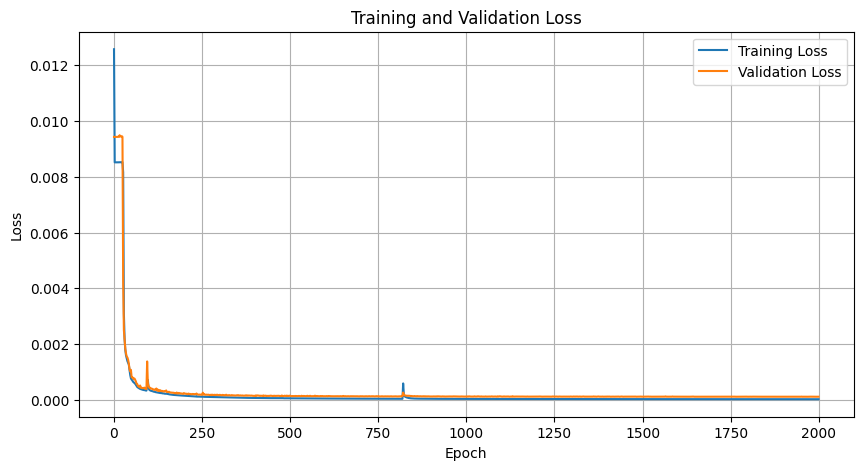

In [19]:
# Total Epoch
num_epochs = 1000
# Ploting Loss
t_loss = pd.read_csv('train_losses.csv', header=None)
v_loss = pd.read_csv('val_losses.csv', header=None)
ep = [i+1 for i in range(0, 2*num_epochs, 2)]
plt.figure(figsize=(10, 5))
plt.plot(ep, t_loss[0], label='Training Loss')
plt.plot(ep, v_loss[0], label='Validation Loss')
# Title
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Show
plt.grid(True)
plt.show()

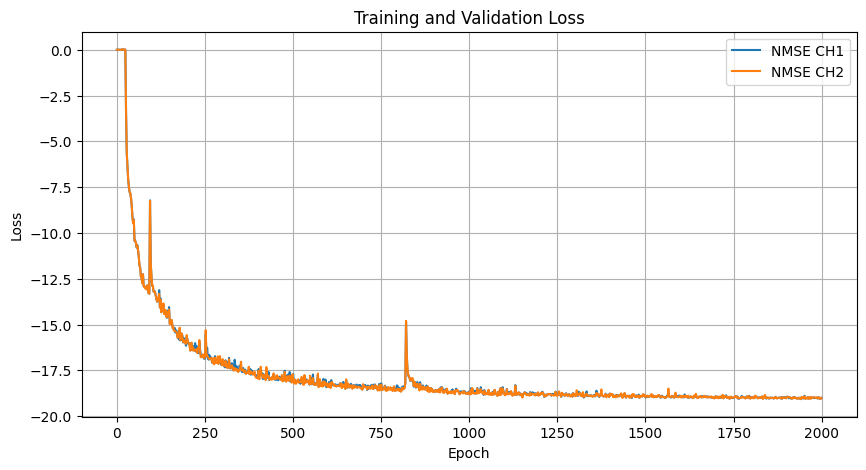

In [21]:
# Total Epoch
num_epochs = 1000
# Ploting Loss
t_loss = pd.read_csv('nmse1_scores.csv', header=None)
v_loss = pd.read_csv('nmse2_scores.csv', header=None)
ep = [i+1 for i in range(0, 2*num_epochs, 2)]
plt.figure(figsize=(10, 5))
plt.plot(ep, t_loss[0], label='NMSE CH1')
plt.plot(ep, v_loss[0], label='NMSE CH2')
# Title
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Show
plt.grid(True)
plt.show()

In [22]:
# Test Data
mat = sio.loadmat('./Data/test.mat')
H_mat = mat['HT']  # array

In [23]:
H_mat.shape

(72000, 2, 32, 32)

In [24]:

# Reshape the data if reqiured
df_test = np.reshape(H_mat, (36000, 4, 32, 32))
# Shape
print(Fore.BLUE + '- Test Dataset: ' + str(df_test.shape) + Style.RESET_ALL)
x_test = df_test.astype('float32')
x_test = torch.tensor(x_test).to(device)

# Testing data
autoencoder.eval()
start_time = time.time()
with torch.no_grad():
    x_hat = autoencoder(x_test).cpu().numpy()
end_time = time.time()
print("It cost %f sec" % ((end_time - start_time) / x_test.shape[0]))

- Test Dataset: (36000, 4, 32, 32)
It cost 0.003498 sec


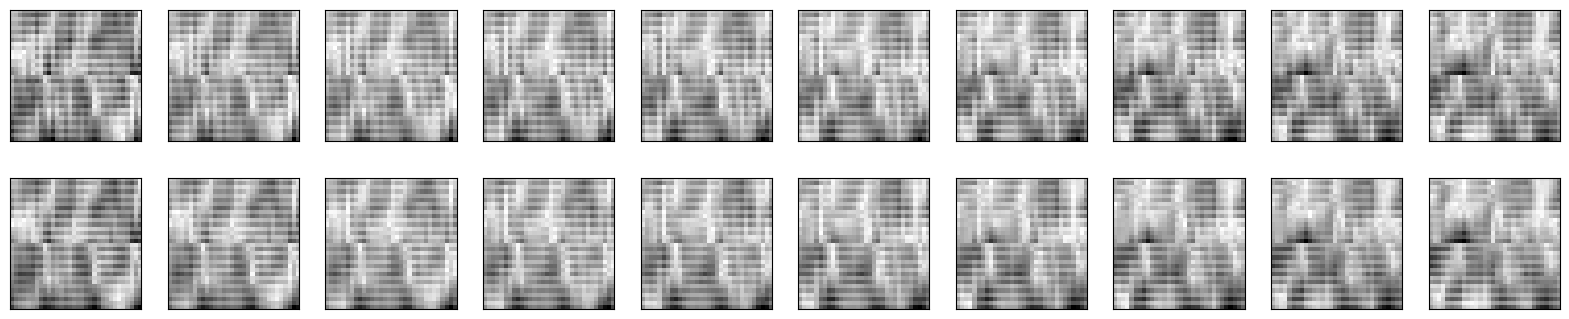

In [25]:
# Visualization
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    x_testplo = abs(x_test[i, 0, :, :].cpu().numpy() - 0.5 + 1j * (x_test[i, 1, :, :].cpu().numpy() - 0.5))
    plt.imshow(np.max(np.max(x_testplo)) - x_testplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
    
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    decoded_imgsplo = abs(x_hat[i, 0, :, :] - 0.5 + 1j * (x_hat[i, 1, :, :] - 0.5))
    plt.imshow(np.max(np.max(decoded_imgsplo)) - decoded_imgsplo.T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.invert_yaxis()
plt.show()

# Save the model
torch.save(autoencoder.state_dict(), "best_model.pth")


In [26]:
# Calculating NMSE

# x_test
x_test_real = np.reshape(x_test[:, 0, :, :].cpu().numpy(), (len(x_test), -1)) # dim. (20000, 1024)
x_test_imag = np.reshape(x_test[:, 1, :, :].cpu().numpy(), (len(x_test), -1)) # dim. (20000, 1024)
x_test_C = x_test_real - 0.5 + 1j * (x_test_imag - 0.5) # dim. (20000, 1024)

# x_hat
x_hat_real = np.reshape(x_hat[:, 0, :, :], (len(x_hat), -1)) # dim. (20000, 1024)
x_hat_imag = np.reshape(x_hat[:, 1, :, :], (len(x_hat), -1)) # dim. (20000, 1024)
x_hat_C = x_hat_real - 0.5 + 1j * (x_hat_imag - 0.5) # dim. (20000, 1024)

power = np.sum(abs(x_test_C) ** 2, axis=1)
mse = np.sum(abs(x_test_C - x_hat_C) ** 2, axis=1)

print("When dimension is", 512)
print("NMSE is ", 10 * math.log10(np.mean(mse / power)))

When dimension is 512
NMSE is  -18.897275691817256


In [27]:
nmse = evaluator(x_hat, x_test)
print(nmse)

(-18.897274017333984, -18.925310134887695)


In [28]:
i_actual = x_test[3000]

In [29]:
i_actual.shape

torch.Size([4, 32, 32])

In [30]:
i_pred = x_hat[3000]
i_pred.shape

(4, 32, 32)

In [31]:
i_actual_flat = i_actual.view(1, -1)

In [32]:
i_actual_flat.shape

torch.Size([1, 4096])

In [33]:
i_pred = torch.tensor(i_pred, dtype=torch.float32)

In [34]:
i_pred_flat = i_pred.view(1, -1)

In [35]:
i_pred_flat.shape

torch.Size([1, 4096])

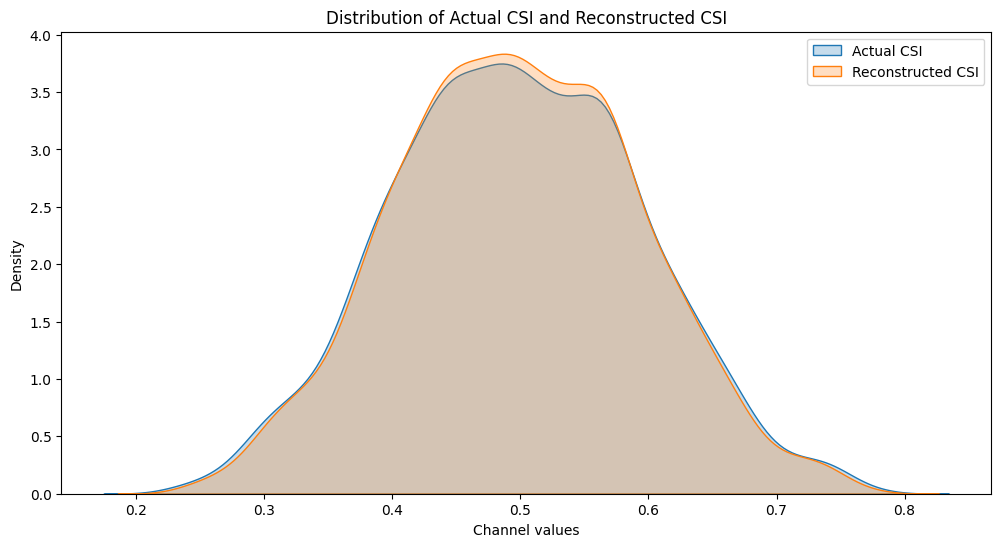

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

image1 = i_actual_flat.detach().cpu().numpy().flatten()
image2 = i_pred_flat.detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
sns.kdeplot(image1, label='Actual CSI', fill=True)
sns.kdeplot(image2, label='Reconstructed CSI', fill=True)

plt.title('Distribution of Actual CSI and Reconstructed CSI')
plt.xlabel('Channel values')
plt.ylabel('Density')
plt.legend()
plt.show()

In [37]:
x_test_mean = torch.tensor(x_test).view(-1, 2048).mean(axis=0)
x_hat_mean = torch.tensor(x_hat).view(-1, 2048).mean(axis=0)

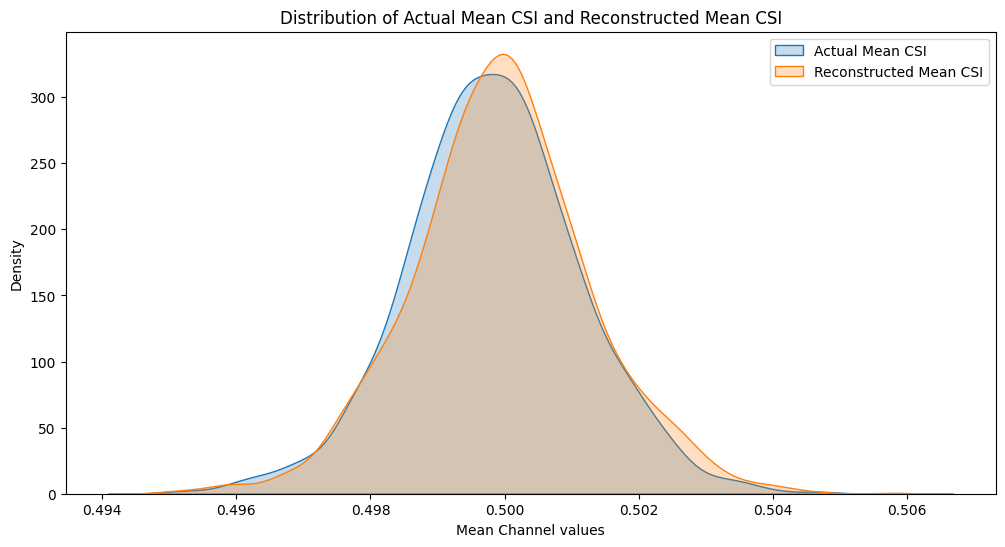

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

image1 = x_test_mean.detach().cpu().numpy().flatten()
image2 = x_hat_mean.detach().cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
sns.kdeplot(image1, label='Actual Mean CSI', fill=True)
sns.kdeplot(image2, label='Reconstructed Mean CSI', fill=True)

plt.title('Distribution of Actual Mean CSI and Reconstructed Mean CSI')
plt.xlabel('Mean Channel values')
plt.ylabel('Density')
plt.legend()
plt.show()